In [7]:
import numpy as np
import torch
import rc_tools as rct
import rc_analysis as rca
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from scipy.optimize import fsolve
from scipy.signal import argrelextrema
import sys
import warnings
import time

import pdb

from skopt.space import Real,Integer
from skopt.utils import use_named_args
from skopt import gp_minimize

import signalz

import warnings
warnings.filterwarnings("ignore")

from jupyterthemes import jtplot
jtplot.style()

np.random.seed(11)
torch.set_printoptions(precision=10)
dtype = torch.float32 

print(f'Python: {sys.version}')
print(f'Numpy: {np.__version__}')
print(f'Torch: {torch.__version__}')

DEVICE = 'cuda:4'

FREERUN = 1000
Ns = 20000+FREERUN
signal = signalz.mackey_glass(Ns, a=0.2, b=0.8, c=0.9, d=23, e=10, initial=0.1)
signal = signal - np.mean(signal)

M = signal.shape[0]-FREERUN
K = 1
L = 1
RF = .5
TEST = 300
LEAD = 100
BURNIN = 100
REG = 1e-8
TRAINLENGTH = M-TEST


MINMAX = np.max(signal[:TRAINLENGTH+TEST]) - np.min(signal[:TRAINLENGTH+TEST])
BINS = 50

print(f'Signal Length M={M}')

Python: 3.8.12 (default, Oct 12 2021, 13:49:34) 
[GCC 7.5.0]
Numpy: 1.21.2
Torch: 1.10.0
Signal Length M=20000


In [8]:
def get_weight_matricesGPU(k,n,l,ri,ro):
    win = torch.rand((n,k),dtype=dtype,
                      device=torch.device(DEVICE)).sub(.5).mul(ri)
    wfb = torch.zeros((n,l),dtype=dtype, device=torch.device(DEVICE))
    wout = torch.rand((l,n+k),dtype=dtype,
                      device=torch.device(DEVICE)).sub(.5).mul(ro)
    return win, wfb, wout

def set_vectorsGPU(n,l,r):
    x0 = torch.rand((n,1),dtype=dtype,
                      device=torch.device(DEVICE)).sub(.5).mul(r)
    y0 = torch.zeros((l,1),dtype=dtype, device=torch.device(DEVICE))
    return x0, y0

def update_res_stateGPU(wnet,xt,uxy,a,g):
    z = torch.matmul(wnet,uxy)
    return torch.mul(xt,1-a) + torch.mul(torch.tanh(z),a*g)

def predict_yGPU(wout,xu):
    return torch.matmul(wout, xu)

def get_matrixGPU(n,r,sr):
    A = (torch.rand((n,n),dtype=dtype,
                   device=torch.device(DEVICE))-.5)*r
    At = torch.transpose(A,0,1)
    D = torch.diag(torch.diag(A))   
    W = A + At - D
    eig = torch.eig(W, eigenvectors=False)
    wsr = torch.max(torch.abs(eig[0]))
    return W.div(wsr).mul(sr)

def resize_spaces(mn, mx, best, isAlpha=False):
    #pdb.set_trace()
    if(best.size==0):
        new_mn = np.max([0, mn - .5*mn])
        new_mx = 1.5*mx
    else:
        best_mn = np.min(best)
        best_mx = np.max(best)
        mn_bound = (best_mn-mn)/2
        mx_bound = (mx -best_mx)/2
        new_mn, new_mx = best_mn-mn_bound, best_mx+mx_bound
        print(f'\nBest mn:{best_mn:.3f}\t mn:{best_mx:.3f}')
        print(f'New bounds mn--mx: {mn_bound:.3f}--{mx_bound:.3f}')
    if(isAlpha):
        if(new_mx>1):
            new_mx = 1
    
    return new_mn, new_mx

In [9]:
min_a, max_a = .001, 1.
min_sr, max_sr = .001, 8.
min_g, max_g = .001, 1.
min_ri, max_ri = .001, 1.
min_rr, max_rr = .001, 5.
space = [Real(min_a, max_a, name='a'),
                 Real(min_sr, max_sr, name='sr'),
                 Real(min_g, max_g, name='amp'), 
                 Real(min_ri, max_ri, name='ri'),
                 Real(min_rr, max_rr, name='rr')
                ]

@use_named_args(space)
def loop(a=1.0,sr=1.0,amp=1.0,ri=1.0,rr=1.0):
    start = time.time()
    global running_error, s, signal, counter, N, \
           alphas, rhos, gammas, inScales, resScales
    
    ut = torch.zeros((1,1),dtype=dtype,
                     device=torch.device(DEVICE))
    tp = torch.zeros((1,1),dtype=dtype,
                     device=torch.device(DEVICE))
    
    Wres = get_matrixGPU(N,rr,sr)
    Win, Wfb, Wout = get_weight_matricesGPU(K,N,L,ri,RF)
    Wnet = torch.cat((Win,Wres,Wfb),1)
    xt, yt = set_vectorsGPU(N,L,rr)

    states = torch.zeros((TRAINLENGTH, N+K),dtype=dtype,
                         device=DEVICE)
    targets = torch.zeros((TRAINLENGTH),dtype=dtype,
                         device=DEVICE)
    for i in range(TRAINLENGTH):
        ut[0,0] = s[i]
        tp[0,0] = s[i+1]
        targets[i] = s[i+1]
        uxy = torch.cat((ut,xt,yt),0)
        xt1 = update_res_stateGPU(Wnet,xt,uxy,a,amp)
        xu = torch.transpose(torch.cat((xt1,ut),0),0,1).to(DEVICE)
        states[i,:] = xu[0,:]
        xt, yt = xt1, tp 
        
    state = states.detach().cpu().numpy()

    torch.cuda.synchronize()
    wout = rct.get_trained_weights(state[BURNIN:],
                                   signal[BURNIN+1:TRAINLENGTH+1],
                                   REG)
    Wout = torch.from_numpy(wout.reshape(L,N+K)).type(dtype).cuda(DEVICE)
    torch.cuda.synchronize()

    predictions = torch.zeros((M+FREERUN,1),
                              dtype=dtype,
                              device=torch.device(DEVICE))

    xt, yt = set_vectorsGPU(N,L,rr)
    ut.fill_(0.0)
    for i in range(M+FREERUN):
        if(i < TRAINLENGTH):
            ut[0,0] = s[i]
        else:
            ut = yt
        uxy = torch.cat((ut,xt,yt),0)
        xt1 = update_res_stateGPU(Wnet,xt,uxy,a,amp)
        xu = torch.cat((xt1,ut),0)
        yt1 = predict_yGPU(Wout,xu)
        predictions[i] = yt1[0,0]
        xt, yt = xt1, yt1

    yHat_GPU = predictions.detach().cpu().numpy()
    
    nrmse = 1000.0
    try:
        nrmse = rca.NRMSE(signal[TRAINLENGTH:TRAINLENGTH+TEST],
                          yHat_GPU[TRAINLENGTH:TRAINLENGTH+TEST],
                          MINMAX) 
    except:
        pass
        
    
    av = signal[TRAINLENGTH:TRAINLENGTH+TEST].reshape(TEST,1)
    bv = np.squeeze(yHat_GPU[TRAINLENGTH:TRAINLENGTH+TEST]).reshape(TEST,1)
    num = np.squeeze(np.dot(av.T,bv))
    den = np.linalg.norm(av)*np.linalg.norm(bv)
    cosine_similarity = num/den
    cosine_distance = 1 - cosine_similarity
    dist = cosine_distance
    
    loss = nrmse + dist
    if(np.isnan(loss) or (np.isinf(loss) or (loss > 1000.0))):
        loss = 1000

    if((loss < running_error) & (loss < .9)):
        alphas.append(a)
        rhos.append(sr)
        gammas.append(amp)
        inScales.append(ri)
        resScales.append(rr)
        running_error = loss
        wnet = Wnet.detach().cpu().numpy()
        currentParams = np.array([a,sr,amp,ri,rr,loss])
        
        fig = plt.figure(figsize=(10,8))
        ax1 = plt.subplot(111)
        ax1.plot(signal[TRAINLENGTH-LEAD:], label='Target')
        ax1.plot(yHat_GPU[TRAINLENGTH-LEAD:], label='GPU')
        ax1.axvline(LEAD,c='orange',linestyle='dashed')
        ax1.axvline(LEAD+TEST,c='r',linestyle='dashed')
        ax1.set_ylim(-2,2)
        ax1.legend()
        plt.show()
        fig.savefig(f'./MG_Saved_Models/MG_sz{N}_ref{ref}_run{rn}_iter{counter}.pdf',
                    format='pdf', bbox_inches='tight', pad_inches=.01)
        plt.close()
        
        np.save(f'./MG_Saved_Models/MG_it{counter}_{N}_Wnet',wnet)
        np.save(f'./MG_Saved_Models/MG_it{counter}_{N}_Preds',yHat_GPU)
        np.save(f'./MG_Saved_Models/MG_it{counter}_{N}_InstanceParams',currentParams)  
        print(f' Iter={counter} a={a:.3f} sr={sr:.3f} amp={amp:.3f}',
              f' ri={ri:.3f} rr={rr:.3f} loss={loss:3f}\n\n')
    
    print(f'Iter: {counter} #### Diagnostic {loss:.3f}   Time {(time.time()-start):.2f}',
          f' Best {running_error:.3f} NRMSE {nrmse:.3f} CD {dist:.3f}')
    
    counter += 1
    return loss


 ********** 1000 ***********


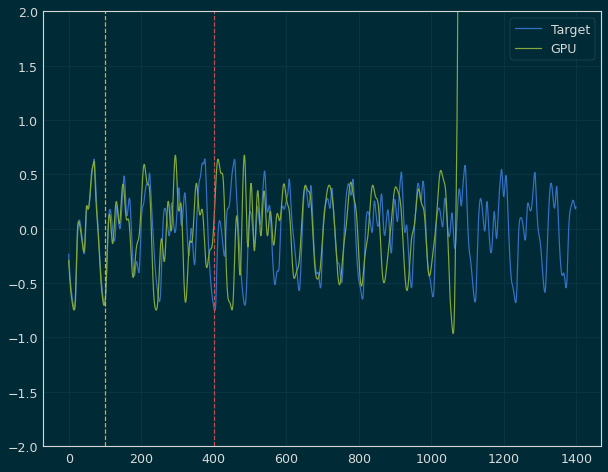

 Iter=0 a=0.069 sr=5.318 amp=0.195  ri=0.926 rr=0.527 loss=0.714264


Iter: 0 #### Diagnostic 0.714   Time 18.65  Best 0.714 NRMSE 0.204 CD 0.510
Iter: 1 #### Diagnostic 1000.000   Time 21.13  Best 0.714 NRMSE 1000.000 CD nan
Iter: 2 #### Diagnostic 1000.000   Time 16.84  Best 0.714 NRMSE 1000.000 CD nan
Iter: 3 #### Diagnostic 1000.000   Time 19.98  Best 0.714 NRMSE 1000.000 CD nan
Iter: 4 #### Diagnostic 1.202   Time 13.20  Best 0.714 NRMSE 0.215 CD 0.987
Iter: 5 #### Diagnostic 1000.000   Time 18.94  Best 0.714 NRMSE 1000.000 CD nan
Iter: 6 #### Diagnostic 1000.000   Time 23.25  Best 0.714 NRMSE 1000.000 CD nan
Iter: 7 #### Diagnostic 1000.000   Time 16.25  Best 0.714 NRMSE 1000.000 CD nan


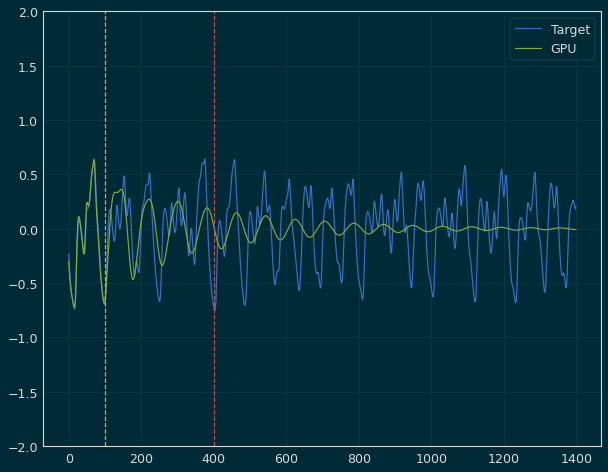

 Iter=8 a=0.044 sr=1.570 amp=0.477  ri=0.038 rr=0.031 loss=0.663963


Iter: 8 #### Diagnostic 0.664   Time 21.46  Best 0.664 NRMSE 0.177 CD 0.487
Iter: 9 #### Diagnostic 1000.000   Time 17.78  Best 0.664 NRMSE 1000.000 CD nan
Iter: 10 #### Diagnostic 1.069   Time 20.64  Best 0.664 NRMSE 0.277 CD 0.792
Iter: 11 #### Diagnostic 1000.000   Time 16.06  Best 0.664 NRMSE 1000.000 CD nan
Iter: 12 #### Diagnostic 1000.000   Time 19.40  Best 0.664 NRMSE 1000.000 CD nan
Iter: 13 #### Diagnostic 0.960   Time 19.15  Best 0.664 NRMSE 0.199 CD 0.760
Iter: 14 #### Diagnostic 1.175   Time 20.24  Best 0.664 NRMSE 0.272 CD 0.903


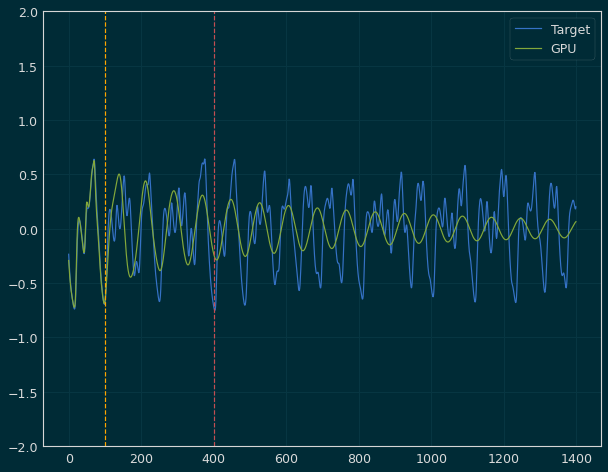

 Iter=15 a=0.090 sr=2.324 amp=0.111  ri=0.140 rr=3.057 loss=0.612638


Iter: 15 #### Diagnostic 0.613   Time 19.56  Best 0.613 NRMSE 0.177 CD 0.436
Iter: 16 #### Diagnostic 1000.000   Time 18.02  Best 0.613 NRMSE 1000.000 CD nan
Iter: 17 #### Diagnostic 1000.000   Time 20.26  Best 0.613 NRMSE 1000.000 CD nan


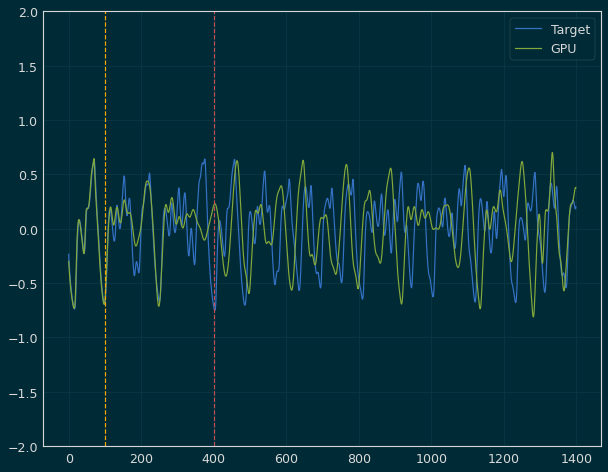

 Iter=18 a=0.258 sr=4.123 amp=0.197  ri=0.514 rr=0.186 loss=0.567605


Iter: 18 #### Diagnostic 0.568   Time 19.90  Best 0.568 NRMSE 0.162 CD 0.406
Iter: 19 #### Diagnostic 0.945   Time 22.09  Best 0.568 NRMSE 0.194 CD 0.751
Iter: 20 #### Diagnostic 1000.000   Time 13.59  Best 0.568 NRMSE 1000.000 CD nan
Iter: 21 #### Diagnostic 0.830   Time 21.98  Best 0.568 NRMSE 0.189 CD 0.641
Iter: 22 #### Diagnostic 0.663   Time 17.48  Best 0.568 NRMSE 0.188 CD 0.475
Iter: 23 #### Diagnostic 1000.000   Time 20.00  Best 0.568 NRMSE 1000.000 CD nan
Iter: 24 #### Diagnostic 1000.000   Time 19.49  Best 0.568 NRMSE 34368874779485828255055872.000 CD 1.000
Iter: 25 #### Diagnostic 1000.000   Time 12.42  Best 0.568 NRMSE 1000.000 CD nan
Iter: 26 #### Diagnostic 1000.000   Time 19.82  Best 0.568 NRMSE 1000.000 CD nan
Iter: 27 #### Diagnostic 1.268   Time 20.59  Best 0.568 NRMSE 0.248 CD 1.020
Iter: 28 #### Diagnostic 1.097   Time 19.93  Best 0.568 NRMSE 0.269 CD 0.829
Iter: 29 #### Diagnostic 1.058   Time 

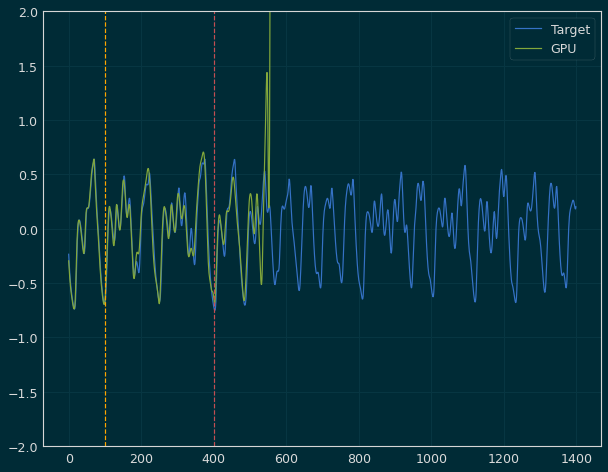

 Iter=80 a=0.452 sr=7.505 amp=0.135  ri=0.826 rr=1.886 loss=0.089519


Iter: 80 #### Diagnostic 0.090   Time 21.67  Best 0.090 NRMSE 0.054 CD 0.036
Iter: 81 #### Diagnostic 1000.000   Time 19.87  Best 0.090 NRMSE 1000.000 CD nan
Iter: 82 #### Diagnostic 1000.000   Time 20.24  Best 0.090 NRMSE 1000.000 CD nan
Iter: 83 #### Diagnostic 1.333   Time 17.29  Best 0.090 NRMSE 0.242 CD 1.091
Iter: 84 #### Diagnostic 1000.000   Time 21.93  Best 0.090 NRMSE 1000.000 CD nan
Iter: 85 #### Diagnostic 1000.000   Time 15.14  Best 0.090 NRMSE 955364791776247115939840.000 CD 1.000
Iter: 86 #### Diagnostic 1000.000   Time 15.19  Best 0.090 NRMSE 1000.000 CD nan
Iter: 87 #### Diagnostic 1000.000   Time 15.40  Best 0.090 NRMSE 1000.000 CD nan
Iter: 88 #### Diagnostic 0.169   Time 18.76  Best 0.090 NRMSE 0.081 CD 0.087
Iter: 89 #### Diagnostic 1000.000   Time 18.01  Best 0.090 NRMSE 1000.000 CD nan
Iter: 90 #### Diagnostic 1000.000   Time 18.01  Best 0.090 NRMSE 1000.000 CD nan
Iter: 91 #### Diagnostic 379

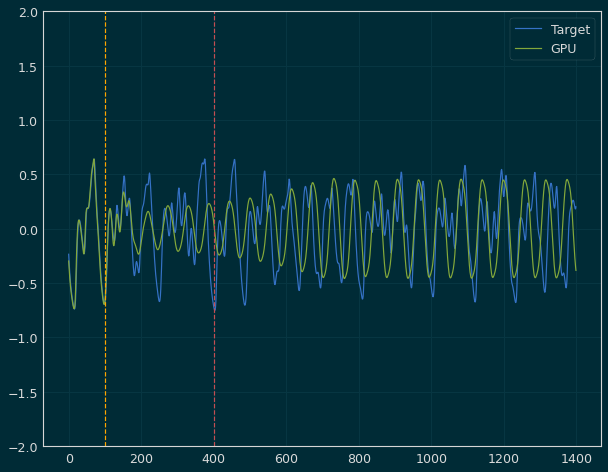

 Iter=3 a=0.407 sr=0.765 amp=0.910  ri=0.673 rr=4.132 loss=0.852990


Iter: 3 #### Diagnostic 0.853   Time 18.90  Best 0.853 NRMSE 0.192 CD 0.661
Iter: 4 #### Diagnostic 1000.000   Time 18.30  Best 0.853 NRMSE 1000.000 CD nan
Iter: 5 #### Diagnostic 1000.000   Time 24.86  Best 0.853 NRMSE 1000.000 CD nan
Iter: 6 #### Diagnostic 1000.000   Time 18.18  Best 0.853 NRMSE 1000.000 CD nan
Iter: 7 #### Diagnostic 1.028   Time 20.51  Best 0.853 NRMSE 0.199 CD 0.829
Iter: 8 #### Diagnostic 1000.000   Time 22.73  Best 0.853 NRMSE 1000.000 CD nan
Iter: 9 #### Diagnostic 1000.000   Time 17.05  Best 0.853 NRMSE 1000.000 CD nan
Iter: 10 #### Diagnostic 1.254   Time 18.98  Best 0.853 NRMSE 0.276 CD 0.977
Iter: 11 #### Diagnostic 1.358   Time 22.17  Best 0.853 NRMSE 0.298 CD 1.060
Iter: 12 #### Diagnostic 1.318   Time 21.62  Best 0.853 NRMSE 0.237 CD 1.081


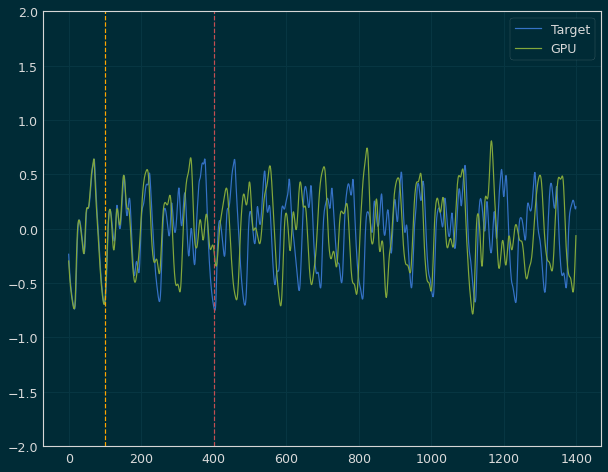

 Iter=13 a=0.643 sr=4.119 amp=0.234  ri=0.505 rr=3.252 loss=0.725555


Iter: 13 #### Diagnostic 0.726   Time 20.61  Best 0.726 NRMSE 0.201 CD 0.524
Iter: 14 #### Diagnostic 1.098   Time 15.94  Best 0.726 NRMSE 0.207 CD 0.891


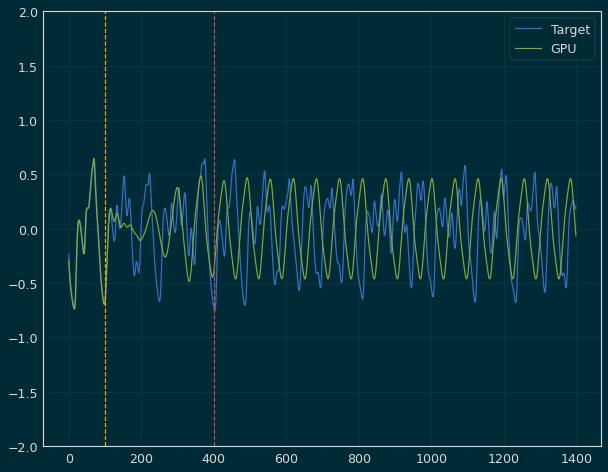

 Iter=15 a=0.459 sr=1.411 amp=0.541  ri=0.345 rr=2.785 loss=0.669881


Iter: 15 #### Diagnostic 0.670   Time 20.23  Best 0.670 NRMSE 0.176 CD 0.494
Iter: 16 #### Diagnostic 1.036   Time 21.66  Best 0.670 NRMSE 0.229 CD 0.807
Iter: 17 #### Diagnostic 1.295   Time 17.95  Best 0.670 NRMSE 0.233 CD 1.062
Iter: 18 #### Diagnostic 1000.000   Time 20.31  Best 0.670 NRMSE 1000.000 CD nan
Iter: 19 #### Diagnostic 1000.000   Time 16.55  Best 0.670 NRMSE 1000.000 CD nan
Iter: 20 #### Diagnostic 1.083   Time 15.22  Best 0.670 NRMSE 0.201 CD 0.881
Iter: 21 #### Diagnostic 1000.000   Time 21.74  Best 0.670 NRMSE 1000.000 CD nan
Iter: 22 #### Diagnostic 1.042   Time 18.52  Best 0.670 NRMSE 0.202 CD 0.841
Iter: 23 #### Diagnostic 1000.000   Time 14.90  Best 0.670 NRMSE 1000.000 CD nan
Iter: 24 #### Diagnostic 1000.000   Time 17.60  Best 0.670 NRMSE 1000.000 CD nan
Iter: 25 #### Diagnostic 1000.000   Time 20.89  Best 0.670 NRMSE 1000.000 CD nan
Iter: 26 #### Diagnostic 1000.000   Time 21.05  Best 0.670

Iter: 15 #### Diagnostic 0.968   Time 15.21  Best 1000.000 NRMSE 0.194 CD 0.774
Iter: 16 #### Diagnostic 1.061   Time 17.12  Best 1000.000 NRMSE 0.200 CD 0.861
Iter: 17 #### Diagnostic 1000.000   Time 21.14  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 18 #### Diagnostic 1000.000   Time 18.62  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 19 #### Diagnostic 1000.000   Time 20.93  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 20 #### Diagnostic 1000.000   Time 15.09  Best 1000.000 NRMSE 1000.000 CD nan


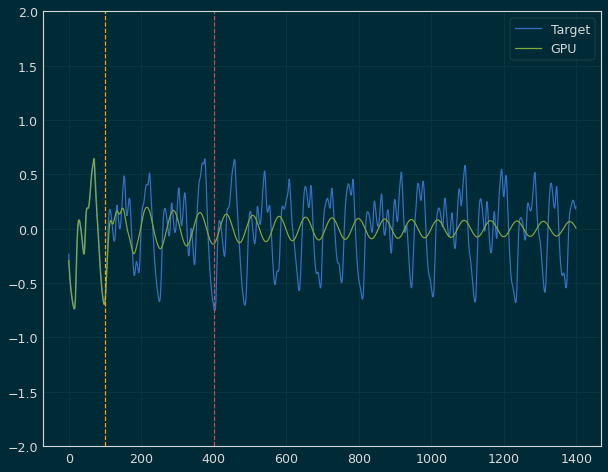

 Iter=21 a=0.470 sr=4.021 amp=0.173  ri=0.299 rr=1.345 loss=0.486881


Iter: 21 #### Diagnostic 0.487   Time 17.05  Best 0.487 NRMSE 0.154 CD 0.333
Iter: 22 #### Diagnostic 1000.000   Time 15.01  Best 0.487 NRMSE 1000.000 CD nan
Iter: 23 #### Diagnostic 1.274   Time 20.49  Best 0.487 NRMSE 0.246 CD 1.028
Iter: 24 #### Diagnostic 1000.000   Time 21.00  Best 0.487 NRMSE 1000.000 CD nan
Iter: 25 #### Diagnostic 1000.000   Time 16.35  Best 0.487 NRMSE 1000.000 CD nan
Iter: 26 #### Diagnostic 1000.000   Time 18.10  Best 0.487 NRMSE 1459882142349118.000 CD 0.871
Iter: 27 #### Diagnostic 1000.000   Time 17.54  Best 0.487 NRMSE 1000.000 CD nan
Iter: 28 #### Diagnostic 1000.000   Time 17.12  Best 0.487 NRMSE 1000.000 CD nan
Iter: 29 #### Diagnostic 1.133   Time 14.18  Best 0.487 NRMSE 0.206 CD 0.927
Iter: 30 #### Diagnostic 1000.000   Time 20.82  Best 0.487 NRMSE 1000.000 CD nan
Iter: 31 #### Diagnostic 1000.000   Time 17.26  Best 0.487 NRMSE 1000.000 CD nan
Iter: 32 #### Diagnostic 0.986   Tim

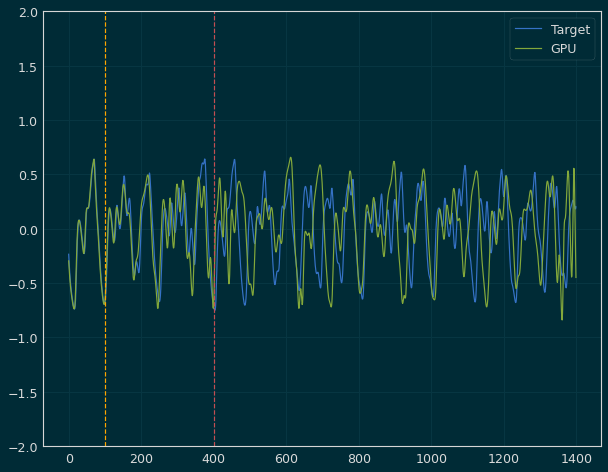

 Iter=97 a=0.456 sr=3.176 amp=0.325  ri=0.475 rr=4.335 loss=0.305040


Iter: 97 #### Diagnostic 0.305   Time 16.59  Best 0.305 NRMSE 0.120 CD 0.185
Iter: 98 #### Diagnostic 1000.000   Time 18.36  Best 0.305 NRMSE 1000.000 CD nan
Iter: 99 #### Diagnostic 1000.000   Time 11.67  Best 0.305 NRMSE 1000.000 CD nan

Best result = 0.3050399892843194
a = 0.4564743938461775
sr = 3.175800413434468
amp = 0.32451025744591405
ri = 0.47548188660427276
rr = 4.335174181102914

 ********** 1000 ***********
Iter: 0 #### Diagnostic 0.994   Time 16.20  Best 1000.000 NRMSE 0.196 CD 0.798
Iter: 1 #### Diagnostic 1000.000   Time 14.18  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 2 #### Diagnostic 1000.000   Time 15.73  Best 1000.000 NRMSE 2424998.800 CD 1.097
Iter: 3 #### Diagnostic 1000.000   Time 20.13  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 4 #### Diagnostic 1000.000   Time 19.09  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 5 #### Diagnostic 1000.000   Time 21.79  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 6

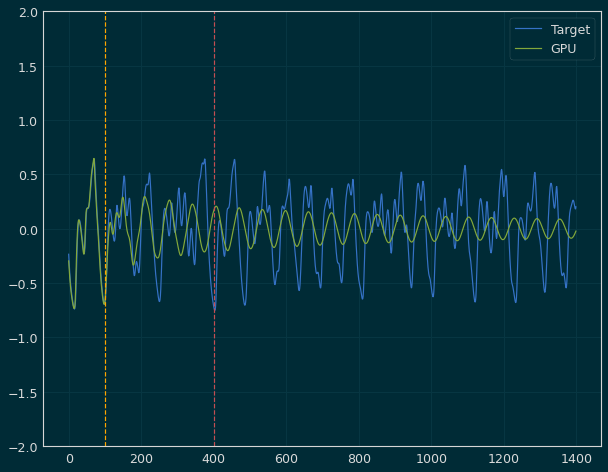

 Iter=7 a=0.388 sr=2.689 amp=0.238  ri=0.525 rr=1.592 loss=0.899919


Iter: 7 #### Diagnostic 0.900   Time 19.00  Best 0.900 NRMSE 0.198 CD 0.702
Iter: 8 #### Diagnostic 1000.000   Time 23.05  Best 0.900 NRMSE 1000.000 CD nan


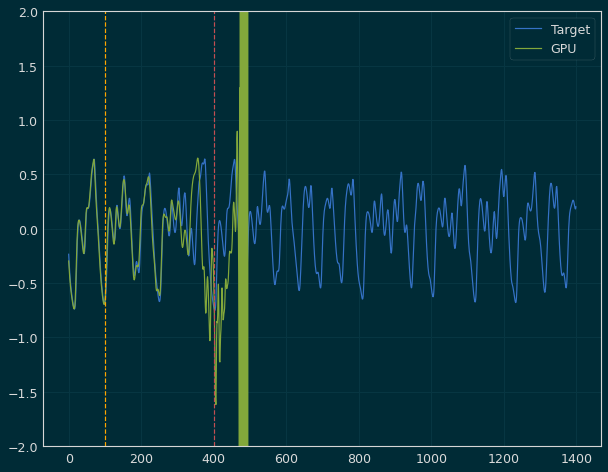

 Iter=9 a=0.613 sr=6.585 amp=0.165  ri=0.637 rr=4.248 loss=0.662089


Iter: 9 #### Diagnostic 0.662   Time 18.11  Best 0.662 NRMSE 0.199 CD 0.463
Iter: 10 #### Diagnostic 1.624   Time 13.42  Best 0.662 NRMSE 0.303 CD 1.321
Iter: 11 #### Diagnostic 1000.000   Time 17.64  Best 0.662 NRMSE 1000.000 CD nan
Iter: 12 #### Diagnostic 1000.000   Time 15.29  Best 0.662 NRMSE 1000.000 CD nan
Iter: 13 #### Diagnostic 1000.000   Time 19.50  Best 0.662 NRMSE 1000.000 CD nan
Iter: 14 #### Diagnostic 1000.000   Time 16.36  Best 0.662 NRMSE 1000.000 CD nan
Iter: 15 #### Diagnostic 1000.000   Time 17.04  Best 0.662 NRMSE 1000.000 CD nan
Iter: 16 #### Diagnostic 1000.000   Time 19.09  Best 0.662 NRMSE 1000.000 CD nan
Iter: 17 #### Diagnostic 1000.000   Time 24.10  Best 0.662 NRMSE 1000.000 CD nan
Iter: 18 #### Diagnostic 1.246   Time 20.15  Best 0.662 NRMSE 0.225 CD 1.021
Iter: 19 #### Diagnostic 1000.000   Time 15.60  Best 0.662 NRMSE 1000.000 CD nan
Iter: 20 #### Diagnostic 1.476   Time 18.87  Best 0.

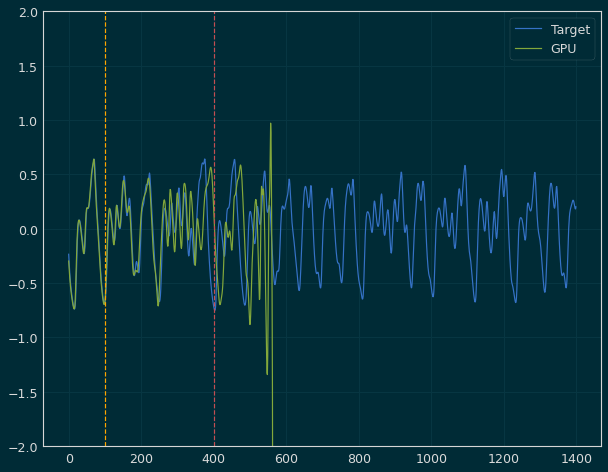

 Iter=33 a=0.722 sr=1.044 amp=0.987  ri=0.297 rr=1.165 loss=0.607861


Iter: 33 #### Diagnostic 0.608   Time 13.99  Best 0.608 NRMSE 0.177 CD 0.431
Iter: 34 #### Diagnostic 1000.000   Time 17.50  Best 0.608 NRMSE 1000.000 CD nan
Iter: 35 #### Diagnostic 1.057   Time 21.14  Best 0.608 NRMSE 0.260 CD 0.796
Iter: 36 #### Diagnostic 1000.000   Time 19.67  Best 0.608 NRMSE 27300021173407224.000 CD 0.735
Iter: 37 #### Diagnostic 0.996   Time 22.96  Best 0.608 NRMSE 0.197 CD 0.799
Iter: 38 #### Diagnostic 0.808   Time 20.48  Best 0.608 NRMSE 0.191 CD 0.617
Iter: 39 #### Diagnostic 1.002   Time 20.91  Best 0.608 NRMSE 0.199 CD 0.803
Iter: 40 #### Diagnostic 1.242   Time 15.30  Best 0.608 NRMSE 0.225 CD 1.017
Iter: 41 #### Diagnostic 1.066   Time 18.65  Best 0.608 NRMSE 0.201 CD 0.865
Iter: 42 #### Diagnostic 1.023   Time 12.45  Best 0.608 NRMSE 0.241 CD 0.782
Iter: 43 #### Diagnostic 1000.000   Time 18.37  Best 0.608 NRMSE 1000.000 CD nan
Iter: 44 #### Diagnostic 1000.000   Time 18.74  Best 0.

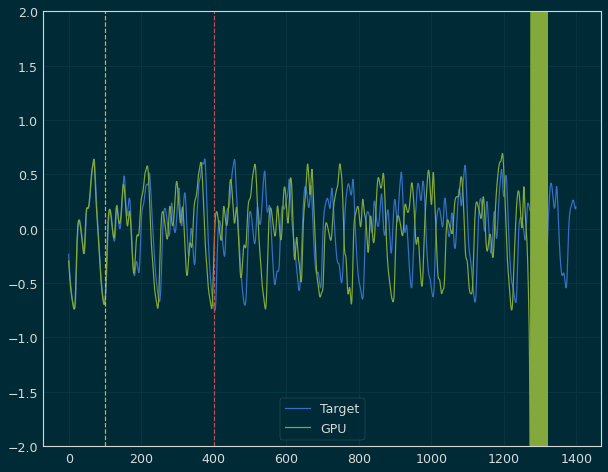

 Iter=64 a=0.823 sr=3.513 amp=0.312  ri=0.991 rr=1.873 loss=0.437590


Iter: 64 #### Diagnostic 0.438   Time 22.07  Best 0.438 NRMSE 0.153 CD 0.285
Iter: 65 #### Diagnostic 1.328   Time 15.27  Best 0.438 NRMSE 0.291 CD 1.038
Iter: 66 #### Diagnostic 1000.000   Time 19.63  Best 0.438 NRMSE 1000.000 CD nan
Iter: 67 #### Diagnostic 1000.000   Time 17.47  Best 0.438 NRMSE 1000.000 CD nan
Iter: 68 #### Diagnostic 1000.000   Time 22.63  Best 0.438 NRMSE 1000.000 CD nan
Iter: 69 #### Diagnostic 9.128   Time 19.95  Best 0.438 NRMSE 7.925 CD 1.203
Iter: 70 #### Diagnostic 1000.000   Time 21.60  Best 0.438 NRMSE 1000.000 CD nan
Iter: 71 #### Diagnostic 1000.000   Time 11.80  Best 0.438 NRMSE 1000.000 CD nan
Iter: 72 #### Diagnostic 1000.000   Time 22.50  Best 0.438 NRMSE 1000.000 CD nan
Iter: 73 #### Diagnostic 1000.000   Time 18.63  Best 0.438 NRMSE 1000.000 CD nan
Iter: 74 #### Diagnostic 1000.000   Time 18.23  Best 0.438 NRMSE 1000.000 CD nan
Iter: 75 #### Diagnostic 1000.000   Time 16.36  Be

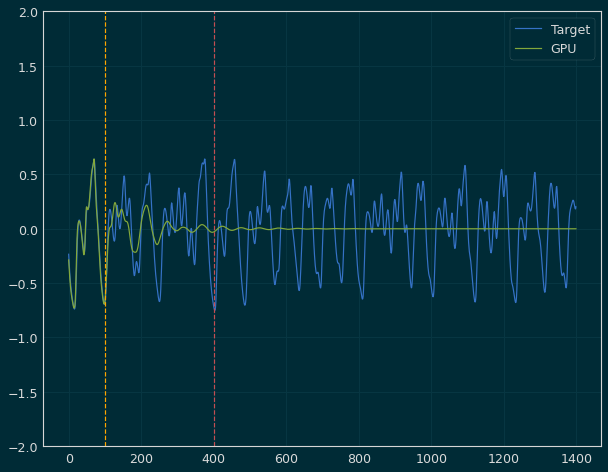

 Iter=2 a=0.197 sr=3.681 amp=0.102  ri=0.338 rr=2.310 loss=0.559755


Iter: 2 #### Diagnostic 0.560   Time 21.64  Best 0.560 NRMSE 0.164 CD 0.396
Iter: 3 #### Diagnostic 1000.000   Time 16.16  Best 0.560 NRMSE 1000.000 CD nan
Iter: 4 #### Diagnostic 1000.000   Time 19.95  Best 0.560 NRMSE 3881025.373 CD 0.823
Iter: 5 #### Diagnostic 1000.000   Time 19.41  Best 0.560 NRMSE 1000.000 CD nan
Iter: 6 #### Diagnostic 1000.000   Time 17.25  Best 0.560 NRMSE 1000.000 CD nan
Iter: 7 #### Diagnostic 1000.000   Time 18.02  Best 0.560 NRMSE 1000.000 CD nan
Iter: 8 #### Diagnostic 0.926   Time 21.25  Best 0.560 NRMSE 0.218 CD 0.708
Iter: 9 #### Diagnostic 1000.000   Time 21.47  Best 0.560 NRMSE 1000.000 CD nan
Iter: 10 #### Diagnostic 1000.000   Time 19.15  Best 0.560 NRMSE 1000.000 CD nan
Iter: 11 #### Diagnostic 1.227   Time 18.87  Best 0.560 NRMSE 0.212 CD 1.015
Iter: 12 #### Diagnostic 1000.000   Time 23.49  Best 0.560 NRMSE 1000.000 CD nan
Iter: 13 #### Diagnostic 1000.000   Time 18.60  Best 0

Iter: 0 #### Diagnostic 1000.000   Time 20.94  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 1 #### Diagnostic 1000.000   Time 17.75  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 2 #### Diagnostic 1000.000   Time 20.70  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 3 #### Diagnostic 1000.000   Time 24.32  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 4 #### Diagnostic 1.220   Time 16.56  Best 1000.000 NRMSE 0.217 CD 1.003
Iter: 5 #### Diagnostic 1000.000   Time 14.61  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 6 #### Diagnostic 1000.000   Time 16.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 7 #### Diagnostic 1000.000   Time 16.40  Best 1000.000 NRMSE 1000.000 CD nan


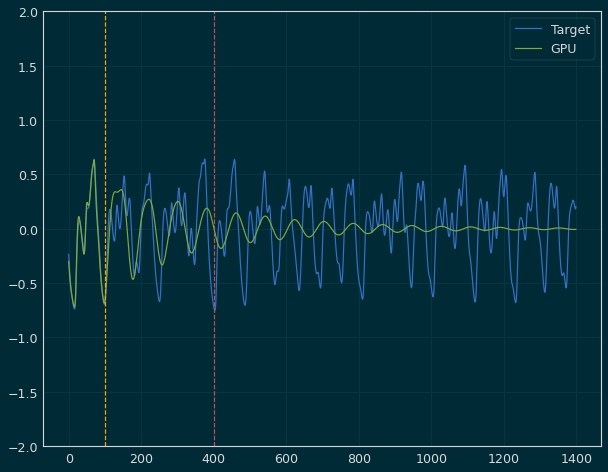

 Iter=8 a=0.044 sr=1.570 amp=0.477  ri=0.038 rr=0.031 loss=0.653807


Iter: 8 #### Diagnostic 0.654   Time 18.24  Best 0.654 NRMSE 0.175 CD 0.478
Iter: 9 #### Diagnostic 1000.000   Time 17.04  Best 0.654 NRMSE 1000.000 CD nan
Iter: 10 #### Diagnostic 1000.000   Time 15.29  Best 0.654 NRMSE 1000.000 CD nan
Iter: 11 #### Diagnostic 1000.000   Time 15.66  Best 0.654 NRMSE 1000.000 CD nan
Iter: 12 #### Diagnostic 1000.000   Time 12.94  Best 0.654 NRMSE 1000.000 CD nan
Iter: 13 #### Diagnostic 0.964   Time 18.97  Best 0.654 NRMSE 0.200 CD 0.764
Iter: 14 #### Diagnostic 1000.000   Time 17.63  Best 0.654 NRMSE 1000.000 CD nan


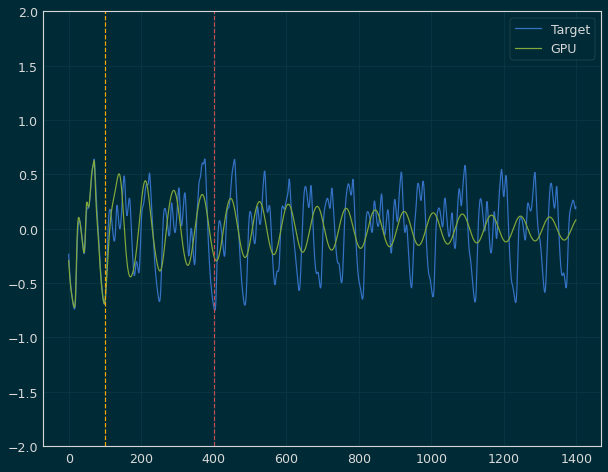

 Iter=15 a=0.090 sr=2.324 amp=0.111  ri=0.140 rr=3.057 loss=0.616303


Iter: 15 #### Diagnostic 0.616   Time 20.13  Best 0.616 NRMSE 0.177 CD 0.439
Iter: 16 #### Diagnostic 1000.000   Time 18.11  Best 0.616 NRMSE 1000.000 CD nan
Iter: 17 #### Diagnostic 1000.000   Time 16.17  Best 0.616 NRMSE 1000.000 CD nan
Iter: 18 #### Diagnostic 0.824   Time 20.26  Best 0.616 NRMSE 0.200 CD 0.624
Iter: 19 #### Diagnostic 0.941   Time 19.65  Best 0.616 NRMSE 0.193 CD 0.748
Iter: 20 #### Diagnostic 1000.000   Time 18.07  Best 0.616 NRMSE 1000.000 CD nan
Iter: 21 #### Diagnostic 0.830   Time 16.90  Best 0.616 NRMSE 0.189 CD 0.641
Iter: 22 #### Diagnostic 1000.000   Time 19.78  Best 0.616 NRMSE 1000.000 CD nan
Iter: 23 #### Diagnostic 1000.000   Time 19.52  Best 0.616 NRMSE 1000.000 CD nan


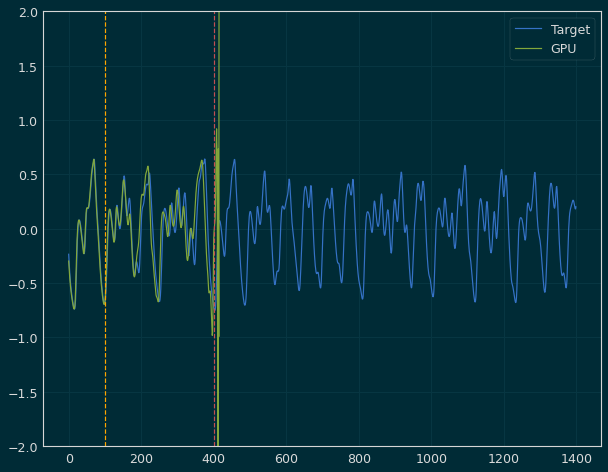

 Iter=24 a=0.890 sr=1.391 amp=0.942  ri=0.842 rr=0.772 loss=0.316228


Iter: 24 #### Diagnostic 0.316   Time 19.61  Best 0.316 NRMSE 0.126 CD 0.191
Iter: 25 #### Diagnostic 1000.000   Time 20.30  Best 0.316 NRMSE 1000.000 CD nan
Iter: 26 #### Diagnostic 1000.000   Time 19.51  Best 0.316 NRMSE 1000.000 CD nan
Iter: 27 #### Diagnostic 1.200   Time 17.40  Best 0.316 NRMSE 0.253 CD 0.947
Iter: 28 #### Diagnostic 1000.000   Time 13.84  Best 0.316 NRMSE 1000.000 CD nan
Iter: 29 #### Diagnostic 1.080   Time 17.13  Best 0.316 NRMSE 0.248 CD 0.832
Iter: 30 #### Diagnostic 0.859   Time 22.27  Best 0.316 NRMSE 0.194 CD 0.664
Iter: 31 #### Diagnostic 1000.000   Time 19.17  Best 0.316 NRMSE 1000.000 CD nan
Iter: 32 #### Diagnostic 1.316   Time 21.14  Best 0.316 NRMSE 0.286 CD 1.029
Iter: 33 #### Diagnostic 1000.000   Time 20.96  Best 0.316 NRMSE 1000.000 CD nan
Iter: 34 #### Diagnostic 1000.000   Time 20.70  Best 0.316 NRMSE 1000.000 CD nan
Iter: 35 #### Diagnostic 0.924   Time 13.95  Best 0.316 NR

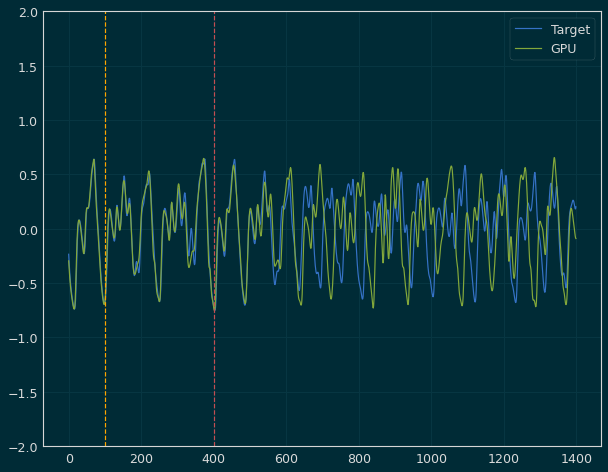

 Iter=36 a=0.713 sr=4.980 amp=0.240  ri=0.691 rr=1.424 loss=0.071476


Iter: 36 #### Diagnostic 0.071   Time 20.01  Best 0.071 NRMSE 0.045 CD 0.026
Iter: 37 #### Diagnostic 1000.000   Time 18.62  Best 0.071 NRMSE 1000.000 CD nan
Iter: 38 #### Diagnostic 1000.000   Time 20.15  Best 0.071 NRMSE 1000.000 CD nan
Iter: 39 #### Diagnostic 1000.000   Time 21.33  Best 0.071 NRMSE 1000.000 CD nan
Iter: 40 #### Diagnostic 1.007   Time 19.62  Best 0.071 NRMSE 0.197 CD 0.810
Iter: 41 #### Diagnostic 1.264   Time 18.79  Best 0.071 NRMSE 0.224 CD 1.040
Iter: 42 #### Diagnostic 1.373   Time 15.22  Best 0.071 NRMSE 0.323 CD 1.051
Iter: 43 #### Diagnostic 0.716   Time 16.26  Best 0.071 NRMSE 0.202 CD 0.514
Iter: 44 #### Diagnostic 1000.000   Time 17.85  Best 0.071 NRMSE 1000.000 CD nan
Iter: 45 #### Diagnostic 1000.000   Time 16.98  Best 0.071 NRMSE 1000.000 CD nan
Iter: 46 #### Diagnostic 1000.000   Time 21.26  Best 0.071 NRMSE 1000.000 CD nan
Iter: 47 #### Diagnostic 0.226   Time 21.26  Best 0.071 NR

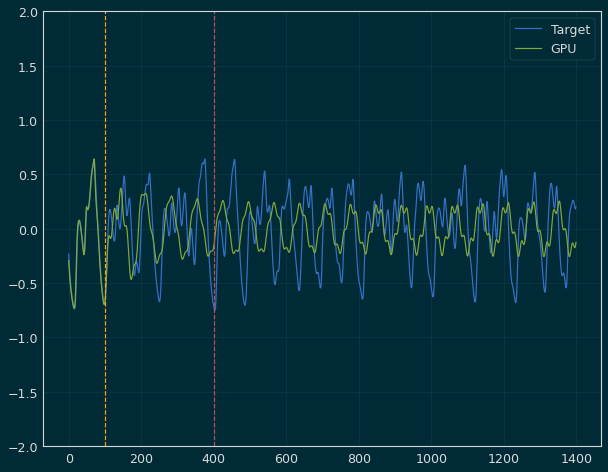

 Iter=8 a=0.173 sr=0.335 amp=0.946  ri=0.765 rr=4.274 loss=0.762009


Iter: 8 #### Diagnostic 0.762   Time 21.83  Best 0.762 NRMSE 0.189 CD 0.573
Iter: 9 #### Diagnostic 1000.000   Time 16.35  Best 0.762 NRMSE 1000.000 CD nan
Iter: 10 #### Diagnostic 1.203   Time 21.82  Best 0.762 NRMSE 0.270 CD 0.933
Iter: 11 #### Diagnostic 1000.000   Time 17.83  Best 0.762 NRMSE 1000.000 CD nan
Iter: 12 #### Diagnostic 1.319   Time 17.52  Best 0.762 NRMSE 0.237 CD 1.082


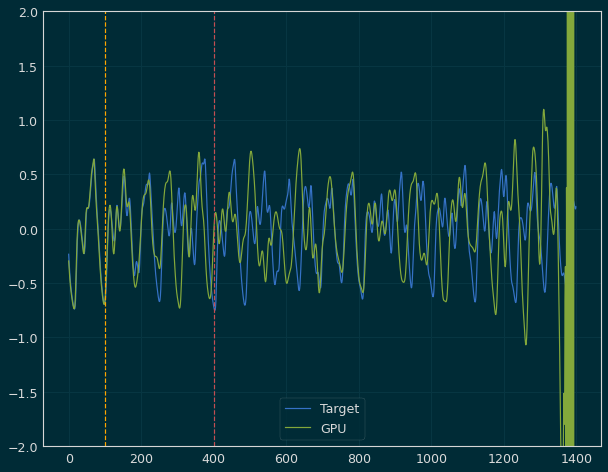

 Iter=13 a=0.643 sr=4.119 amp=0.234  ri=0.505 rr=3.252 loss=0.646571


Iter: 13 #### Diagnostic 0.647   Time 18.21  Best 0.647 NRMSE 0.200 CD 0.447
Iter: 14 #### Diagnostic 0.985   Time 15.98  Best 0.647 NRMSE 0.200 CD 0.785
Iter: 15 #### Diagnostic 1.171   Time 20.54  Best 0.647 NRMSE 0.234 CD 0.936
Iter: 16 #### Diagnostic 1000.000   Time 18.27  Best 0.647 NRMSE 5570826167061892300800.000 CD 1.000
Iter: 17 #### Diagnostic 1.282   Time 20.91  Best 0.647 NRMSE 0.232 CD 1.050
Iter: 18 #### Diagnostic 1000.000   Time 20.93  Best 0.647 NRMSE 1000.000 CD nan
Iter: 19 #### Diagnostic 1000.000   Time 16.77  Best 0.647 NRMSE 1000.000 CD nan
Iter: 20 #### Diagnostic 1.097   Time 18.38  Best 0.647 NRMSE 0.202 CD 0.895
Iter: 21 #### Diagnostic 1000.000   Time 21.65  Best 0.647 NRMSE 1000.000 CD nan
Iter: 22 #### Diagnostic 1.047   Time 18.55  Best 0.647 NRMSE 0.202 CD 0.845
Iter: 23 #### Diagnostic 1000.000   Time 17.12  Best 0.647 NRMSE 1000.000 CD nan
Iter: 24 #### Diagnostic 1000.000   Time 2

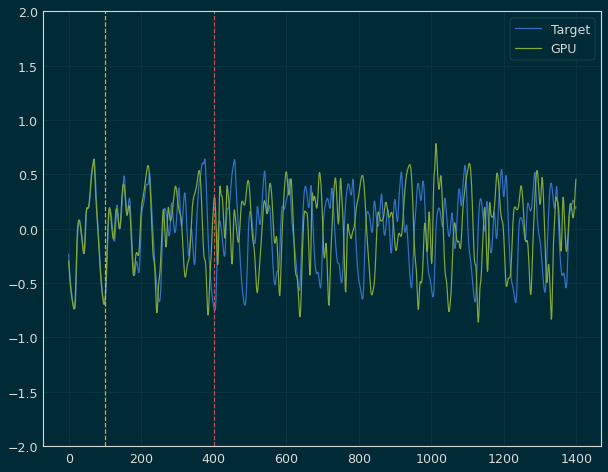

 Iter=62 a=0.706 sr=5.607 amp=0.238  ri=0.418 rr=0.894 loss=0.633407


Iter: 62 #### Diagnostic 0.633   Time 20.69  Best 0.633 NRMSE 0.188 CD 0.445
Iter: 63 #### Diagnostic 1.525   Time 15.85  Best 0.633 NRMSE 0.280 CD 1.245
Iter: 64 #### Diagnostic 1000.000   Time 18.61  Best 0.633 NRMSE 1000.000 CD nan
Iter: 65 #### Diagnostic 1000.000   Time 18.40  Best 0.633 NRMSE 1000.000 CD nan
Iter: 66 #### Diagnostic 1000.000   Time 23.61  Best 0.633 NRMSE 1000.000 CD nan
Iter: 67 #### Diagnostic 1000.000   Time 20.61  Best 0.633 NRMSE 1000.000 CD nan
Iter: 68 #### Diagnostic 1000.000   Time 18.97  Best 0.633 NRMSE 95557876.435 CD 1.181
Iter: 69 #### Diagnostic 1.250   Time 17.17  Best 0.633 NRMSE 0.238 CD 1.012
Iter: 70 #### Diagnostic 1000.000   Time 14.47  Best 0.633 NRMSE 1000.000 CD nan
Iter: 71 #### Diagnostic 1000.000   Time 13.58  Best 0.633 NRMSE 1000.000 CD nan
Iter: 72 #### Diagnostic 0.886   Time 21.93  Best 0.633 NRMSE 0.231 CD 0.655
Iter: 73 #### Diagnostic 1000.000   Time 16.81  

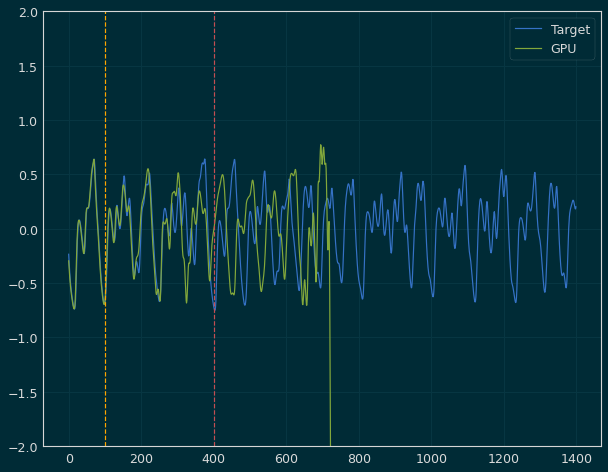

 Iter=98 a=0.515 sr=7.864 amp=0.185  ri=0.612 rr=2.905 loss=0.402192


Iter: 98 #### Diagnostic 0.402   Time 21.23  Best 0.402 NRMSE 0.141 CD 0.261
Iter: 99 #### Diagnostic 1000.000   Time 17.58  Best 0.402 NRMSE 1000.000 CD nan

Best result = 0.402192333904745
a = 0.5152334579154145
sr = 7.863670612092308
amp = 0.18453003659579334
ri = 0.6123976126380598
rr = 2.9052400059584182

 ********** 1000 ***********
Iter: 0 #### Diagnostic 1000.000   Time 19.02  Best 1000.000 NRMSE 511756190.722 CD 1.250
Iter: 1 #### Diagnostic 1.572   Time 21.41  Best 1000.000 NRMSE 0.313 CD 1.258
Iter: 2 #### Diagnostic 1.562   Time 14.88  Best 1000.000 NRMSE 0.322 CD 1.240
Iter: 3 #### Diagnostic 1000.000   Time 20.23  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 4 #### Diagnostic 1000.000   Time 17.60  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 5 #### Diagnostic 1000.000   Time 19.24  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 6 #### Diagnostic 1000.000   Time 21.00  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 7 

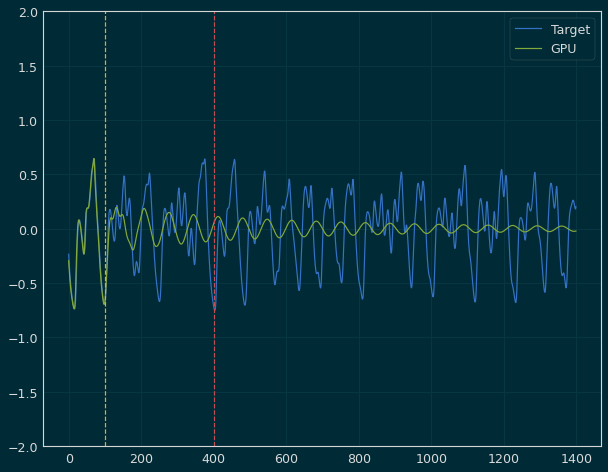

 Iter=21 a=0.470 sr=4.021 amp=0.173  ri=0.299 rr=1.345 loss=0.886473


Iter: 21 #### Diagnostic 0.886   Time 15.70  Best 0.886 NRMSE 0.191 CD 0.695
Iter: 22 #### Diagnostic 1000.000   Time 16.56  Best 0.886 NRMSE 1000.000 CD nan
Iter: 23 #### Diagnostic 1.227   Time 21.18  Best 0.886 NRMSE 0.243 CD 0.984
Iter: 24 #### Diagnostic 1000.000   Time 18.91  Best 0.886 NRMSE 1000.000 CD nan


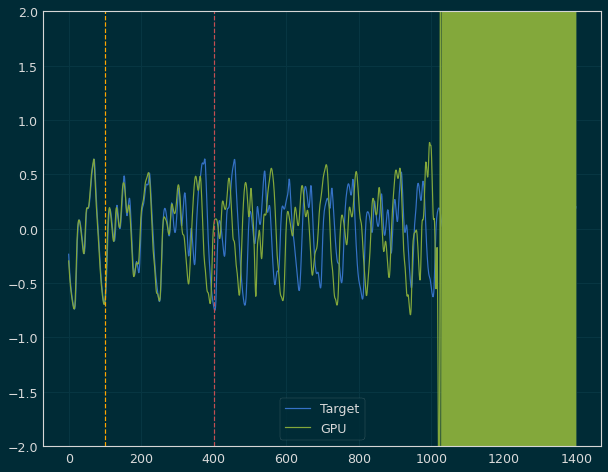

 Iter=25 a=0.995 sr=2.846 amp=0.548  ri=0.492 rr=0.649 loss=0.501498


Iter: 25 #### Diagnostic 0.501   Time 17.01  Best 0.501 NRMSE 0.166 CD 0.336
Iter: 26 #### Diagnostic 0.676   Time 19.03  Best 0.501 NRMSE 0.187 CD 0.489
Iter: 27 #### Diagnostic 1000.000   Time 18.79  Best 0.501 NRMSE 1000.000 CD nan
Iter: 28 #### Diagnostic 1000.000   Time 19.38  Best 0.501 NRMSE 1000.000 CD nan
Iter: 29 #### Diagnostic 1.161   Time 20.25  Best 0.501 NRMSE 0.209 CD 0.953
Iter: 30 #### Diagnostic 1000.000   Time 20.42  Best 0.501 NRMSE 1000.000 CD nan
Iter: 31 #### Diagnostic 1000.000   Time 17.69  Best 0.501 NRMSE 1000.000 CD nan
Iter: 32 #### Diagnostic 0.981   Time 16.69  Best 0.501 NRMSE 0.197 CD 0.784
Iter: 33 #### Diagnostic 0.937   Time 14.97  Best 0.501 NRMSE 0.192 CD 0.744


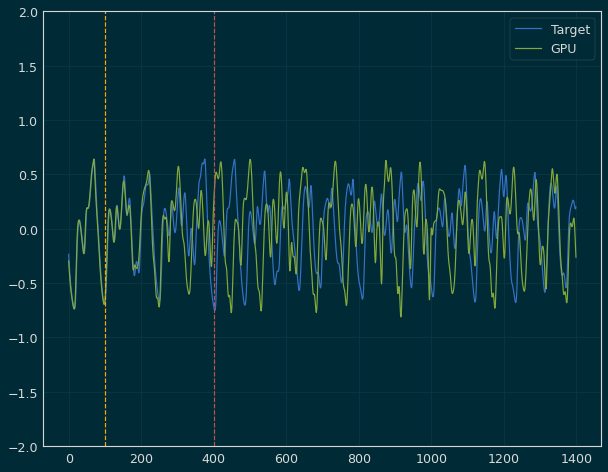

 Iter=34 a=0.720 sr=4.820 amp=0.232  ri=0.444 rr=3.216 loss=0.466354


Iter: 34 #### Diagnostic 0.466   Time 20.18  Best 0.466 NRMSE 0.155 CD 0.312
Iter: 35 #### Diagnostic 1000.000   Time 15.12  Best 0.466 NRMSE 1000.000 CD nan
Iter: 36 #### Diagnostic 1000.000   Time 19.09  Best 0.466 NRMSE 1000.000 CD nan
Iter: 37 #### Diagnostic 0.617   Time 14.85  Best 0.466 NRMSE 0.173 CD 0.444
Iter: 38 #### Diagnostic 1000.000   Time 19.16  Best 0.466 NRMSE 1000.000 CD nan
Iter: 39 #### Diagnostic 1000.000   Time 17.90  Best 0.466 NRMSE 1000.000 CD nan
Iter: 40 #### Diagnostic 0.497   Time 18.22  Best 0.466 NRMSE 0.151 CD 0.346
Iter: 41 #### Diagnostic 1000.000   Time 21.20  Best 0.466 NRMSE 1000.000 CD nan
Iter: 42 #### Diagnostic 1000.000   Time 16.78  Best 0.466 NRMSE 1000.000 CD nan
Iter: 43 #### Diagnostic 1.540   Time 19.50  Best 0.466 NRMSE 0.315 CD 1.226
Iter: 44 #### Diagnostic 0.982   Time 21.68  Best 0.466 NRMSE 0.195 CD 0.787
Iter: 45 #### Diagnostic 2.590   Time 12.65  Best 0.466 NR

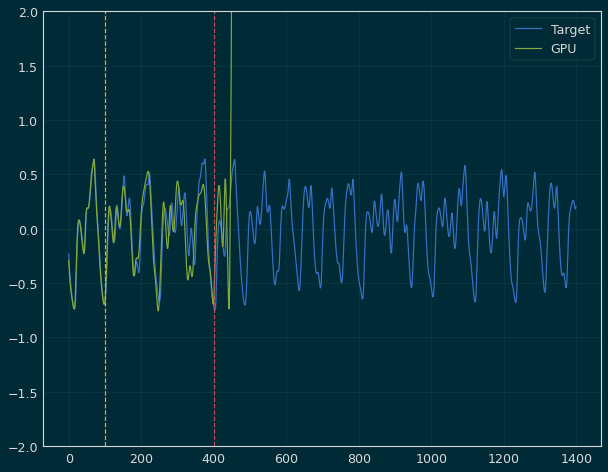

 Iter=97 a=0.456 sr=3.176 amp=0.325  ri=0.475 rr=4.335 loss=0.231621


Iter: 97 #### Diagnostic 0.232   Time 17.61  Best 0.232 NRMSE 0.101 CD 0.130
Iter: 98 #### Diagnostic 1000.000   Time 17.67  Best 0.232 NRMSE 1000.000 CD nan
Iter: 99 #### Diagnostic 1000.000   Time 16.45  Best 0.232 NRMSE 1000.000 CD nan

Best result = 0.231620994853864
a = 0.4564743938461775
sr = 3.175800413434468
amp = 0.32451025744591405
ri = 0.47548188660427276
rr = 4.335174181102914

 ********** 1000 ***********
Iter: 0 #### Diagnostic 0.996   Time 14.66  Best 1000.000 NRMSE 0.196 CD 0.800
Iter: 1 #### Diagnostic 1000.000   Time 19.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 2 #### Diagnostic 1000.000   Time 21.04  Best 1000.000 NRMSE 66545511.741 CD 0.860
Iter: 3 #### Diagnostic 1000.000   Time 16.07  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 4 #### Diagnostic 1000.000   Time 18.74  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 5 #### Diagnostic 1000.000   Time 20.50  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 6

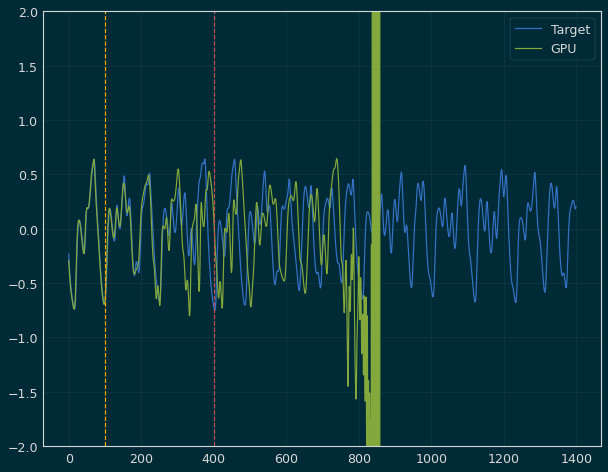

 Iter=9 a=0.613 sr=6.585 amp=0.165  ri=0.637 rr=4.248 loss=0.700374


Iter: 9 #### Diagnostic 0.700   Time 22.47  Best 0.700 NRMSE 0.203 CD 0.497
Iter: 10 #### Diagnostic 1.533   Time 21.73  Best 0.700 NRMSE 0.287 CD 1.246
Iter: 11 #### Diagnostic 1000.000   Time 20.89  Best 0.700 NRMSE 1000.000 CD nan
Iter: 12 #### Diagnostic 1000.000   Time 19.72  Best 0.700 NRMSE 1000.000 CD nan
Iter: 13 #### Diagnostic 1000.000   Time 14.95  Best 0.700 NRMSE 1000.000 CD nan
Iter: 14 #### Diagnostic 1000.000   Time 18.87  Best 0.700 NRMSE 1000.000 CD nan
Iter: 15 #### Diagnostic 1000.000   Time 19.48  Best 0.700 NRMSE 1000.000 CD nan
Iter: 16 #### Diagnostic 1000.000   Time 23.77  Best 0.700 NRMSE 1000.000 CD nan
Iter: 17 #### Diagnostic 1000.000   Time 13.21  Best 0.700 NRMSE 1000.000 CD nan
Iter: 18 #### Diagnostic 1.233   Time 16.56  Best 0.700 NRMSE 0.224 CD 1.009
Iter: 19 #### Diagnostic 1000.000   Time 14.78  Best 0.700 NRMSE 1000.000 CD nan
Iter: 20 #### Diagnostic 1.475   Time 21.17  Best 0.

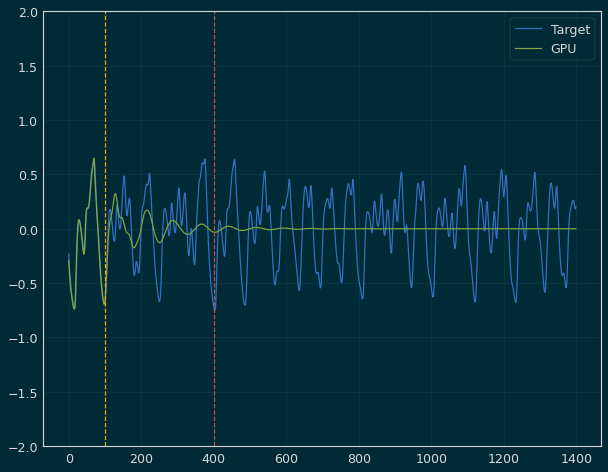

 Iter=49 a=0.451 sr=2.684 amp=0.287  ri=0.094 rr=0.604 loss=0.630939


Iter: 49 #### Diagnostic 0.631   Time 18.30  Best 0.631 NRMSE 0.170 CD 0.461
Iter: 50 #### Diagnostic 1.001   Time 19.19  Best 0.631 NRMSE 0.215 CD 0.786
Iter: 51 #### Diagnostic 1000.000   Time 16.76  Best 0.631 NRMSE 1000.000 CD nan
Iter: 52 #### Diagnostic 1000.000   Time 19.00  Best 0.631 NRMSE 1000.000 CD nan
Iter: 53 #### Diagnostic 1000.000   Time 20.52  Best 0.631 NRMSE 1000.000 CD nan
Iter: 54 #### Diagnostic 1000.000   Time 18.97  Best 0.631 NRMSE 343524752471069249051442779521024.000 CD 1.000
Iter: 55 #### Diagnostic 1.688   Time 14.24  Best 0.631 NRMSE 0.359 CD 1.329
Iter: 56 #### Diagnostic 0.983   Time 14.59  Best 0.631 NRMSE 0.195 CD 0.788
Iter: 57 #### Diagnostic 1.062   Time 16.35  Best 0.631 NRMSE 0.201 CD 0.861
Iter: 58 #### Diagnostic 1000.000   Time 17.73  Best 0.631 NRMSE 1000.000 CD nan
Iter: 59 #### Diagnostic 1000.000   Time 19.09  Best 0.631 NRMSE 1000.000 CD nan
Iter: 60 #### Diagnostic 0.

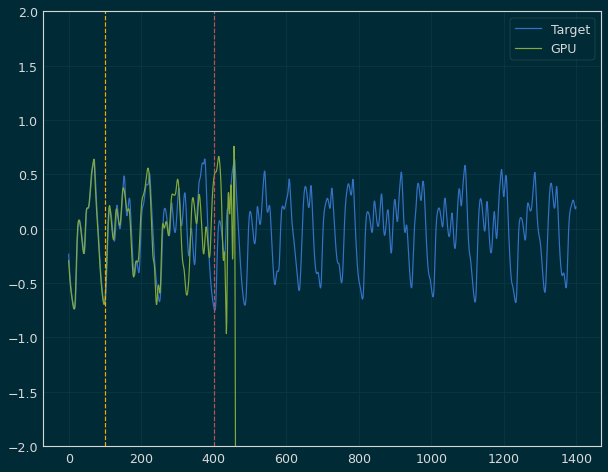

 Iter=99 a=0.341 sr=4.526 amp=0.242  ri=0.730 rr=2.020 loss=0.621873


Iter: 99 #### Diagnostic 0.622   Time 19.59  Best 0.622 NRMSE 0.182 CD 0.440

Best result = 0.6218729619818922
a = 0.34139770192742347
sr = 4.525667121349972
amp = 0.24153971876121433
ri = 0.7304256793038989
rr = 2.019688759295147

 ********** 1000 ***********
Iter: 0 #### Diagnostic 1000.000   Time 13.74  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 1 #### Diagnostic 1000.000   Time 16.83  Best 1000.000 NRMSE 1000.000 CD nan


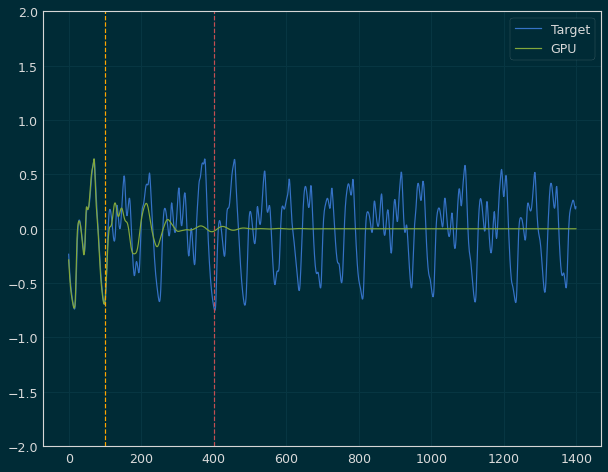

 Iter=2 a=0.197 sr=3.681 amp=0.102  ri=0.338 rr=2.310 loss=0.583551


Iter: 2 #### Diagnostic 0.584   Time 17.67  Best 0.584 NRMSE 0.165 CD 0.418
Iter: 3 #### Diagnostic 1000.000   Time 19.23  Best 0.584 NRMSE 1000.000 CD nan
Iter: 4 #### Diagnostic 1000.000   Time 17.28  Best 0.584 NRMSE 1000.000 CD nan
Iter: 5 #### Diagnostic 1000.000   Time 21.62  Best 0.584 NRMSE 1000.000 CD nan
Iter: 6 #### Diagnostic 1.464   Time 13.72  Best 0.584 NRMSE 0.329 CD 1.134
Iter: 7 #### Diagnostic 1000.000   Time 20.80  Best 0.584 NRMSE 1000.000 CD nan
Iter: 8 #### Diagnostic 0.885   Time 16.13  Best 0.584 NRMSE 0.210 CD 0.675
Iter: 9 #### Diagnostic 1000.000   Time 20.96  Best 0.584 NRMSE 1000.000 CD nan
Iter: 10 #### Diagnostic 1000.000   Time 15.60  Best 0.584 NRMSE 1000.000 CD nan
Iter: 11 #### Diagnostic 1.149   Time 17.62  Best 0.584 NRMSE 0.241 CD 0.908
Iter: 12 #### Diagnostic 1000.000   Time 20.01  Best 0.584 NRMSE 1000.000 CD nan
Iter: 13 #### Diagnostic 1000.000   Time 17.38  Best 0.584 NRMS

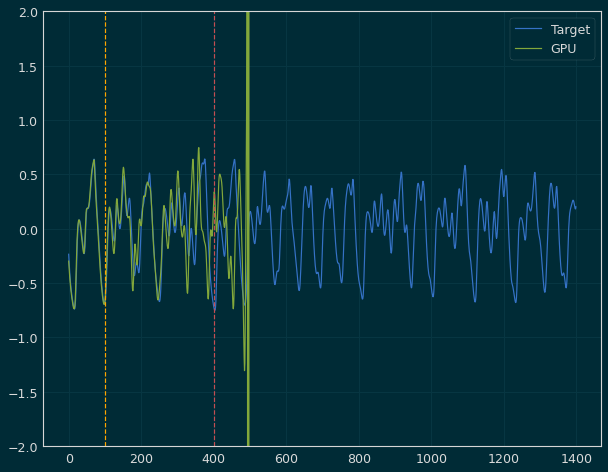

 Iter=21 a=0.201 sr=1.706 amp=0.786  ri=0.678 rr=1.170 loss=0.583092


Iter: 21 #### Diagnostic 0.583   Time 14.12  Best 0.583 NRMSE 0.177 CD 0.406
Iter: 22 #### Diagnostic 1000.000   Time 18.07  Best 0.583 NRMSE 1000.000 CD nan
Iter: 23 #### Diagnostic 1.139   Time 16.46  Best 0.583 NRMSE 0.206 CD 0.933
Iter: 24 #### Diagnostic 1000.000   Time 21.30  Best 0.583 NRMSE 1000.000 CD nan
Iter: 25 #### Diagnostic 1000.000   Time 18.94  Best 0.583 NRMSE 1000.000 CD nan
Iter: 26 #### Diagnostic 1000.000   Time 19.41  Best 0.583 NRMSE 1000.000 CD nan
Iter: 27 #### Diagnostic 1000.000   Time 21.71  Best 0.583 NRMSE 1000.000 CD nan
Iter: 28 #### Diagnostic 0.875   Time 17.73  Best 0.583 NRMSE 0.228 CD 0.648
Iter: 29 #### Diagnostic 1000.000   Time 16.31  Best 0.583 NRMSE 1000.000 CD nan
Iter: 30 #### Diagnostic 0.908   Time 21.77  Best 0.583 NRMSE 0.191 CD 0.717
Iter: 31 #### Diagnostic 1000.000   Time 20.32  Best 0.583 NRMSE 1000.000 CD nan
Iter: 32 #### Diagnostic 1000.000   Time 19.10  Best 0

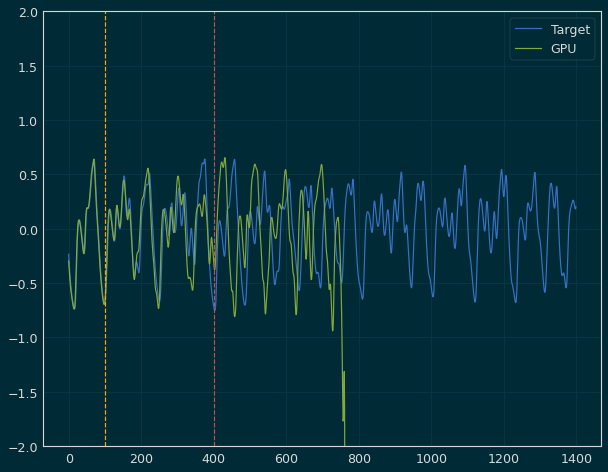

 Iter=41 a=0.901 sr=5.528 amp=0.289  ri=0.666 rr=1.418 loss=0.311689


Iter: 41 #### Diagnostic 0.312   Time 19.02  Best 0.312 NRMSE 0.120 CD 0.191
Iter: 42 #### Diagnostic 1.481   Time 20.21  Best 0.312 NRMSE 0.299 CD 1.183
Iter: 43 #### Diagnostic 1000.000   Time 22.16  Best 0.312 NRMSE 1000.000 CD nan
Iter: 44 #### Diagnostic 1.001   Time 18.00  Best 0.312 NRMSE 0.197 CD 0.805
Iter: 45 #### Diagnostic 1.094   Time 15.95  Best 0.312 NRMSE 0.214 CD 0.880
Iter: 46 #### Diagnostic 1.346   Time 21.41  Best 0.312 NRMSE 0.232 CD 1.113
Iter: 47 #### Diagnostic 1.069   Time 15.19  Best 0.312 NRMSE 0.202 CD 0.867
Iter: 48 #### Diagnostic 1000.000   Time 17.54  Best 0.312 NRMSE 1000.000 CD nan
Iter: 49 #### Diagnostic 1.460   Time 17.72  Best 0.312 NRMSE 0.266 CD 1.194
Iter: 50 #### Diagnostic 1.365   Time 18.49  Best 0.312 NRMSE 0.322 CD 1.043
Iter: 51 #### Diagnostic 1.491   Time 20.36  Best 0.312 NRMSE 0.296 CD 1.196
Iter: 52 #### Diagnostic 13.433   Time 18.61  Best 0.312 NRMSE 12.596 CD 0

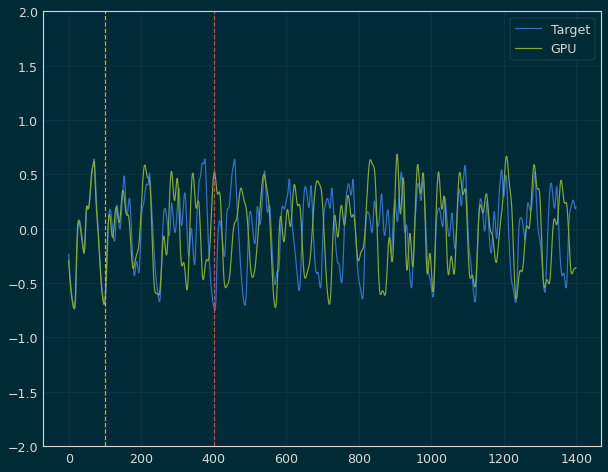

 Iter=0 a=0.069 sr=5.318 amp=0.195  ri=0.926 rr=0.527 loss=0.866173


Iter: 0 #### Diagnostic 0.866   Time 17.04  Best 0.866 NRMSE 0.229 CD 0.637
Iter: 1 #### Diagnostic 1000.000   Time 15.82  Best 0.866 NRMSE 1000.000 CD nan
Iter: 2 #### Diagnostic 1000.000   Time 16.04  Best 0.866 NRMSE 1000.000 CD nan
Iter: 3 #### Diagnostic 1000.000   Time 19.88  Best 0.866 NRMSE 1000.000 CD nan
Iter: 4 #### Diagnostic 1.199   Time 17.86  Best 0.866 NRMSE 0.216 CD 0.984
Iter: 5 #### Diagnostic 1000.000   Time 17.03  Best 0.866 NRMSE 1000.000 CD nan
Iter: 6 #### Diagnostic 1000.000   Time 18.04  Best 0.866 NRMSE 1000.000 CD nan
Iter: 7 #### Diagnostic 1000.000   Time 15.20  Best 0.866 NRMSE 1000.000 CD nan


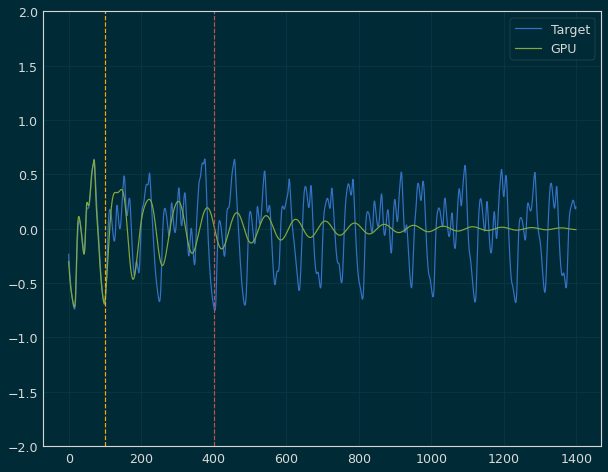

 Iter=8 a=0.044 sr=1.570 amp=0.477  ri=0.038 rr=0.031 loss=0.672130


Iter: 8 #### Diagnostic 0.672   Time 17.62  Best 0.672 NRMSE 0.178 CD 0.494
Iter: 9 #### Diagnostic 74.344   Time 16.46  Best 0.672 NRMSE 73.456 CD 0.888
Iter: 10 #### Diagnostic 1.119   Time 15.13  Best 0.672 NRMSE 0.260 CD 0.860
Iter: 11 #### Diagnostic 1000.000   Time 14.27  Best 0.672 NRMSE 1000.000 CD nan
Iter: 12 #### Diagnostic 1000.000   Time 14.47  Best 0.672 NRMSE 1000.000 CD nan
Iter: 13 #### Diagnostic 0.964   Time 19.80  Best 0.672 NRMSE 0.200 CD 0.764
Iter: 14 #### Diagnostic 1000.000   Time 15.43  Best 0.672 NRMSE 1000.000 CD nan


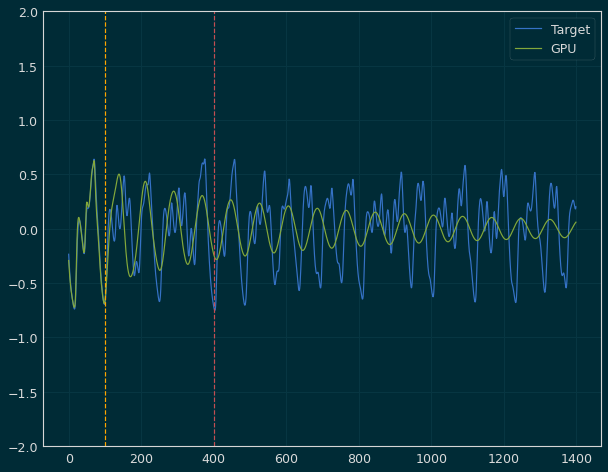

 Iter=15 a=0.090 sr=2.324 amp=0.111  ri=0.140 rr=3.057 loss=0.621465


Iter: 15 #### Diagnostic 0.621   Time 18.34  Best 0.621 NRMSE 0.178 CD 0.444
Iter: 16 #### Diagnostic 1000.000   Time 16.84  Best 0.621 NRMSE 1000.000 CD nan
Iter: 17 #### Diagnostic 1000.000   Time 16.06  Best 0.621 NRMSE 1000.000 CD nan
Iter: 18 #### Diagnostic 0.643   Time 14.05  Best 0.621 NRMSE 0.174 CD 0.469
Iter: 19 #### Diagnostic 0.943   Time 19.49  Best 0.621 NRMSE 0.193 CD 0.750
Iter: 20 #### Diagnostic 1000.000   Time 18.48  Best 0.621 NRMSE 1000.000 CD nan
Iter: 21 #### Diagnostic 0.781   Time 20.68  Best 0.621 NRMSE 0.185 CD 0.596
Iter: 22 #### Diagnostic 1000.000   Time 12.52  Best 0.621 NRMSE 1000.000 CD nan
Iter: 23 #### Diagnostic 1000.000   Time 16.24  Best 0.621 NRMSE 1000.000 CD nan
Iter: 24 #### Diagnostic 1000.000   Time 20.64  Best 0.621 NRMSE 1000.000 CD nan
Iter: 25 #### Diagnostic 1000.000   Time 17.33  Best 0.621 NRMSE 1000.000 CD nan
Iter: 26 #### Diagnostic 1000.000   Time 22.62  Best 0

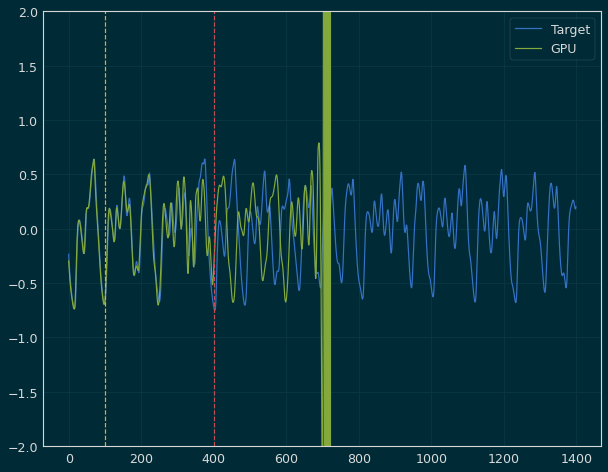

 Iter=38 a=0.607 sr=1.415 amp=0.921  ri=0.342 rr=1.015 loss=0.216701


Iter: 38 #### Diagnostic 0.217   Time 18.62  Best 0.217 NRMSE 0.095 CD 0.121
Iter: 39 #### Diagnostic 1000.000   Time 20.68  Best 0.217 NRMSE 14224056630637776.000 CD 1.203
Iter: 40 #### Diagnostic 1.030   Time 12.73  Best 0.217 NRMSE 0.199 CD 0.832
Iter: 41 #### Diagnostic 1.276   Time 13.03  Best 0.217 NRMSE 0.226 CD 1.050
Iter: 42 #### Diagnostic 1.375   Time 19.54  Best 0.217 NRMSE 0.324 CD 1.051
Iter: 43 #### Diagnostic 0.823   Time 20.78  Best 0.217 NRMSE 0.207 CD 0.616
Iter: 44 #### Diagnostic 1000.000   Time 17.44  Best 0.217 NRMSE 1000.000 CD nan
Iter: 45 #### Diagnostic 1000.000   Time 16.96  Best 0.217 NRMSE 1000.000 CD nan
Iter: 46 #### Diagnostic 1000.000   Time 18.49  Best 0.217 NRMSE 1000.000 CD nan
Iter: 47 #### Diagnostic 1000.000   Time 19.82  Best 0.217 NRMSE 1000.000 CD nan
Iter: 48 #### Diagnostic 1000.000   Time 17.90  Best 0.217 NRMSE 1000.000 CD nan
Iter: 49 #### Diagnostic 1000.000   Time 19

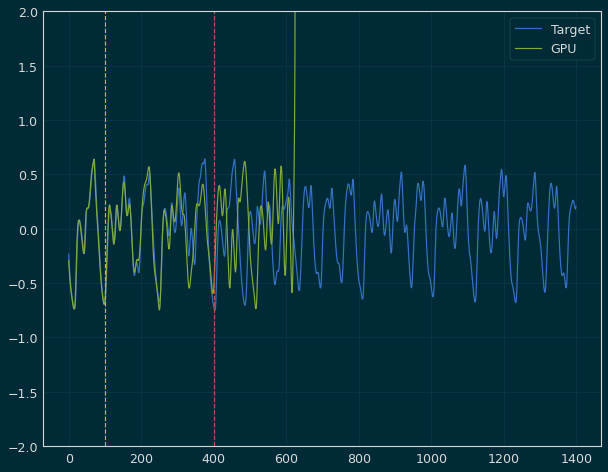

 Iter=80 a=0.452 sr=7.505 amp=0.135  ri=0.826 rr=1.886 loss=0.199120


Iter: 80 #### Diagnostic 0.199   Time 18.43  Best 0.199 NRMSE 0.092 CD 0.107
Iter: 81 #### Diagnostic 1000.000   Time 19.43  Best 0.199 NRMSE 1000.000 CD nan
Iter: 82 #### Diagnostic 1000.000   Time 15.67  Best 0.199 NRMSE 1000.000 CD nan
Iter: 83 #### Diagnostic 1.417   Time 21.60  Best 0.199 NRMSE 0.251 CD 1.166
Iter: 84 #### Diagnostic 1000.000   Time 16.20  Best 0.199 NRMSE 1000.000 CD nan
Iter: 85 #### Diagnostic 1000.000   Time 13.76  Best 0.199 NRMSE 21923704137952449699959013376.000 CD 1.000
Iter: 86 #### Diagnostic 1000.000   Time 18.64  Best 0.199 NRMSE 1000.000 CD nan
Iter: 87 #### Diagnostic 1000.000   Time 20.45  Best 0.199 NRMSE 1000.000 CD nan
Iter: 88 #### Diagnostic 1000.000   Time 19.09  Best 0.199 NRMSE 1000.000 CD nan
Iter: 89 #### Diagnostic 1000.000   Time 18.15  Best 0.199 NRMSE 1000.000 CD nan
Iter: 90 #### Diagnostic 1000.000   Time 19.19  Best 0.199 NRMSE 1000.000 CD nan
Iter: 91 #### Diagn

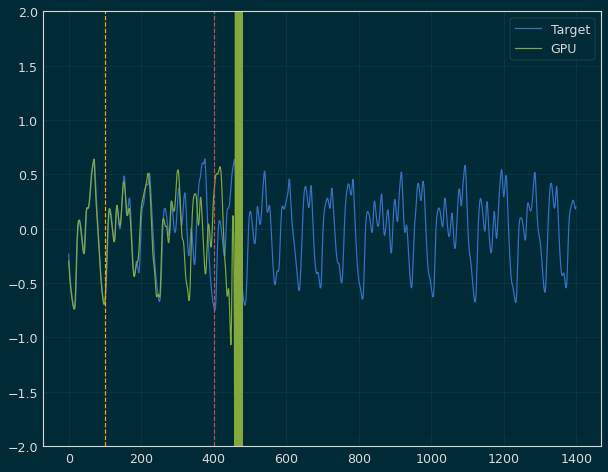

 Iter=21 a=0.574 sr=5.041 amp=0.317  ri=0.675 rr=3.569 loss=0.603889


Iter: 21 #### Diagnostic 0.604   Time 21.16  Best 0.604 NRMSE 0.179 CD 0.424
Iter: 22 #### Diagnostic 1.041   Time 16.46  Best 0.604 NRMSE 0.202 CD 0.839
Iter: 23 #### Diagnostic 1000.000   Time 18.46  Best 0.604 NRMSE 1000.000 CD nan
Iter: 24 #### Diagnostic 1000.000   Time 22.32  Best 0.604 NRMSE 1000.000 CD nan


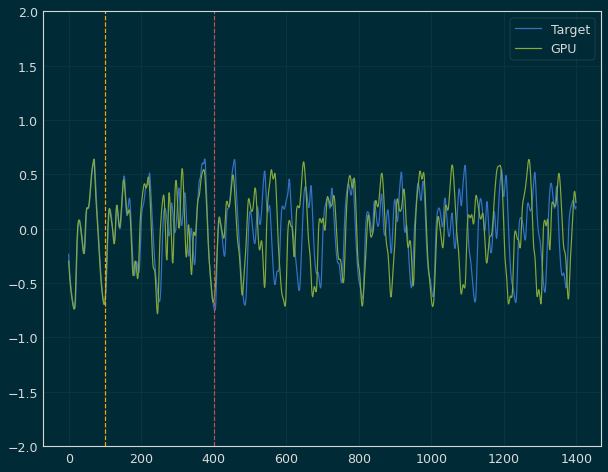

 Iter=25 a=0.712 sr=3.122 amp=0.537  ri=0.439 rr=0.095 loss=0.333334


Iter: 25 #### Diagnostic 0.333   Time 21.62  Best 0.333 NRMSE 0.128 CD 0.206
Iter: 26 #### Diagnostic 1000.000   Time 19.31  Best 0.333 NRMSE 1000.000 CD nan
Iter: 27 #### Diagnostic 1.417   Time 17.02  Best 0.333 NRMSE 0.266 CD 1.150
Iter: 28 #### Diagnostic 0.922   Time 15.44  Best 0.333 NRMSE 0.192 CD 0.730
Iter: 29 #### Diagnostic 1000.000   Time 21.25  Best 0.333 NRMSE 1000.000 CD nan
Iter: 30 #### Diagnostic 1000.000   Time 18.03  Best 0.333 NRMSE 1000.000 CD nan
Iter: 31 #### Diagnostic 1.347   Time 21.41  Best 0.333 NRMSE 0.301 CD 1.045
Iter: 32 #### Diagnostic 1.635   Time 14.81  Best 0.333 NRMSE 0.294 CD 1.340
Iter: 33 #### Diagnostic 1000.000   Time 21.74  Best 0.333 NRMSE 1000.000 CD nan
Iter: 34 #### Diagnostic 0.990   Time 21.57  Best 0.333 NRMSE 0.196 CD 0.794
Iter: 35 #### Diagnostic 1.112   Time 23.35  Best 0.333 NRMSE 0.205 CD 0.907
Iter: 36 #### Diagnostic 1000.000   Time 17.75  Best 0.333 NRMSE 1

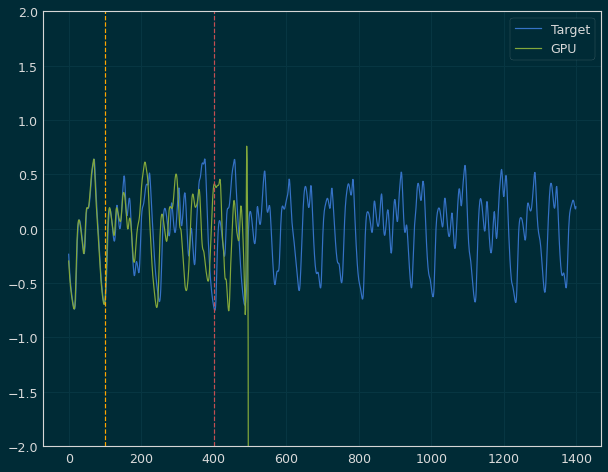

 Iter=5 a=0.818 sr=2.061 amp=0.893  ri=0.719 rr=0.104 loss=0.871060


Iter: 5 #### Diagnostic 0.871   Time 19.54  Best 0.871 NRMSE 0.224 CD 0.647
Iter: 6 #### Diagnostic 1000.000   Time 19.34  Best 0.871 NRMSE 1000.000 CD nan
Iter: 7 #### Diagnostic 1000.000   Time 17.70  Best 0.871 NRMSE 1000.000 CD nan
Iter: 8 #### Diagnostic 1000.000   Time 18.03  Best 0.871 NRMSE 1000.000 CD nan
Iter: 9 #### Diagnostic 1000.000   Time 20.92  Best 0.871 NRMSE 1000.000 CD nan
Iter: 10 #### Diagnostic 0.994   Time 21.05  Best 0.871 NRMSE 0.196 CD 0.798
Iter: 11 #### Diagnostic 1000.000   Time 17.50  Best 0.871 NRMSE 1000.000 CD nan
Iter: 12 #### Diagnostic 1000.000   Time 12.70  Best 0.871 NRMSE 1000.000 CD nan
Iter: 13 #### Diagnostic 1000.000   Time 22.25  Best 0.871 NRMSE 1000.000 CD nan
Iter: 14 #### Diagnostic 0.977   Time 15.92  Best 0.871 NRMSE 0.196 CD 0.780
Iter: 15 #### Diagnostic 0.977   Time 18.27  Best 0.871 NRMSE 0.195 CD 0.782
Iter: 16 #### Diagnostic 1.082   Time 14.61  Best 0.871 NRMS

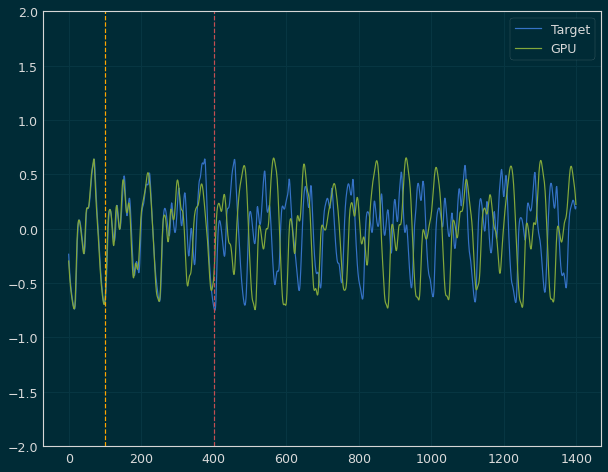

 Iter=25 a=0.995 sr=2.846 amp=0.548  ri=0.492 rr=0.649 loss=0.249537


Iter: 25 #### Diagnostic 0.250   Time 19.81  Best 0.250 NRMSE 0.106 CD 0.144


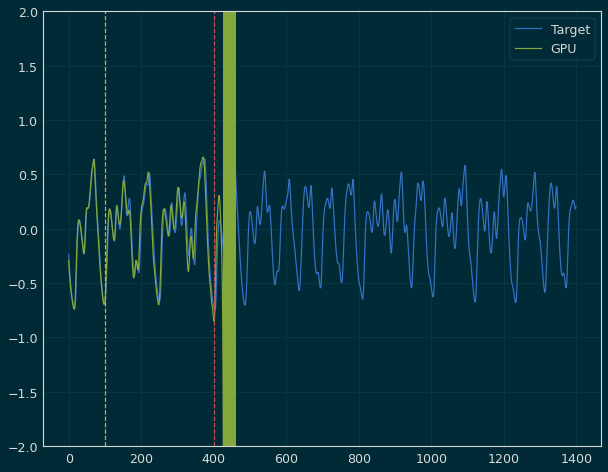

 Iter=26 a=0.860 sr=1.748 amp=0.825  ri=0.998 rr=4.956 loss=0.121752


Iter: 26 #### Diagnostic 0.122   Time 19.23  Best 0.122 NRMSE 0.067 CD 0.055
Iter: 27 #### Diagnostic 1000.000   Time 17.44  Best 0.122 NRMSE 1000.000 CD nan
Iter: 28 #### Diagnostic 1000.000   Time 18.20  Best 0.122 NRMSE 1000.000 CD nan
Iter: 29 #### Diagnostic 1.189   Time 20.57  Best 0.122 NRMSE 0.212 CD 0.977
Iter: 30 #### Diagnostic 1000.000   Time 16.84  Best 0.122 NRMSE 1000.000 CD nan
Iter: 31 #### Diagnostic 1000.000   Time 21.46  Best 0.122 NRMSE 1000.000 CD nan
Iter: 32 #### Diagnostic 0.995   Time 20.45  Best 0.122 NRMSE 0.198 CD 0.797
Iter: 33 #### Diagnostic 0.948   Time 17.46  Best 0.122 NRMSE 0.193 CD 0.755
Iter: 34 #### Diagnostic 0.400   Time 21.53  Best 0.122 NRMSE 0.140 CD 0.261
Iter: 35 #### Diagnostic 1000.000   Time 19.07  Best 0.122 NRMSE 1000.000 CD nan
Iter: 36 #### Diagnostic 1000.000   Time 19.79  Best 0.122 NRMSE 1000.000 CD nan
Iter: 37 #### Diagnostic 0.621   Time 13.28  Best 0.122 NR

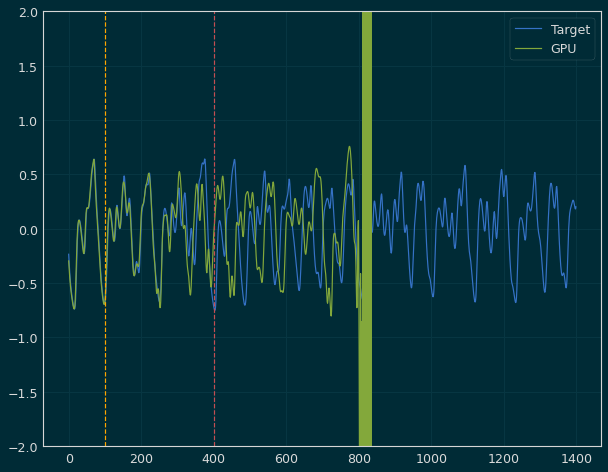

 Iter=9 a=0.613 sr=6.585 amp=0.165  ri=0.637 rr=4.248 loss=0.344933


Iter: 9 #### Diagnostic 0.345   Time 17.20  Best 0.345 NRMSE 0.129 CD 0.216
Iter: 10 #### Diagnostic 1.600   Time 18.57  Best 0.345 NRMSE 0.301 CD 1.299
Iter: 11 #### Diagnostic 1000.000   Time 18.33  Best 0.345 NRMSE 1000.000 CD nan
Iter: 12 #### Diagnostic 1000.000   Time 16.20  Best 0.345 NRMSE 1000.000 CD nan
Iter: 13 #### Diagnostic 1000.000   Time 15.03  Best 0.345 NRMSE 1000.000 CD nan
Iter: 14 #### Diagnostic 1000.000   Time 20.86  Best 0.345 NRMSE 1000.000 CD nan
Iter: 15 #### Diagnostic 1000.000   Time 19.13  Best 0.345 NRMSE 1000.000 CD nan
Iter: 16 #### Diagnostic 1000.000   Time 21.19  Best 0.345 NRMSE 1000.000 CD nan
Iter: 17 #### Diagnostic 1000.000   Time 17.45  Best 0.345 NRMSE 1000.000 CD nan
Iter: 18 #### Diagnostic 1.232   Time 18.86  Best 0.345 NRMSE 0.224 CD 1.008
Iter: 19 #### Diagnostic 1000.000   Time 19.27  Best 0.345 NRMSE 1000.000 CD nan
Iter: 20 #### Diagnostic 1.466   Time 18.92  Best 0.

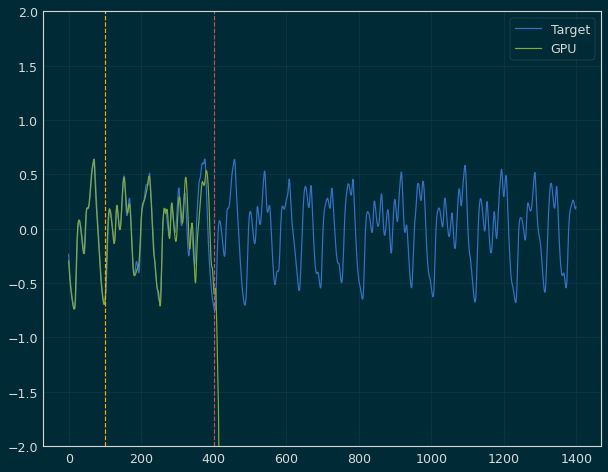

 Iter=26 a=0.520 sr=2.100 amp=0.658  ri=0.652 rr=2.583 loss=0.188620


Iter: 26 #### Diagnostic 0.189   Time 14.24  Best 0.189 NRMSE 0.088 CD 0.101
Iter: 27 #### Diagnostic 1000.000   Time 19.58  Best 0.189 NRMSE 1000.000 CD nan
Iter: 28 #### Diagnostic 1000.000   Time 17.90  Best 0.189 NRMSE 1000.000 CD nan
Iter: 29 #### Diagnostic 1.190   Time 13.27  Best 0.189 NRMSE 0.210 CD 0.981
Iter: 30 #### Diagnostic 1000.000   Time 17.92  Best 0.189 NRMSE 1000.000 CD nan
Iter: 31 #### Diagnostic 1000.000   Time 19.55  Best 0.189 NRMSE 1000.000 CD nan
Iter: 32 #### Diagnostic 0.852   Time 17.74  Best 0.189 NRMSE 0.189 CD 0.663
Iter: 33 #### Diagnostic 0.306   Time 21.11  Best 0.189 NRMSE 0.120 CD 0.186
Iter: 34 #### Diagnostic 1000.000   Time 16.11  Best 0.189 NRMSE 1000.000 CD nan
Iter: 35 #### Diagnostic 1.214   Time 17.32  Best 0.189 NRMSE 0.271 CD 0.943
Iter: 36 #### Diagnostic 1000.000   Time 16.44  Best 0.189 NRMSE 4025676026864245.000 CD 0.747
Iter: 37 #### Diagnostic 1.001   Time 16.39 

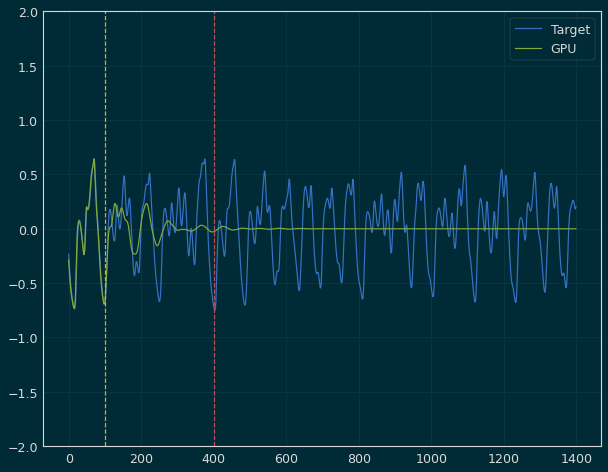

 Iter=2 a=0.197 sr=3.681 amp=0.102  ri=0.338 rr=2.310 loss=0.557906


Iter: 2 #### Diagnostic 0.558   Time 12.24  Best 0.558 NRMSE 0.163 CD 0.395
Iter: 3 #### Diagnostic 1000.000   Time 16.24  Best 0.558 NRMSE 1000.000 CD nan
Iter: 4 #### Diagnostic 0.632   Time 13.18  Best 0.558 NRMSE 0.178 CD 0.454
Iter: 5 #### Diagnostic 1000.000   Time 19.14  Best 0.558 NRMSE 1000.000 CD nan
Iter: 6 #### Diagnostic 0.757   Time 17.83  Best 0.558 NRMSE 0.213 CD 0.544
Iter: 7 #### Diagnostic 1000.000   Time 11.42  Best 0.558 NRMSE 1000.000 CD nan
Iter: 8 #### Diagnostic 0.908   Time 16.67  Best 0.558 NRMSE 0.213 CD 0.695
Iter: 9 #### Diagnostic 1000.000   Time 18.24  Best 0.558 NRMSE 1000.000 CD nan
Iter: 10 #### Diagnostic 1.100   Time 17.55  Best 0.558 NRMSE 0.403 CD 0.697
Iter: 11 #### Diagnostic 1.389   Time 18.28  Best 0.558 NRMSE 0.273 CD 1.116
Iter: 12 #### Diagnostic 1000.000   Time 14.99  Best 0.558 NRMSE 1000.000 CD nan
Iter: 13 #### Diagnostic 1000.000   Time 13.50  Best 0.558 NRMSE 1000.0

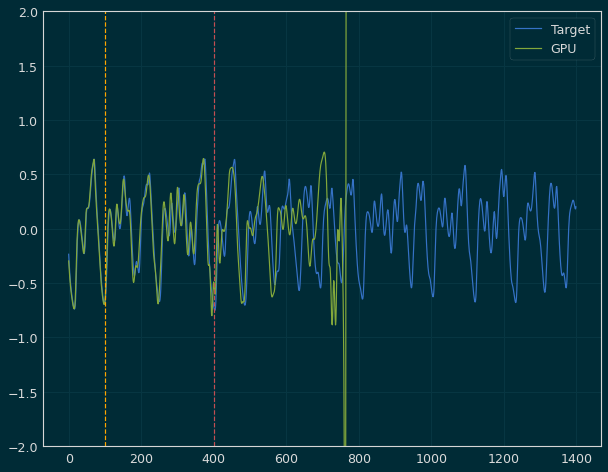

 Iter=72 a=0.297 sr=7.701 amp=0.191  ri=0.933 rr=0.717 loss=0.132095


Iter: 72 #### Diagnostic 0.132   Time 18.29  Best 0.132 NRMSE 0.070 CD 0.062
Iter: 73 #### Diagnostic 1.258   Time 19.30  Best 0.132 NRMSE 0.218 CD 1.040
Iter: 74 #### Diagnostic 0.690   Time 22.49  Best 0.132 NRMSE 0.197 CD 0.493
Iter: 75 #### Diagnostic 1000.000   Time 24.56  Best 0.132 NRMSE 1670.095 CD 1.074
Iter: 76 #### Diagnostic 1000.000   Time 12.45  Best 0.132 NRMSE 1000.000 CD nan
Iter: 77 #### Diagnostic 0.960   Time 16.94  Best 0.132 NRMSE 0.226 CD 0.734
Iter: 78 #### Diagnostic 1000.000   Time 19.08  Best 0.132 NRMSE 1000.000 CD nan
Iter: 79 #### Diagnostic 1000.000   Time 18.83  Best 0.132 NRMSE 1000.000 CD nan
Iter: 80 #### Diagnostic 1.042   Time 22.00  Best 0.132 NRMSE 0.201 CD 0.841
Iter: 81 #### Diagnostic 1000.000   Time 15.71  Best 0.132 NRMSE 1000.000 CD nan
Iter: 82 #### Diagnostic 1000.000   Time 16.48  Best 0.132 NRMSE 1000.000 CD nan
Iter: 83 #### Diagnostic 1000.000   Time 21.92  Best 0.1

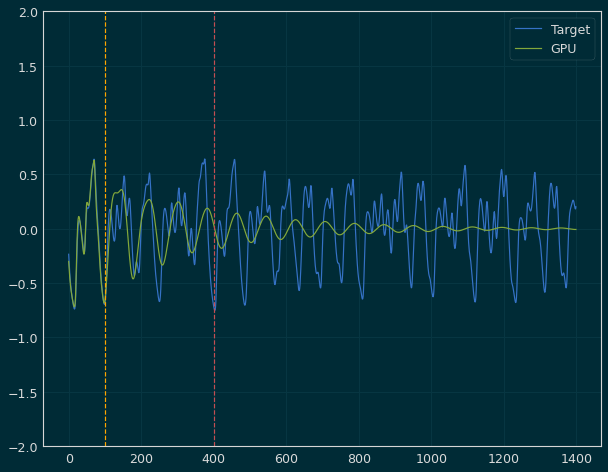

 Iter=8 a=0.044 sr=1.570 amp=0.477  ri=0.038 rr=0.031 loss=0.670730


Iter: 8 #### Diagnostic 0.671   Time 17.52  Best 0.671 NRMSE 0.178 CD 0.493
Iter: 9 #### Diagnostic 1000.000   Time 18.16  Best 0.671 NRMSE 1000.000 CD nan
Iter: 10 #### Diagnostic 1000.000   Time 14.65  Best 0.671 NRMSE 1000.000 CD nan
Iter: 11 #### Diagnostic 1000.000   Time 19.21  Best 0.671 NRMSE 1000.000 CD nan
Iter: 12 #### Diagnostic 1000.000   Time 20.09  Best 0.671 NRMSE 1000.000 CD nan
Iter: 13 #### Diagnostic 0.966   Time 19.06  Best 0.671 NRMSE 0.200 CD 0.765
Iter: 14 #### Diagnostic 1000.000   Time 16.44  Best 0.671 NRMSE 1000.000 CD nan


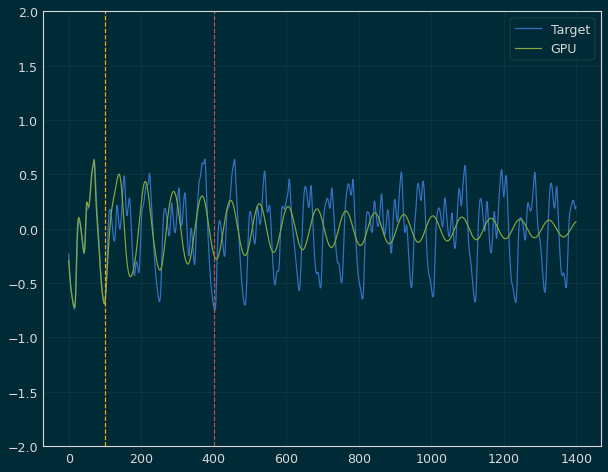

 Iter=15 a=0.090 sr=2.324 amp=0.111  ri=0.140 rr=3.057 loss=0.620335


Iter: 15 #### Diagnostic 0.620   Time 24.14  Best 0.620 NRMSE 0.177 CD 0.443
Iter: 16 #### Diagnostic 1000.000   Time 17.94  Best 0.620 NRMSE 1000.000 CD nan
Iter: 17 #### Diagnostic 1000.000   Time 20.23  Best 0.620 NRMSE 1000.000 CD nan
Iter: 18 #### Diagnostic 1.005   Time 19.48  Best 0.620 NRMSE 0.231 CD 0.774
Iter: 19 #### Diagnostic 0.943   Time 20.15  Best 0.620 NRMSE 0.193 CD 0.750
Iter: 20 #### Diagnostic 1000.000   Time 20.47  Best 0.620 NRMSE 1000.000 CD nan
Iter: 21 #### Diagnostic 0.837   Time 16.95  Best 0.620 NRMSE 0.190 CD 0.647
Iter: 22 #### Diagnostic 1000.000   Time 21.32  Best 0.620 NRMSE 1000.000 CD nan
Iter: 23 #### Diagnostic 1000.000   Time 16.94  Best 0.620 NRMSE 1000.000 CD nan


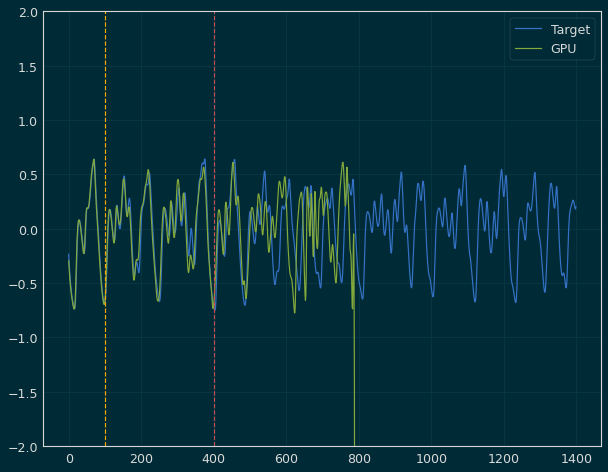

 Iter=24 a=0.890 sr=1.391 amp=0.942  ri=0.842 rr=0.772 loss=0.128094


Iter: 24 #### Diagnostic 0.128   Time 12.03  Best 0.128 NRMSE 0.069 CD 0.059
Iter: 25 #### Diagnostic 1000.000   Time 18.01  Best 0.128 NRMSE 1000.000 CD nan
Iter: 26 #### Diagnostic 1000.000   Time 23.44  Best 0.128 NRMSE 1000.000 CD nan
Iter: 27 #### Diagnostic 0.831   Time 14.55  Best 0.128 NRMSE 0.206 CD 0.626
Iter: 28 #### Diagnostic 0.616   Time 21.47  Best 0.128 NRMSE 0.181 CD 0.435
Iter: 29 #### Diagnostic 1.065   Time 14.30  Best 0.128 NRMSE 0.251 CD 0.814
Iter: 30 #### Diagnostic 0.855   Time 15.25  Best 0.128 NRMSE 0.194 CD 0.662
Iter: 31 #### Diagnostic 1000.000   Time 16.21  Best 0.128 NRMSE 1000.000 CD nan
Iter: 32 #### Diagnostic 1.312   Time 12.30  Best 0.128 NRMSE 0.287 CD 1.026
Iter: 33 #### Diagnostic 207.291   Time 20.44  Best 0.128 NRMSE 206.219 CD 1.072
Iter: 34 #### Diagnostic 1000.000   Time 20.05  Best 0.128 NRMSE 1000.000 CD nan
Iter: 35 #### Diagnostic 0.895   Time 15.84  Best 0.128 NRMSE 

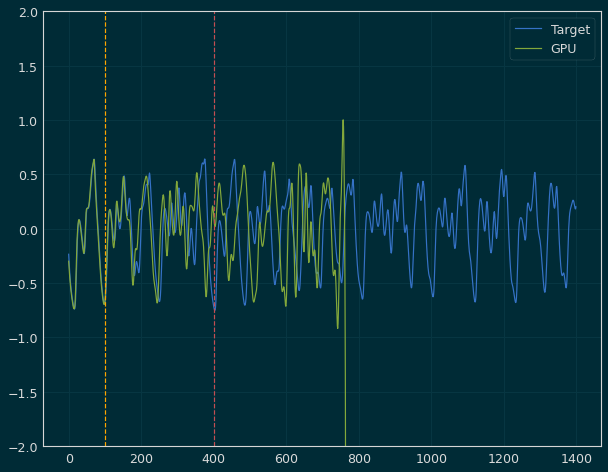

 Iter=4 a=0.240 sr=6.874 amp=0.203  ri=0.727 rr=1.822 loss=0.819166


Iter: 4 #### Diagnostic 0.819   Time 14.91  Best 0.819 NRMSE 0.209 CD 0.610
Iter: 5 #### Diagnostic 1000.000   Time 17.76  Best 0.819 NRMSE 1000.000 CD nan
Iter: 6 #### Diagnostic 1000.000   Time 17.02  Best 0.819 NRMSE 1000.000 CD nan
Iter: 7 #### Diagnostic 1.052   Time 22.03  Best 0.819 NRMSE 0.201 CD 0.851
Iter: 8 #### Diagnostic 0.948   Time 16.53  Best 0.819 NRMSE 0.201 CD 0.747
Iter: 9 #### Diagnostic 1000.000   Time 19.17  Best 0.819 NRMSE 1000.000 CD nan


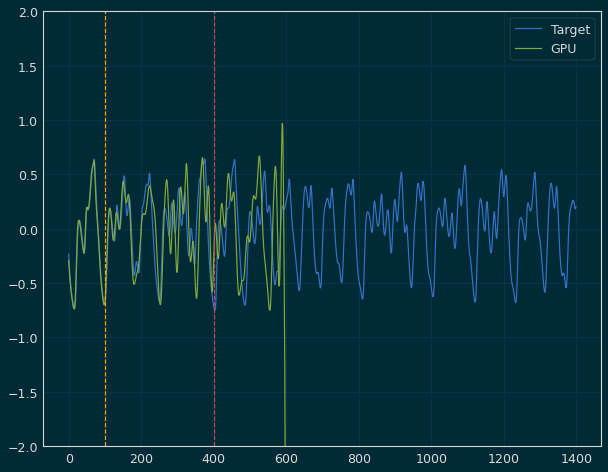

 Iter=10 a=0.087 sr=4.409 amp=0.286  ri=0.885 rr=3.294 loss=0.429180


Iter: 10 #### Diagnostic 0.429   Time 20.12  Best 0.429 NRMSE 0.150 CD 0.279
Iter: 11 #### Diagnostic 0.693   Time 15.95  Best 0.429 NRMSE 0.205 CD 0.488
Iter: 12 #### Diagnostic 1.321   Time 20.71  Best 0.429 NRMSE 0.238 CD 1.083
Iter: 13 #### Diagnostic 1.123   Time 15.57  Best 0.429 NRMSE 0.261 CD 0.862
Iter: 14 #### Diagnostic 0.993   Time 18.95  Best 0.429 NRMSE 0.204 CD 0.789
Iter: 15 #### Diagnostic 0.894   Time 15.77  Best 0.429 NRMSE 0.208 CD 0.686
Iter: 16 #### Diagnostic 1000.000   Time 21.00  Best 0.429 NRMSE 1000.000 CD nan
Iter: 17 #### Diagnostic 1.294   Time 19.04  Best 0.429 NRMSE 0.233 CD 1.061
Iter: 18 #### Diagnostic 1.244   Time 17.29  Best 0.429 NRMSE 0.273 CD 0.971
Iter: 19 #### Diagnostic 1000.000   Time 20.09  Best 0.429 NRMSE 1000.000 CD nan
Iter: 20 #### Diagnostic 1.094   Time 17.35  Best 0.429 NRMSE 0.202 CD 0.892
Iter: 21 #### Diagnostic 1000.000   Time 21.21  Best 0.429 NRMSE 1000.000 

Iter: 10 #### Diagnostic 0.960   Time 18.23  Best 1000.000 NRMSE 0.194 CD 0.765
Iter: 11 #### Diagnostic 1000.000   Time 15.74  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 12 #### Diagnostic 1000.000   Time 20.00  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 13 #### Diagnostic 1000.000   Time 21.07  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 14 #### Diagnostic 0.956   Time 17.88  Best 1000.000 NRMSE 0.194 CD 0.762
Iter: 15 #### Diagnostic 0.972   Time 14.18  Best 1000.000 NRMSE 0.194 CD 0.777
Iter: 16 #### Diagnostic 1.080   Time 21.84  Best 1000.000 NRMSE 0.201 CD 0.879
Iter: 17 #### Diagnostic 1000.000   Time 15.80  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 18 #### Diagnostic 1000.000   Time 14.41  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 19 #### Diagnostic 1000.000   Time 16.82  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 20 #### Diagnostic 1000.000   Time 19.12  Best 1000.000 NRMSE 1000.000 CD nan


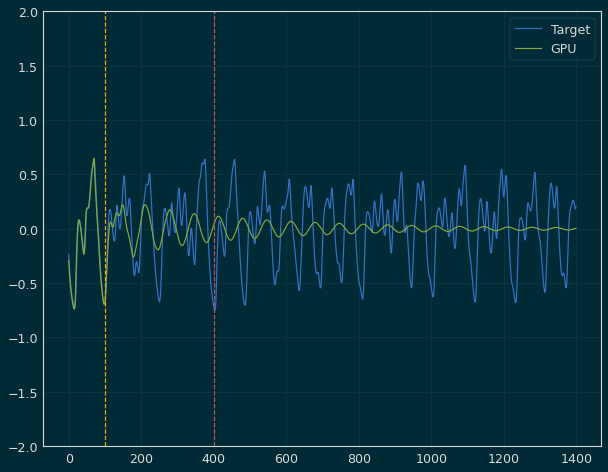

 Iter=21 a=0.470 sr=4.021 amp=0.173  ri=0.299 rr=1.345 loss=0.742935


Iter: 21 #### Diagnostic 0.743   Time 18.47  Best 0.743 NRMSE 0.179 CD 0.564
Iter: 22 #### Diagnostic 1000.000   Time 18.62  Best 0.743 NRMSE 1000.000 CD nan
Iter: 23 #### Diagnostic 1.181   Time 14.26  Best 0.743 NRMSE 0.239 CD 0.943
Iter: 24 #### Diagnostic 1000.000   Time 17.87  Best 0.743 NRMSE 1000.000 CD nan
Iter: 25 #### Diagnostic 1000.000   Time 17.65  Best 0.743 NRMSE 1000.000 CD nan
Iter: 26 #### Diagnostic 1000.000   Time 18.74  Best 0.743 NRMSE 1000.000 CD nan
Iter: 27 #### Diagnostic 1000.000   Time 21.22  Best 0.743 NRMSE 1000.000 CD nan
Iter: 28 #### Diagnostic 1000.000   Time 18.84  Best 0.743 NRMSE 1000.000 CD nan
Iter: 29 #### Diagnostic 1.102   Time 20.19  Best 0.743 NRMSE 0.204 CD 0.898
Iter: 30 #### Diagnostic 1000.000   Time 21.00  Best 0.743 NRMSE 1000.000 CD nan
Iter: 31 #### Diagnostic 1000.000   Time 19.44  Best 0.743 NRMSE 1000.000 CD nan
Iter: 32 #### Diagnostic 1.030   Time 18.47  Best 

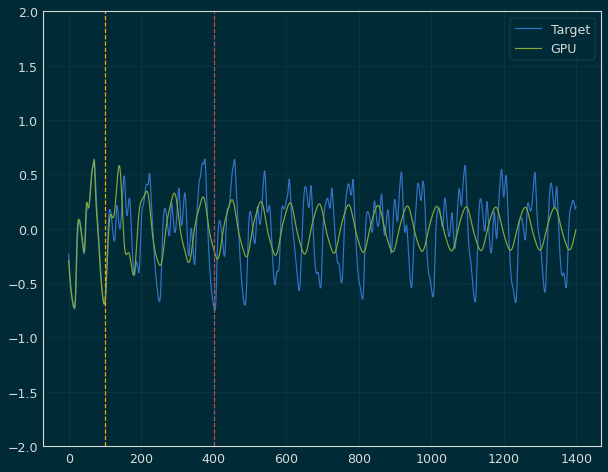

 Iter=37 a=0.140 sr=0.178 amp=0.223  ri=0.357 rr=3.914 loss=0.618059


Iter: 37 #### Diagnostic 0.618   Time 15.08  Best 0.618 NRMSE 0.172 CD 0.446
Iter: 38 #### Diagnostic 1000.000   Time 24.02  Best 0.618 NRMSE 1000.000 CD nan
Iter: 39 #### Diagnostic 1000.000   Time 14.30  Best 0.618 NRMSE 1000.000 CD nan


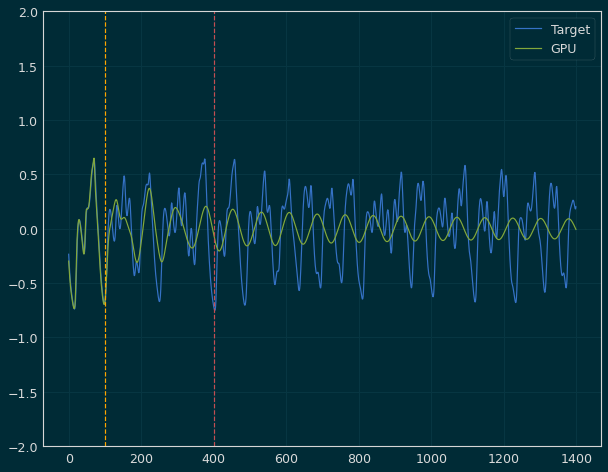

 Iter=40 a=0.284 sr=1.704 amp=0.421  ri=0.127 rr=4.965 loss=0.540281


Iter: 40 #### Diagnostic 0.540   Time 18.63  Best 0.540 NRMSE 0.157 CD 0.383
Iter: 41 #### Diagnostic 1000.000   Time 21.19  Best 0.540 NRMSE 1000.000 CD nan
Iter: 42 #### Diagnostic 1000.000   Time 17.27  Best 0.540 NRMSE 1000.000 CD nan
Iter: 43 #### Diagnostic 1.537   Time 16.22  Best 0.540 NRMSE 0.314 CD 1.224
Iter: 44 #### Diagnostic 0.979   Time 18.14  Best 0.540 NRMSE 0.195 CD 0.784
Iter: 45 #### Diagnostic 1000.000   Time 20.46  Best 0.540 NRMSE 1000.000 CD nan
Iter: 46 #### Diagnostic 1000.000   Time 17.55  Best 0.540 NRMSE 1000.000 CD nan
Iter: 47 #### Diagnostic 1.395   Time 14.91  Best 0.540 NRMSE 0.334 CD 1.061
Iter: 48 #### Diagnostic 1.727   Time 12.75  Best 0.540 NRMSE 0.326 CD 1.402
Iter: 49 #### Diagnostic 1.378   Time 18.47  Best 0.540 NRMSE 0.245 CD 1.133
Iter: 50 #### Diagnostic 1000.000   Time 15.74  Best 0.540 NRMSE 1000.000 CD nan
Iter: 51 #### Diagnostic 1000.000   Time 17.29  Best 0.540 NRM

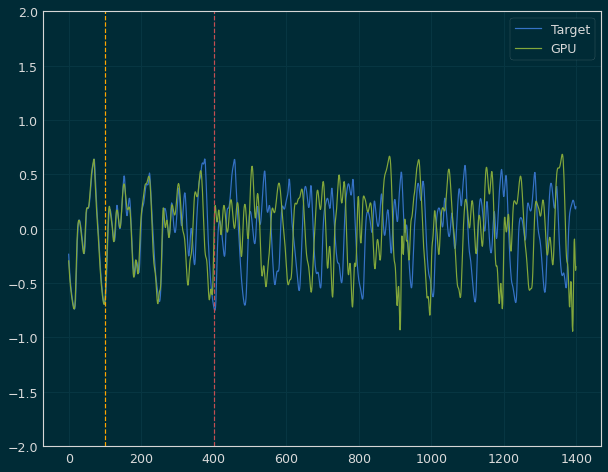

 Iter=97 a=0.456 sr=3.176 amp=0.325  ri=0.475 rr=4.335 loss=0.351573


Iter: 97 #### Diagnostic 0.352   Time 14.73  Best 0.352 NRMSE 0.133 CD 0.219
Iter: 98 #### Diagnostic 852.661   Time 13.48  Best 0.352 NRMSE 851.665 CD 0.996
Iter: 99 #### Diagnostic 1000.000   Time 19.81  Best 0.352 NRMSE 1000.000 CD nan

Best result = 0.3515726072255043
a = 0.4564743938461775
sr = 3.175800413434468
amp = 0.32451025744591405
ri = 0.47548188660427276
rr = 4.335174181102914

 ********** 1000 ***********
Iter: 0 #### Diagnostic 0.992   Time 18.20  Best 1000.000 NRMSE 0.196 CD 0.796
Iter: 1 #### Diagnostic 1000.000   Time 16.07  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 2 #### Diagnostic 1000.000   Time 21.51  Best 1000.000 NRMSE 115847.086 CD 0.905
Iter: 3 #### Diagnostic 1000.000   Time 19.19  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 4 #### Diagnostic 1000.000   Time 19.70  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 5 #### Diagnostic 1000.000   Time 19.55  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 6 

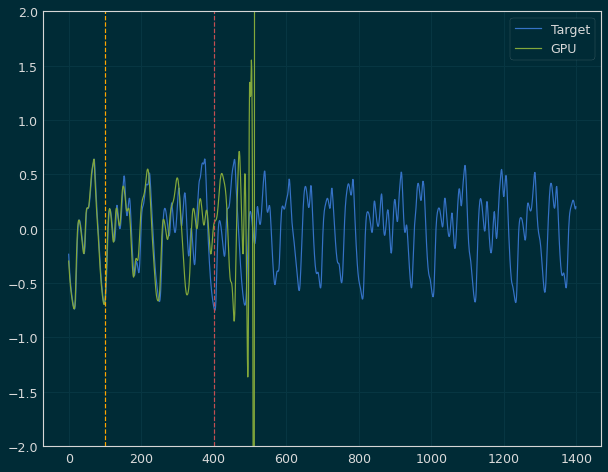

 Iter=15 a=0.555 sr=7.115 amp=0.184  ri=0.316 rr=0.371 loss=0.466411


Iter: 15 #### Diagnostic 0.466   Time 18.34  Best 0.466 NRMSE 0.153 CD 0.314
Iter: 16 #### Diagnostic 1000.000   Time 20.26  Best 0.466 NRMSE 1000.000 CD nan
Iter: 17 #### Diagnostic 1000.000   Time 18.09  Best 0.466 NRMSE 1000.000 CD nan
Iter: 18 #### Diagnostic 1.236   Time 10.54  Best 0.466 NRMSE 0.224 CD 1.012
Iter: 19 #### Diagnostic 1000.000   Time 17.89  Best 0.466 NRMSE 1000.000 CD nan
Iter: 20 #### Diagnostic 1.467   Time 21.79  Best 0.466 NRMSE 0.249 CD 1.218
Iter: 21 #### Diagnostic 0.614   Time 17.59  Best 0.466 NRMSE 0.180 CD 0.435
Iter: 22 #### Diagnostic 1000.000   Time 18.84  Best 0.466 NRMSE 1000.000 CD nan
Iter: 23 #### Diagnostic 1000.000   Time 19.50  Best 0.466 NRMSE 1000.000 CD nan
Iter: 24 #### Diagnostic 1000.000   Time 11.44  Best 0.466 NRMSE 1000.000 CD nan
Iter: 25 #### Diagnostic 1000.000   Time 17.04  Best 0.466 NRMSE 1000.000 CD nan
Iter: 26 #### Diagnostic 1000.000   Time 18.32  Best 0

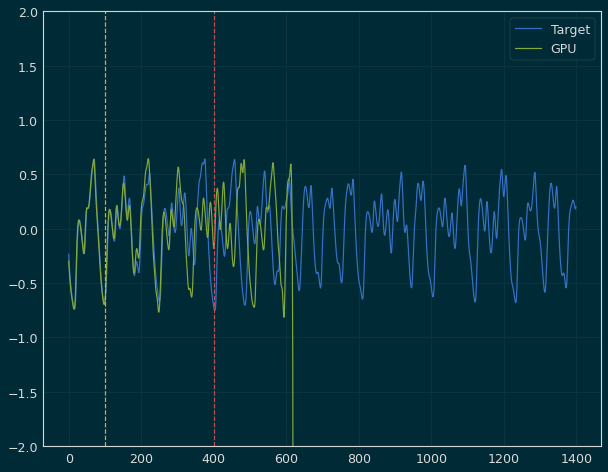

 Iter=64 a=0.823 sr=3.513 amp=0.312  ri=0.991 rr=1.873 loss=0.431383


Iter: 64 #### Diagnostic 0.431   Time 19.86  Best 0.431 NRMSE 0.148 CD 0.283
Iter: 65 #### Diagnostic 1.342   Time 19.04  Best 0.431 NRMSE 0.300 CD 1.042
Iter: 66 #### Diagnostic 1000.000   Time 19.95  Best 0.431 NRMSE 1000.000 CD nan
Iter: 67 #### Diagnostic 1000.000   Time 15.94  Best 0.431 NRMSE 1000.000 CD nan
Iter: 68 #### Diagnostic 1000.000   Time 17.40  Best 0.431 NRMSE 1000.000 CD nan
Iter: 69 #### Diagnostic 1000.000   Time 20.42  Best 0.431 NRMSE 1000.000 CD nan
Iter: 70 #### Diagnostic 1000.000   Time 11.36  Best 0.431 NRMSE 1000.000 CD nan
Iter: 71 #### Diagnostic 1000.000   Time 20.64  Best 0.431 NRMSE 1000.000 CD nan
Iter: 72 #### Diagnostic 1000.000   Time 19.72  Best 0.431 NRMSE 1000.000 CD nan
Iter: 73 #### Diagnostic 1000.000   Time 16.06  Best 0.431 NRMSE 1000.000 CD nan
Iter: 74 #### Diagnostic 1000.000   Time 16.48  Best 0.431 NRMSE 1000.000 CD nan
Iter: 75 #### Diagnostic 1000.000   Time 18.91

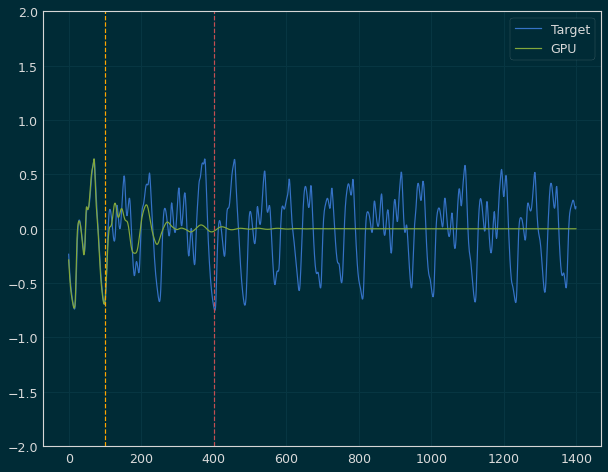

 Iter=2 a=0.197 sr=3.681 amp=0.102  ri=0.338 rr=2.310 loss=0.569318


Iter: 2 #### Diagnostic 0.569   Time 18.13  Best 0.569 NRMSE 0.165 CD 0.405
Iter: 3 #### Diagnostic 1000.000   Time 17.52  Best 0.569 NRMSE 1000.000 CD nan
Iter: 4 #### Diagnostic 1000.000   Time 17.36  Best 0.569 NRMSE 208669592379402911744.000 CD 1.000
Iter: 5 #### Diagnostic 1000.000   Time 15.45  Best 0.569 NRMSE 1000.000 CD nan
Iter: 6 #### Diagnostic 0.667   Time 16.74  Best 0.569 NRMSE 0.193 CD 0.473
Iter: 7 #### Diagnostic 1000.000   Time 18.37  Best 0.569 NRMSE 1000.000 CD nan
Iter: 8 #### Diagnostic 0.890   Time 18.38  Best 0.569 NRMSE 0.212 CD 0.678
Iter: 9 #### Diagnostic 1000.000   Time 21.09  Best 0.569 NRMSE 1000.000 CD nan
Iter: 10 #### Diagnostic 1000.000   Time 17.31  Best 0.569 NRMSE 1000.000 CD nan
Iter: 11 #### Diagnostic 1.453   Time 17.91  Best 0.569 NRMSE 0.282 CD 1.170
Iter: 12 #### Diagnostic 1000.000   Time 19.91  Best 0.569 NRMSE 1000.000 CD nan
Iter: 13 #### Diagnostic 1000.000   Time 14.

Iter: 0 #### Diagnostic 0.979   Time 14.94  Best 1000.000 NRMSE 0.246 CD 0.733
Iter: 1 #### Diagnostic 1000.000   Time 19.26  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 2 #### Diagnostic 1000.000   Time 19.14  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 3 #### Diagnostic 1000.000   Time 19.32  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 4 #### Diagnostic 1.204   Time 18.97  Best 1000.000 NRMSE 0.215 CD 0.989
Iter: 5 #### Diagnostic 1000.000   Time 18.19  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 6 #### Diagnostic 1000.000   Time 10.69  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 7 #### Diagnostic 1000.000   Time 12.55  Best 1000.000 NRMSE 1000.000 CD nan


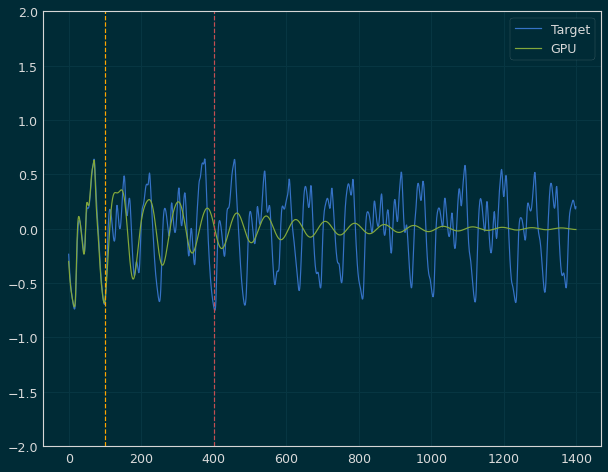

 Iter=8 a=0.044 sr=1.570 amp=0.477  ri=0.038 rr=0.031 loss=0.674009


Iter: 8 #### Diagnostic 0.674   Time 15.60  Best 0.674 NRMSE 0.178 CD 0.496
Iter: 9 #### Diagnostic 1000.000   Time 20.25  Best 0.674 NRMSE 1000.000 CD nan
Iter: 10 #### Diagnostic 1000.000   Time 19.72  Best 0.674 NRMSE 1000.000 CD nan
Iter: 11 #### Diagnostic 181.555   Time 18.63  Best 0.674 NRMSE 180.562 CD 0.993
Iter: 12 #### Diagnostic 1000.000   Time 13.00  Best 0.674 NRMSE 1000.000 CD nan
Iter: 13 #### Diagnostic 0.958   Time 17.03  Best 0.674 NRMSE 0.199 CD 0.759
Iter: 14 #### Diagnostic 1000.000   Time 20.93  Best 0.674 NRMSE 1000.000 CD nan


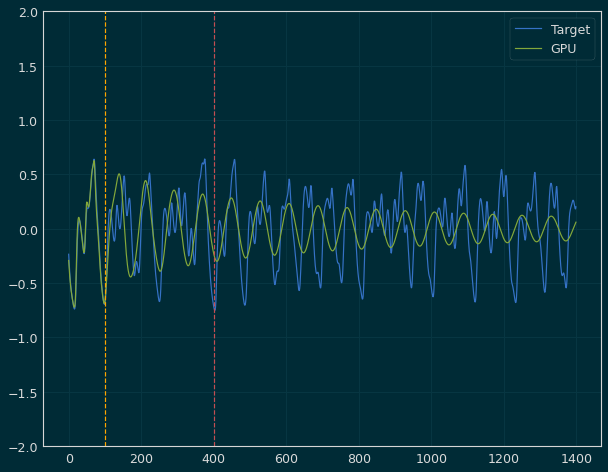

 Iter=15 a=0.090 sr=2.324 amp=0.111  ri=0.140 rr=3.057 loss=0.607906


Iter: 15 #### Diagnostic 0.608   Time 21.83  Best 0.608 NRMSE 0.176 CD 0.432
Iter: 16 #### Diagnostic 1000.000   Time 19.09  Best 0.608 NRMSE 1000.000 CD nan
Iter: 17 #### Diagnostic 1000.000   Time 19.31  Best 0.608 NRMSE 1000.000 CD nan
Iter: 18 #### Diagnostic 1.091   Time 16.96  Best 0.608 NRMSE 0.242 CD 0.849
Iter: 19 #### Diagnostic 0.953   Time 19.68  Best 0.608 NRMSE 0.194 CD 0.759
Iter: 20 #### Diagnostic 1000.000   Time 15.38  Best 0.608 NRMSE 1000.000 CD nan
Iter: 21 #### Diagnostic 0.753   Time 12.89  Best 0.608 NRMSE 0.181 CD 0.572
Iter: 22 #### Diagnostic 1000.000   Time 18.06  Best 0.608 NRMSE 1000.000 CD nan
Iter: 23 #### Diagnostic 1000.000   Time 20.37  Best 0.608 NRMSE 1000.000 CD nan
Iter: 24 #### Diagnostic 1000.000   Time 16.48  Best 0.608 NRMSE 4667372400175790111655460864.000 CD 1.000
Iter: 25 #### Diagnostic 1000.000   Time 20.12  Best 0.608 NRMSE 1000.000 CD nan
Iter: 26 #### Diagnostic 100

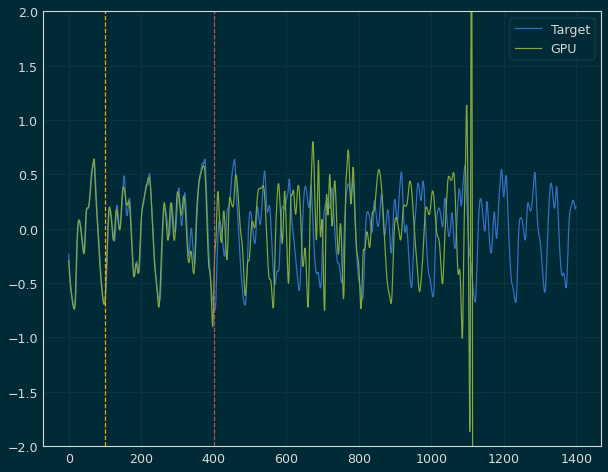

 Iter=43 a=0.419 sr=7.726 amp=0.154  ri=0.532 rr=2.039 loss=0.088090


Iter: 43 #### Diagnostic 0.088   Time 16.46  Best 0.088 NRMSE 0.053 CD 0.035
Iter: 44 #### Diagnostic 1000.000   Time 16.85  Best 0.088 NRMSE 1000.000 CD nan
Iter: 45 #### Diagnostic 1000.000   Time 19.84  Best 0.088 NRMSE 1000.000 CD nan
Iter: 46 #### Diagnostic 1000.000   Time 21.70  Best 0.088 NRMSE 1000.000 CD nan
Iter: 47 #### Diagnostic 1000.000   Time 18.22  Best 0.088 NRMSE 1000.000 CD nan
Iter: 48 #### Diagnostic 1000.000   Time 19.50  Best 0.088 NRMSE 1000.000 CD nan
Iter: 49 #### Diagnostic 1000.000   Time 18.29  Best 0.088 NRMSE 1000.000 CD nan
Iter: 50 #### Diagnostic 1000.000   Time 14.17  Best 0.088 NRMSE 1000.000 CD nan
Iter: 51 #### Diagnostic 1000.000   Time 15.22  Best 0.088 NRMSE 1000.000 CD nan
Iter: 52 #### Diagnostic 1.108   Time 18.16  Best 0.088 NRMSE 0.272 CD 0.836
Iter: 53 #### Diagnostic 1000.000   Time 20.30  Best 0.088 NRMSE 1000.000 CD nan
Iter: 54 #### Diagnostic 1.455   Time 14.77  B

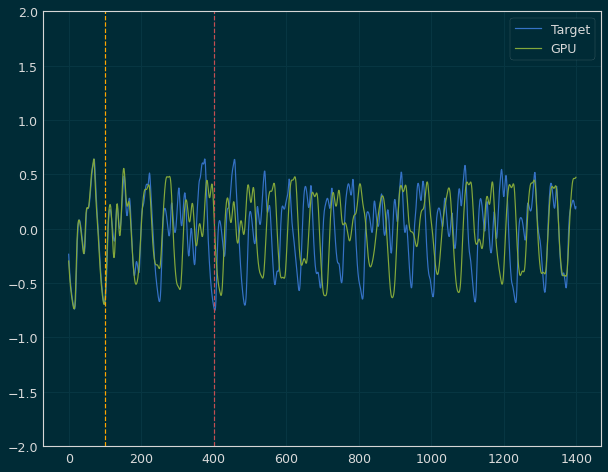

 Iter=13 a=0.643 sr=4.119 amp=0.234  ri=0.505 rr=3.252 loss=0.766799


Iter: 13 #### Diagnostic 0.767   Time 15.56  Best 0.767 NRMSE 0.207 CD 0.560
Iter: 14 #### Diagnostic 1.234   Time 17.96  Best 0.767 NRMSE 0.223 CD 1.011
Iter: 15 #### Diagnostic 1.400   Time 18.31  Best 0.767 NRMSE 0.253 CD 1.147
Iter: 16 #### Diagnostic 1000.000   Time 16.91  Best 0.767 NRMSE 417763878861408169586874754187395072.000 CD 1.000
Iter: 17 #### Diagnostic 1.302   Time 18.71  Best 0.767 NRMSE 0.234 CD 1.068
Iter: 18 #### Diagnostic 1000.000   Time 19.55  Best 0.767 NRMSE 1000.000 CD nan
Iter: 19 #### Diagnostic 1000.000   Time 12.43  Best 0.767 NRMSE 1000.000 CD nan
Iter: 20 #### Diagnostic 1.094   Time 20.87  Best 0.767 NRMSE 0.202 CD 0.892
Iter: 21 #### Diagnostic 1000.000   Time 18.56  Best 0.767 NRMSE 1000.000 CD nan
Iter: 22 #### Diagnostic 1.047   Time 16.36  Best 0.767 NRMSE 0.202 CD 0.845
Iter: 23 #### Diagnostic 1000.000   Time 18.24  Best 0.767 NRMSE 1000.000 CD nan
Iter: 24 #### Diagnostic 100

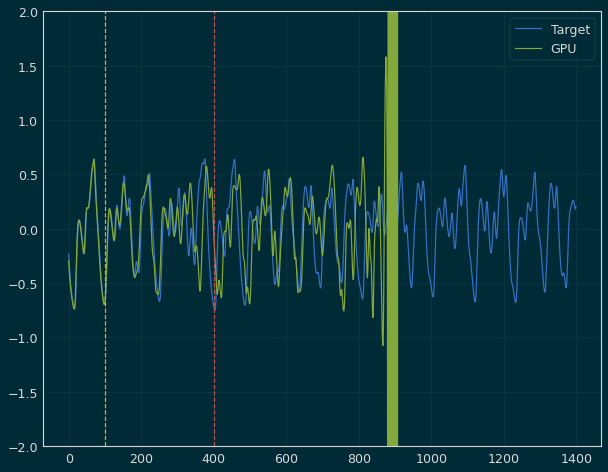

 Iter=36 a=0.692 sr=5.437 amp=0.238  ri=0.535 rr=2.709 loss=0.675314


Iter: 36 #### Diagnostic 0.675   Time 15.90  Best 0.675 NRMSE 0.189 CD 0.486
Iter: 37 #### Diagnostic 1000.000   Time 12.00  Best 0.675 NRMSE 1000.000 CD nan
Iter: 38 #### Diagnostic 1000.000   Time 16.52  Best 0.675 NRMSE 1000.000 CD nan
Iter: 39 #### Diagnostic 1000.000   Time 12.25  Best 0.675 NRMSE 1000.000 CD nan
Iter: 40 #### Diagnostic 1.325   Time 16.89  Best 0.675 NRMSE 0.292 CD 1.033
Iter: 41 #### Diagnostic 1000.000   Time 16.28  Best 0.675 NRMSE 1000.000 CD nan
Iter: 42 #### Diagnostic 1.172   Time 19.63  Best 0.675 NRMSE 0.210 CD 0.961
Iter: 43 #### Diagnostic 1000.000   Time 15.66  Best 0.675 NRMSE 1000.000 CD nan
Iter: 44 #### Diagnostic 0.918   Time 15.07  Best 0.675 NRMSE 0.192 CD 0.727
Iter: 45 #### Diagnostic 0.919   Time 15.25  Best 0.675 NRMSE 0.192 CD 0.728
Iter: 46 #### Diagnostic 0.942   Time 13.54  Best 0.675 NRMSE 0.193 CD 0.749
Iter: 47 #### Diagnostic 1000.000   Time 19.77  Best 0.675 NRM

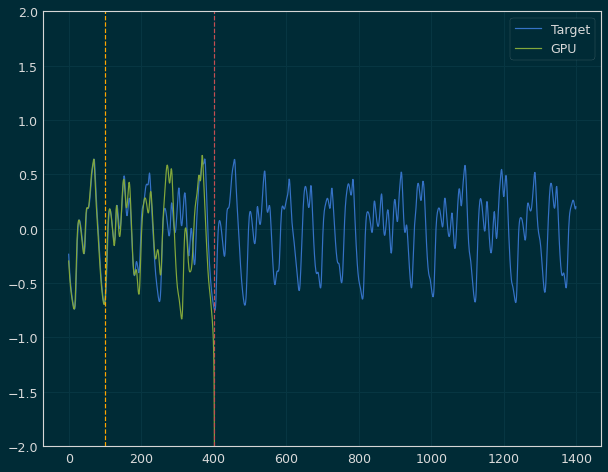

 Iter=72 a=0.969 sr=1.537 amp=0.667  ri=0.802 rr=2.163 loss=0.558101


Iter: 72 #### Diagnostic 0.558   Time 17.26  Best 0.558 NRMSE 0.190 CD 0.368
Iter: 73 #### Diagnostic 1000.000   Time 19.20  Best 0.558 NRMSE 1000.000 CD nan


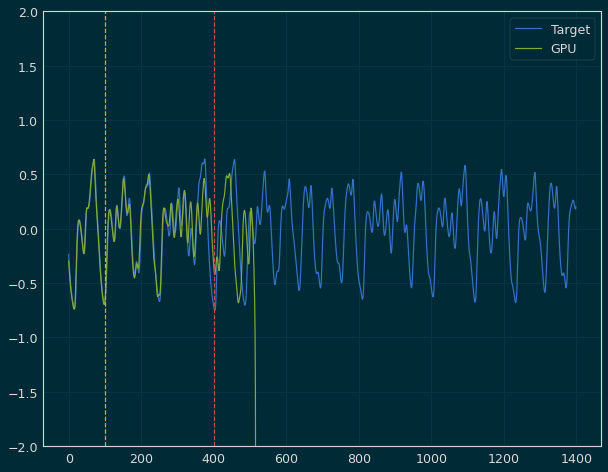

 Iter=74 a=0.602 sr=1.117 amp=0.923  ri=0.919 rr=4.757 loss=0.268416


Iter: 74 #### Diagnostic 0.268   Time 20.29  Best 0.268 NRMSE 0.108 CD 0.160
Iter: 75 #### Diagnostic 1000.000   Time 13.26  Best 0.268 NRMSE 1000.000 CD nan
Iter: 76 #### Diagnostic 0.675   Time 15.12  Best 0.268 NRMSE 0.181 CD 0.494
Iter: 77 #### Diagnostic 1000.000   Time 16.30  Best 0.268 NRMSE 1000.000 CD nan
Iter: 78 #### Diagnostic 1000.000   Time 16.03  Best 0.268 NRMSE 1000.000 CD nan
Iter: 79 #### Diagnostic 1000.000   Time 15.95  Best 0.268 NRMSE 1000.000 CD nan
Iter: 80 #### Diagnostic 1000.000   Time 17.84  Best 0.268 NRMSE 1000.000 CD nan
Iter: 81 #### Diagnostic 1000.000   Time 14.13  Best 0.268 NRMSE 1000.000 CD nan
Iter: 82 #### Diagnostic 1000.000   Time 11.49  Best 0.268 NRMSE 1726.607 CD 1.182
Iter: 83 #### Diagnostic 0.866   Time 19.40  Best 0.268 NRMSE 0.192 CD 0.673
Iter: 84 #### Diagnostic 1000.000   Time 19.76  Best 0.268 NRMSE 1000.000 CD nan
Iter: 85 #### Diagnostic 1.156   Time 17.74  Bes

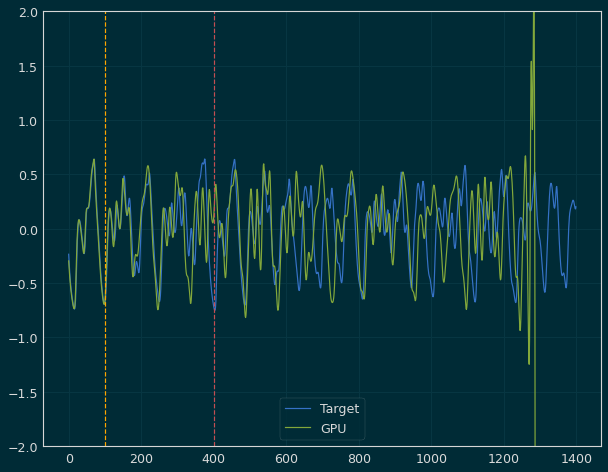

 Iter=4 a=0.307 sr=4.693 amp=0.276  ri=0.455 rr=3.789 loss=0.602279


Iter: 4 #### Diagnostic 0.602   Time 17.59  Best 0.602 NRMSE 0.181 CD 0.421
Iter: 5 #### Diagnostic 1000.000   Time 17.11  Best 0.602 NRMSE 1000.000 CD nan
Iter: 6 #### Diagnostic 1000.000   Time 17.58  Best 0.602 NRMSE 1000.000 CD nan
Iter: 7 #### Diagnostic 1000.000   Time 12.40  Best 0.602 NRMSE 1000.000 CD nan
Iter: 8 #### Diagnostic 1000.000   Time 21.83  Best 0.602 NRMSE 1000.000 CD nan
Iter: 9 #### Diagnostic 1000.000   Time 16.57  Best 0.602 NRMSE 1000.000 CD nan
Iter: 10 #### Diagnostic 1.000   Time 16.29  Best 0.602 NRMSE 0.196 CD 0.803
Iter: 11 #### Diagnostic 1000.000   Time 19.78  Best 0.602 NRMSE 1000.000 CD nan
Iter: 12 #### Diagnostic 1000.000   Time 19.01  Best 0.602 NRMSE 1000.000 CD nan
Iter: 13 #### Diagnostic 1000.000   Time 17.87  Best 0.602 NRMSE 1000.000 CD nan
Iter: 14 #### Diagnostic 0.960   Time 19.45  Best 0.602 NRMSE 0.195 CD 0.765
Iter: 15 #### Diagnostic 0.966   Time 18.02  Best 0.602 N

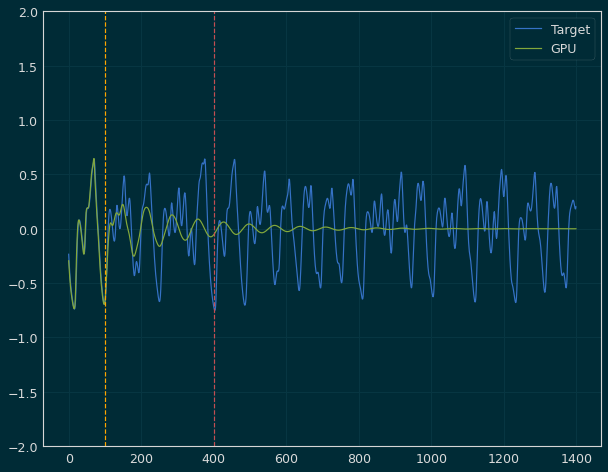

 Iter=21 a=0.470 sr=4.021 amp=0.173  ri=0.299 rr=1.345 loss=0.544687


Iter: 21 #### Diagnostic 0.545   Time 17.76  Best 0.545 NRMSE 0.161 CD 0.384
Iter: 22 #### Diagnostic 1000.000   Time 14.87  Best 0.545 NRMSE 1000.000 CD nan
Iter: 23 #### Diagnostic 1.225   Time 18.13  Best 0.545 NRMSE 0.242 CD 0.983
Iter: 24 #### Diagnostic 1000.000   Time 17.46  Best 0.545 NRMSE 1000.000 CD nan
Iter: 25 #### Diagnostic 1000.000   Time 18.85  Best 0.545 NRMSE 1000.000 CD nan
Iter: 26 #### Diagnostic 1000.000   Time 20.09  Best 0.545 NRMSE 1000.000 CD nan
Iter: 27 #### Diagnostic 1000.000   Time 13.35  Best 0.545 NRMSE 1000.000 CD nan
Iter: 28 #### Diagnostic 1000.000   Time 18.23  Best 0.545 NRMSE 1000.000 CD nan
Iter: 29 #### Diagnostic 1.165   Time 22.08  Best 0.545 NRMSE 0.210 CD 0.955
Iter: 30 #### Diagnostic 1000.000   Time 21.15  Best 0.545 NRMSE 1000.000 CD nan
Iter: 31 #### Diagnostic 1000.000   Time 16.56  Best 0.545 NRMSE 1000.000 CD nan
Iter: 32 #### Diagnostic 0.990   Time 17.67  Best 

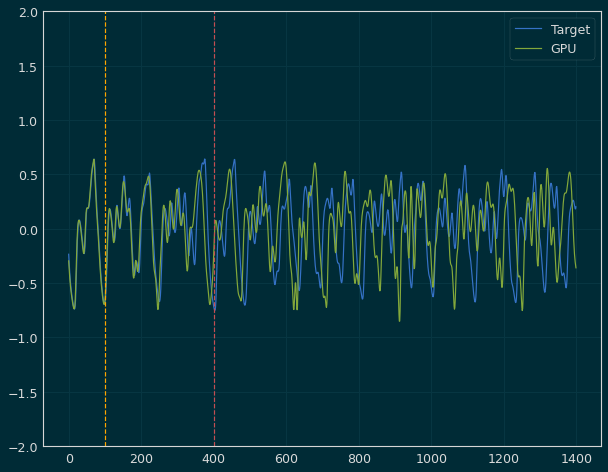

 Iter=97 a=0.456 sr=3.176 amp=0.325  ri=0.475 rr=4.335 loss=0.372969


Iter: 97 #### Diagnostic 0.373   Time 17.67  Best 0.373 NRMSE 0.137 CD 0.236
Iter: 98 #### Diagnostic 1000.000   Time 17.85  Best 0.373 NRMSE 1000.000 CD nan
Iter: 99 #### Diagnostic 1000.000   Time 16.66  Best 0.373 NRMSE 1000.000 CD nan

Best result = 0.3729689916147705
a = 0.4564743938461775
sr = 3.175800413434468
amp = 0.32451025744591405
ri = 0.47548188660427276
rr = 4.335174181102914

 ********** 1000 ***********
Iter: 0 #### Diagnostic 0.997   Time 17.78  Best 1000.000 NRMSE 0.196 CD 0.801
Iter: 1 #### Diagnostic 1000.000   Time 16.84  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 2 #### Diagnostic 1000.000   Time 17.81  Best 1000.000 NRMSE 446944194.057 CD 1.069
Iter: 3 #### Diagnostic 1000.000   Time 22.60  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 4 #### Diagnostic 1000.000   Time 13.27  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 5 #### Diagnostic 1000.000   Time 19.20  Best 1000.000 NRMSE 1000.000 CD nan
Iter:

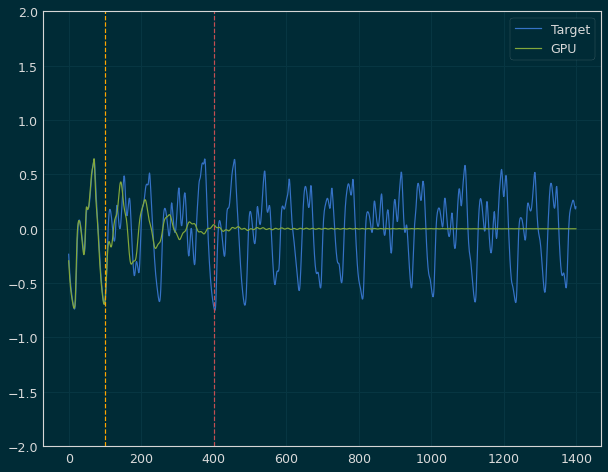

 Iter=32 a=0.220 sr=0.632 amp=0.406  ri=0.786 rr=3.068 loss=0.797830


Iter: 32 #### Diagnostic 0.798   Time 19.10  Best 0.798 NRMSE 0.186 CD 0.612


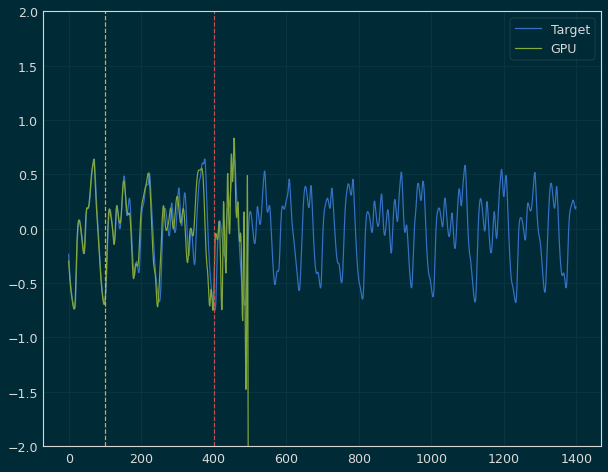

 Iter=33 a=0.722 sr=1.044 amp=0.987  ri=0.297 rr=1.165 loss=0.275835


Iter: 33 #### Diagnostic 0.276   Time 21.14  Best 0.276 NRMSE 0.114 CD 0.162
Iter: 34 #### Diagnostic 1000.000   Time 21.62  Best 0.276 NRMSE 1000.000 CD nan
Iter: 35 #### Diagnostic 1.122   Time 17.81  Best 0.276 NRMSE 0.253 CD 0.869
Iter: 36 #### Diagnostic 1000.000   Time 15.71  Best 0.276 NRMSE 1034866318450359680.000 CD 1.000
Iter: 37 #### Diagnostic 0.999   Time 18.29  Best 0.276 NRMSE 0.198 CD 0.802
Iter: 38 #### Diagnostic 0.851   Time 16.63  Best 0.276 NRMSE 0.197 CD 0.654
Iter: 39 #### Diagnostic 0.981   Time 10.41  Best 0.276 NRMSE 0.198 CD 0.783
Iter: 40 #### Diagnostic 1.268   Time 17.15  Best 0.276 NRMSE 0.224 CD 1.044
Iter: 41 #### Diagnostic 1.088   Time 18.78  Best 0.276 NRMSE 0.203 CD 0.885
Iter: 42 #### Diagnostic 0.939   Time 12.30  Best 0.276 NRMSE 0.228 CD 0.711
Iter: 43 #### Diagnostic 1000.000   Time 20.11  Best 0.276 NRMSE 1000.000 CD nan
Iter: 44 #### Diagnostic 1000.000   Time 14.45  Best 

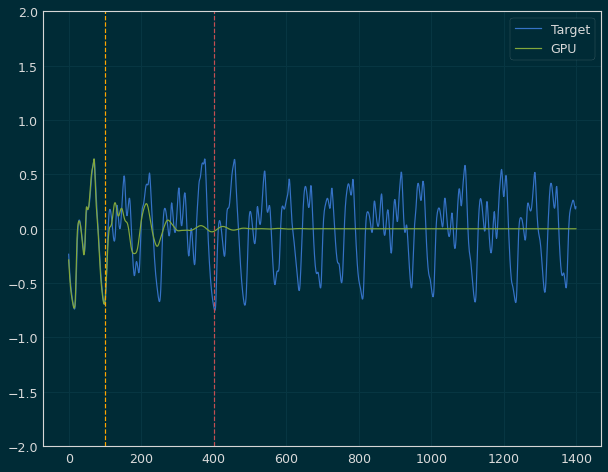

 Iter=2 a=0.197 sr=3.681 amp=0.102  ri=0.338 rr=2.310 loss=0.578621


Iter: 2 #### Diagnostic 0.579   Time 18.66  Best 0.579 NRMSE 0.165 CD 0.414
Iter: 3 #### Diagnostic 1000.000   Time 16.41  Best 0.579 NRMSE 1000.000 CD nan
Iter: 4 #### Diagnostic 1000.000   Time 18.01  Best 0.579 NRMSE 1000.000 CD nan
Iter: 5 #### Diagnostic 1000.000   Time 12.51  Best 0.579 NRMSE 1000.000 CD nan
Iter: 6 #### Diagnostic 1000.000   Time 15.06  Best 0.579 NRMSE 1000.000 CD nan
Iter: 7 #### Diagnostic 1000.000   Time 20.53  Best 0.579 NRMSE 1000.000 CD nan
Iter: 8 #### Diagnostic 0.897   Time 17.91  Best 0.579 NRMSE 0.214 CD 0.683
Iter: 9 #### Diagnostic 1000.000   Time 17.03  Best 0.579 NRMSE 1000.000 CD nan
Iter: 10 #### Diagnostic 1000.000   Time 18.65  Best 0.579 NRMSE 1000.000 CD nan
Iter: 11 #### Diagnostic 1.159   Time 20.10  Best 0.579 NRMSE 0.241 CD 0.917
Iter: 12 #### Diagnostic 1000.000   Time 17.00  Best 0.579 NRMSE 1000.000 CD nan
Iter: 13 #### Diagnostic 1000.000   Time 20.54  Best 0.579 

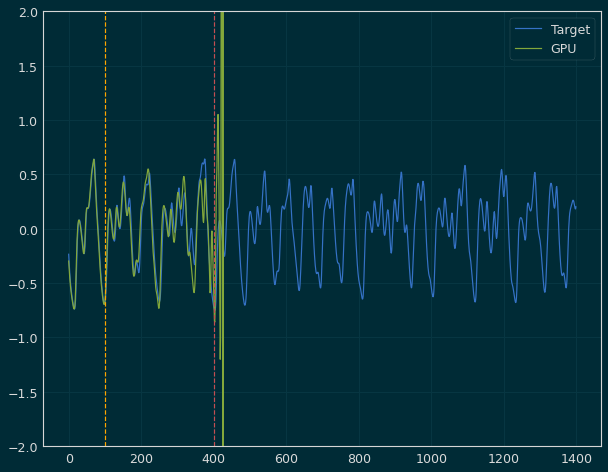

 Iter=41 a=0.901 sr=5.528 amp=0.289  ri=0.666 rr=1.418 loss=0.218788


Iter: 41 #### Diagnostic 0.219   Time 19.13  Best 0.219 NRMSE 0.097 CD 0.122
Iter: 42 #### Diagnostic 1.233   Time 16.21  Best 0.219 NRMSE 0.236 CD 0.997
Iter: 43 #### Diagnostic 1000.000   Time 20.48  Best 0.219 NRMSE 1000.000 CD nan
Iter: 44 #### Diagnostic 0.993   Time 13.84  Best 0.219 NRMSE 0.196 CD 0.797
Iter: 45 #### Diagnostic 1.115   Time 16.94  Best 0.219 NRMSE 0.213 CD 0.903
Iter: 46 #### Diagnostic 1.364   Time 14.52  Best 0.219 NRMSE 0.236 CD 1.128
Iter: 47 #### Diagnostic 1.021   Time 15.76  Best 0.219 NRMSE 0.198 CD 0.823
Iter: 48 #### Diagnostic 1000.000   Time 17.37  Best 0.219 NRMSE 1000.000 CD nan
Iter: 49 #### Diagnostic 1.468   Time 18.60  Best 0.219 NRMSE 0.268 CD 1.200
Iter: 50 #### Diagnostic 0.965   Time 20.05  Best 0.219 NRMSE 0.308 CD 0.657
Iter: 51 #### Diagnostic 1.492   Time 13.36  Best 0.219 NRMSE 0.297 CD 1.196
Iter: 52 #### Diagnostic 6.944   Time 12.78  Best 0.219 NRMSE 5.889 CD 1.0

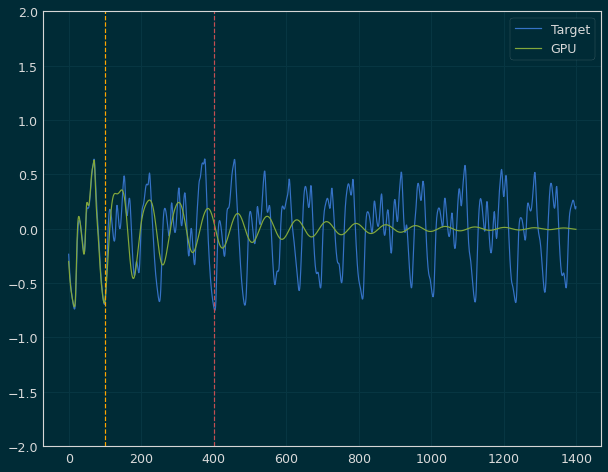

 Iter=8 a=0.044 sr=1.570 amp=0.477  ri=0.038 rr=0.031 loss=0.695610


Iter: 8 #### Diagnostic 0.696   Time 15.86  Best 0.696 NRMSE 0.181 CD 0.515
Iter: 9 #### Diagnostic 1000.000   Time 17.27  Best 0.696 NRMSE 1000.000 CD nan
Iter: 10 #### Diagnostic 1000.000   Time 16.48  Best 0.696 NRMSE 1000.000 CD nan
Iter: 11 #### Diagnostic 1000.000   Time 15.19  Best 0.696 NRMSE 1000.000 CD nan
Iter: 12 #### Diagnostic 1000.000   Time 14.17  Best 0.696 NRMSE 1000.000 CD nan
Iter: 13 #### Diagnostic 0.958   Time 16.72  Best 0.696 NRMSE 0.199 CD 0.759
Iter: 14 #### Diagnostic 1000.000   Time 19.04  Best 0.696 NRMSE 1000.000 CD nan


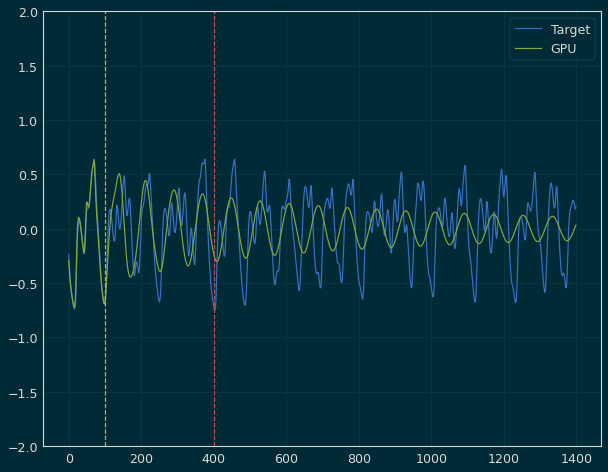

 Iter=15 a=0.090 sr=2.324 amp=0.111  ri=0.140 rr=3.057 loss=0.612623


Iter: 15 #### Diagnostic 0.613   Time 19.18  Best 0.613 NRMSE 0.177 CD 0.435
Iter: 16 #### Diagnostic 1000.000   Time 12.88  Best 0.613 NRMSE 1000.000 CD nan
Iter: 17 #### Diagnostic 1000.000   Time 18.23  Best 0.613 NRMSE 1000.000 CD nan
Iter: 18 #### Diagnostic 0.973   Time 16.82  Best 0.613 NRMSE 0.228 CD 0.745
Iter: 19 #### Diagnostic 0.940   Time 14.44  Best 0.613 NRMSE 0.193 CD 0.747
Iter: 20 #### Diagnostic 1000.000   Time 16.66  Best 0.613 NRMSE 1000.000 CD nan
Iter: 21 #### Diagnostic 0.964   Time 15.30  Best 0.613 NRMSE 0.202 CD 0.762
Iter: 22 #### Diagnostic 1000.000   Time 20.07  Best 0.613 NRMSE 1000.000 CD nan
Iter: 23 #### Diagnostic 1000.000   Time 13.21  Best 0.613 NRMSE 1000.000 CD nan
Iter: 24 #### Diagnostic 1000.000   Time 17.72  Best 0.613 NRMSE 1000.000 CD nan
Iter: 25 #### Diagnostic 1000.000   Time 14.17  Best 0.613 NRMSE 1000.000 CD nan
Iter: 26 #### Diagnostic 1000.000   Time 13.44  Best 0

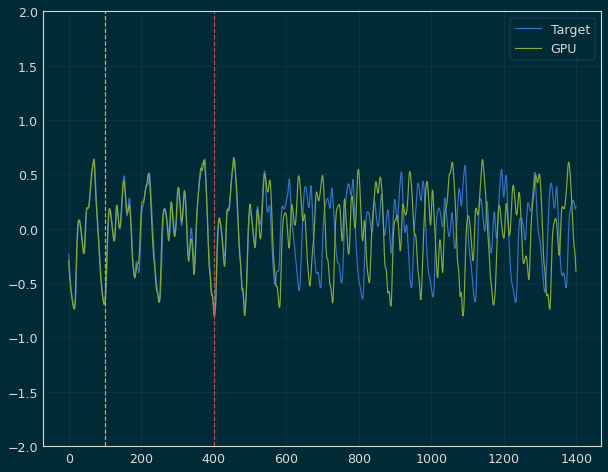

 Iter=36 a=0.713 sr=4.980 amp=0.240  ri=0.691 rr=1.424 loss=0.060286


Iter: 36 #### Diagnostic 0.060   Time 19.40  Best 0.060 NRMSE 0.040 CD 0.020
Iter: 37 #### Diagnostic 1000.000   Time 17.19  Best 0.060 NRMSE 1000.000 CD nan
Iter: 38 #### Diagnostic 0.559   Time 10.39  Best 0.060 NRMSE 0.170 CD 0.389
Iter: 39 #### Diagnostic 1000.000   Time 13.65  Best 0.060 NRMSE 1000.000 CD nan
Iter: 40 #### Diagnostic 0.999   Time 20.00  Best 0.060 NRMSE 0.197 CD 0.803
Iter: 41 #### Diagnostic 1.319   Time 15.36  Best 0.060 NRMSE 0.231 CD 1.088
Iter: 42 #### Diagnostic 1.373   Time 13.14  Best 0.060 NRMSE 0.322 CD 1.050
Iter: 43 #### Diagnostic 0.805   Time 16.45  Best 0.060 NRMSE 0.209 CD 0.596
Iter: 44 #### Diagnostic 1000.000   Time 16.67  Best 0.060 NRMSE 1000.000 CD nan
Iter: 45 #### Diagnostic 1000.000   Time 14.19  Best 0.060 NRMSE 1000.000 CD nan
Iter: 46 #### Diagnostic 1000.000   Time 16.51  Best 0.060 NRMSE 1000.000 CD nan
Iter: 47 #### Diagnostic 1000.000   Time 17.64  Best 0.060 NRM

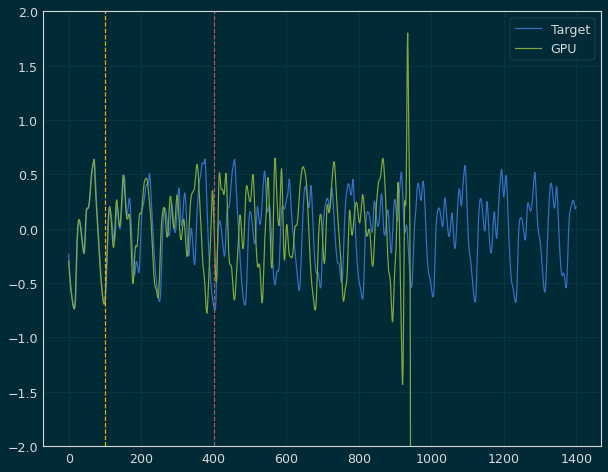

 Iter=4 a=0.240 sr=6.874 amp=0.203  ri=0.727 rr=1.822 loss=0.867468


Iter: 4 #### Diagnostic 0.867   Time 20.51  Best 0.867 NRMSE 0.222 CD 0.645
Iter: 5 #### Diagnostic 1000.000   Time 13.95  Best 0.867 NRMSE 1000.000 CD nan
Iter: 6 #### Diagnostic 1000.000   Time 17.27  Best 0.867 NRMSE 1000.000 CD nan
Iter: 7 #### Diagnostic 1.054   Time 17.19  Best 0.867 NRMSE 0.202 CD 0.852


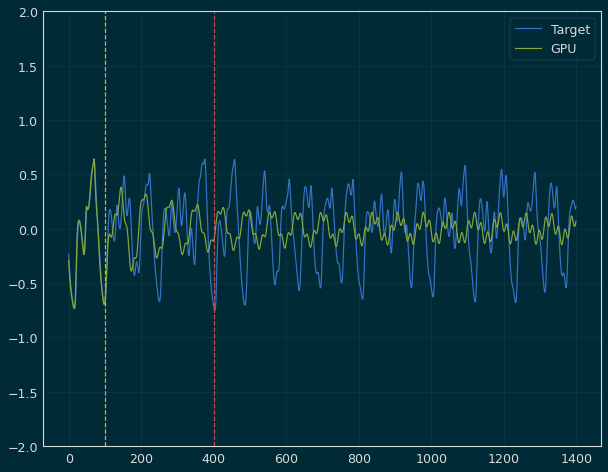

 Iter=8 a=0.173 sr=0.335 amp=0.946  ri=0.765 rr=4.274 loss=0.760155


Iter: 8 #### Diagnostic 0.760   Time 18.30  Best 0.760 NRMSE 0.185 CD 0.576
Iter: 9 #### Diagnostic 1000.000   Time 12.33  Best 0.760 NRMSE 1000.000 CD nan
Iter: 10 #### Diagnostic 1000.000   Time 20.67  Best 0.760 NRMSE 1000.000 CD nan
Iter: 11 #### Diagnostic 1.283   Time 16.72  Best 0.760 NRMSE 0.285 CD 0.998
Iter: 12 #### Diagnostic 1.311   Time 19.13  Best 0.760 NRMSE 0.236 CD 1.074


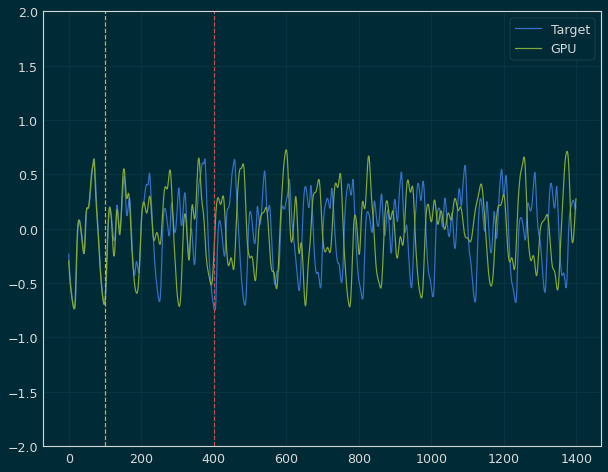

 Iter=13 a=0.643 sr=4.119 amp=0.234  ri=0.505 rr=3.252 loss=0.664303


Iter: 13 #### Diagnostic 0.664   Time 16.11  Best 0.664 NRMSE 0.196 CD 0.468
Iter: 14 #### Diagnostic 0.949   Time 16.89  Best 0.664 NRMSE 0.195 CD 0.754
Iter: 15 #### Diagnostic 1.394   Time 13.60  Best 0.664 NRMSE 0.258 CD 1.136
Iter: 16 #### Diagnostic 562.962   Time 18.07  Best 0.664 NRMSE 561.791 CD 1.171
Iter: 17 #### Diagnostic 1.288   Time 19.45  Best 0.664 NRMSE 0.232 CD 1.056


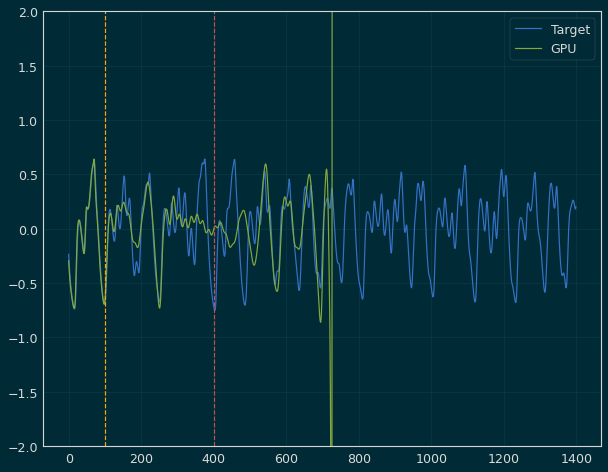

 Iter=18 a=0.147 sr=0.944 amp=0.845  ri=0.489 rr=1.775 loss=0.400510


Iter: 18 #### Diagnostic 0.401   Time 18.27  Best 0.401 NRMSE 0.135 CD 0.265
Iter: 19 #### Diagnostic 1000.000   Time 19.23  Best 0.401 NRMSE 1000.000 CD nan
Iter: 20 #### Diagnostic 1.106   Time 17.29  Best 0.401 NRMSE 0.203 CD 0.903
Iter: 21 #### Diagnostic 0.835   Time 19.32  Best 0.401 NRMSE 0.220 CD 0.614
Iter: 22 #### Diagnostic 1.045   Time 15.37  Best 0.401 NRMSE 0.202 CD 0.843
Iter: 23 #### Diagnostic 1000.000   Time 9.34  Best 0.401 NRMSE 1000.000 CD nan
Iter: 24 #### Diagnostic 1000.000   Time 17.45  Best 0.401 NRMSE 1000.000 CD nan
Iter: 25 #### Diagnostic 0.836   Time 14.70  Best 0.401 NRMSE 0.224 CD 0.612
Iter: 26 #### Diagnostic 1000.000   Time 16.73  Best 0.401 NRMSE 1000.000 CD nan
Iter: 27 #### Diagnostic 1.197   Time 18.76  Best 0.401 NRMSE 0.238 CD 0.959
Iter: 28 #### Diagnostic 0.919   Time 21.19  Best 0.401 NRMSE 0.192 CD 0.727
Iter: 29 #### Diagnostic 1000.000   Time 14.04  Best 0.401 NRMSE 10

Iter: 17 #### Diagnostic 1000.000   Time 20.87  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 18 #### Diagnostic 1000.000   Time 16.38  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 19 #### Diagnostic 1000.000   Time 12.96  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 20 #### Diagnostic 1000.000   Time 17.69  Best 1000.000 NRMSE 1000.000 CD nan


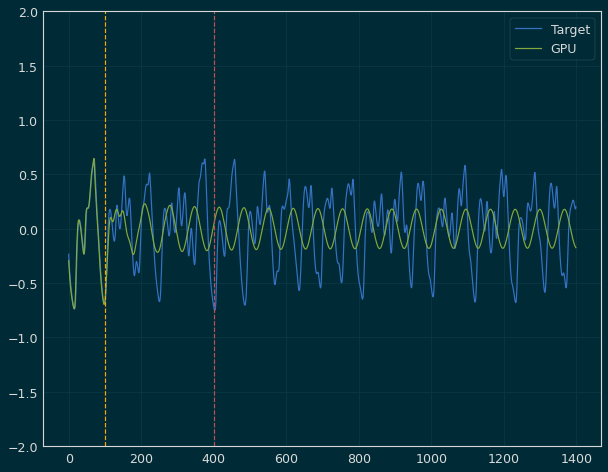

 Iter=21 a=0.470 sr=4.021 amp=0.173  ri=0.299 rr=1.345 loss=0.833241


Iter: 21 #### Diagnostic 0.833   Time 15.65  Best 0.833 NRMSE 0.189 CD 0.645
Iter: 22 #### Diagnostic 1000.000   Time 15.64  Best 0.833 NRMSE 1000.000 CD nan
Iter: 23 #### Diagnostic 1.239   Time 18.96  Best 0.833 NRMSE 0.242 CD 0.997
Iter: 24 #### Diagnostic 1000.000   Time 15.03  Best 0.833 NRMSE 1000.000 CD nan
Iter: 25 #### Diagnostic 1000.000   Time 19.49  Best 0.833 NRMSE 1074.156 CD 0.997
Iter: 26 #### Diagnostic 1000.000   Time 11.39  Best 0.833 NRMSE 1000.000 CD nan
Iter: 27 #### Diagnostic 1000.000   Time 12.67  Best 0.833 NRMSE 1000.000 CD nan
Iter: 28 #### Diagnostic 1000.000   Time 18.83  Best 0.833 NRMSE 1000.000 CD nan
Iter: 29 #### Diagnostic 1.123   Time 16.15  Best 0.833 NRMSE 0.207 CD 0.916
Iter: 30 #### Diagnostic 1000.000   Time 13.86  Best 0.833 NRMSE 1000.000 CD nan
Iter: 31 #### Diagnostic 1000.000   Time 17.38  Best 0.833 NRMSE 1000.000 CD nan
Iter: 32 #### Diagnostic 0.986   Time 15.61  Bes

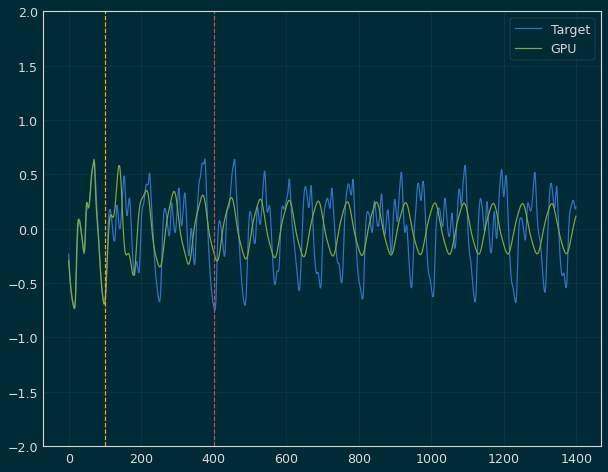

 Iter=37 a=0.140 sr=0.178 amp=0.223  ri=0.357 rr=3.914 loss=0.617854


Iter: 37 #### Diagnostic 0.618   Time 13.12  Best 0.618 NRMSE 0.173 CD 0.445
Iter: 38 #### Diagnostic 1000.000   Time 13.86  Best 0.618 NRMSE 1000.000 CD nan
Iter: 39 #### Diagnostic 1000.000   Time 19.02  Best 0.618 NRMSE 1000.000 CD nan


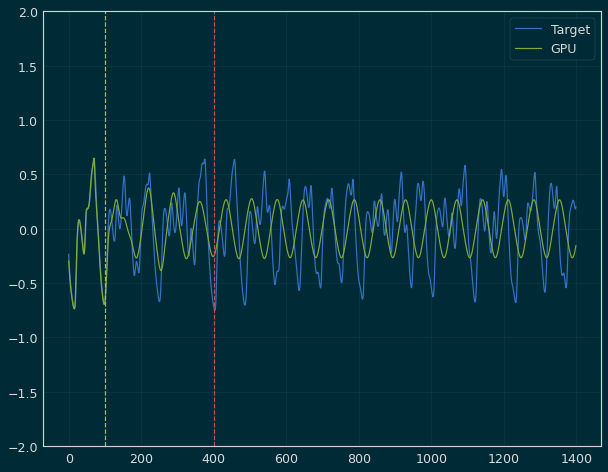

 Iter=40 a=0.284 sr=1.704 amp=0.421  ri=0.127 rr=4.965 loss=0.488915


Iter: 40 #### Diagnostic 0.489   Time 14.25  Best 0.489 NRMSE 0.149 CD 0.339
Iter: 41 #### Diagnostic 1000.000   Time 10.41  Best 0.489 NRMSE 1000.000 CD nan
Iter: 42 #### Diagnostic 1000.000   Time 15.16  Best 0.489 NRMSE 1000.000 CD nan
Iter: 43 #### Diagnostic 1.543   Time 14.19  Best 0.489 NRMSE 0.314 CD 1.229
Iter: 44 #### Diagnostic 0.976   Time 16.29  Best 0.489 NRMSE 0.194 CD 0.781
Iter: 45 #### Diagnostic 0.976   Time 18.14  Best 0.489 NRMSE 0.231 CD 0.746
Iter: 46 #### Diagnostic 1000.000   Time 18.28  Best 0.489 NRMSE 1000.000 CD nan
Iter: 47 #### Diagnostic 1.395   Time 10.77  Best 0.489 NRMSE 0.334 CD 1.061
Iter: 48 #### Diagnostic 1.726   Time 18.22  Best 0.489 NRMSE 0.326 CD 1.400
Iter: 49 #### Diagnostic 1.412   Time 16.62  Best 0.489 NRMSE 0.265 CD 1.147
Iter: 50 #### Diagnostic 1000.000   Time 13.93  Best 0.489 NRMSE 1000.000 CD nan
Iter: 51 #### Diagnostic 1000.000   Time 18.80  Best 0.489 NRMSE 1

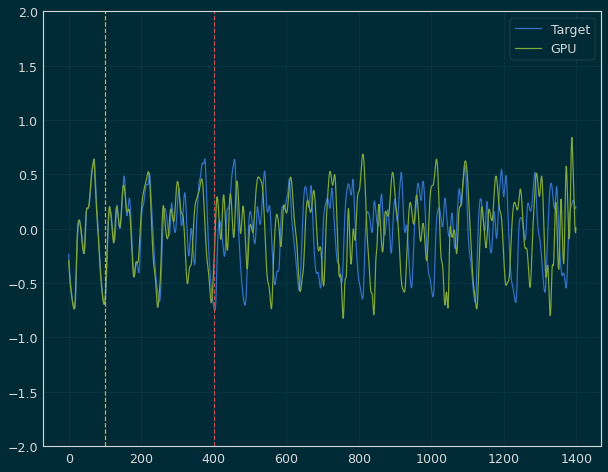

 Iter=97 a=0.456 sr=3.176 amp=0.325  ri=0.475 rr=4.335 loss=0.304163


Iter: 97 #### Diagnostic 0.304   Time 17.18  Best 0.304 NRMSE 0.121 CD 0.183
Iter: 98 #### Diagnostic 1000.000   Time 21.69  Best 0.304 NRMSE 1000.000 CD nan
Iter: 99 #### Diagnostic 1000.000   Time 18.64  Best 0.304 NRMSE 1000.000 CD nan

Best result = 0.30416315227386975
a = 0.4564743938461775
sr = 3.175800413434468
amp = 0.32451025744591405
ri = 0.47548188660427276
rr = 4.335174181102914

 ********** 900 ***********
Iter: 0 #### Diagnostic 1.004   Time 16.03  Best 1000.000 NRMSE 0.197 CD 0.808
Iter: 1 #### Diagnostic 1000.000   Time 14.77  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 2 #### Diagnostic 1000.000   Time 17.56  Best 1000.000 NRMSE 4540328608.831 CD 1.100
Iter: 3 #### Diagnostic 1000.000   Time 14.00  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 4 #### Diagnostic 1000.000   Time 12.72  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 5 #### Diagnostic 1000.000   Time 18.32  Best 1000.000 NRMSE 1000.000 CD nan
Iter

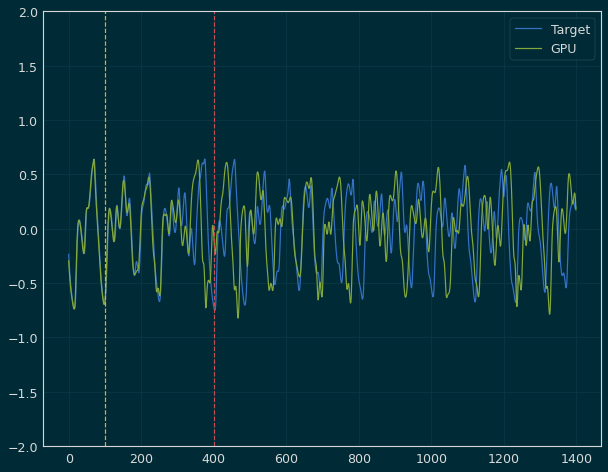

 Iter=9 a=0.613 sr=6.585 amp=0.165  ri=0.637 rr=4.248 loss=0.656094


Iter: 9 #### Diagnostic 0.656   Time 20.61  Best 0.656 NRMSE 0.191 CD 0.465
Iter: 10 #### Diagnostic 1.647   Time 16.91  Best 0.656 NRMSE 0.312 CD 1.336
Iter: 11 #### Diagnostic 1000.000   Time 18.13  Best 0.656 NRMSE 1000.000 CD nan
Iter: 12 #### Diagnostic 1000.000   Time 14.07  Best 0.656 NRMSE 1000.000 CD nan
Iter: 13 #### Diagnostic 1000.000   Time 14.61  Best 0.656 NRMSE 1000.000 CD nan
Iter: 14 #### Diagnostic 1000.000   Time 18.03  Best 0.656 NRMSE 1000.000 CD nan
Iter: 15 #### Diagnostic 1000.000   Time 12.69  Best 0.656 NRMSE 2094688908469180665017134217166848.000 CD 1.000
Iter: 16 #### Diagnostic 1000.000   Time 18.20  Best 0.656 NRMSE 1000.000 CD nan
Iter: 17 #### Diagnostic 1000.000   Time 15.29  Best 0.656 NRMSE 1000.000 CD nan
Iter: 18 #### Diagnostic 1.238   Time 18.39  Best 0.656 NRMSE 0.224 CD 1.014
Iter: 19 #### Diagnostic 1000.000   Time 14.47  Best 0.656 NRMSE 1000.000 CD nan
Iter: 20 #### Diagno

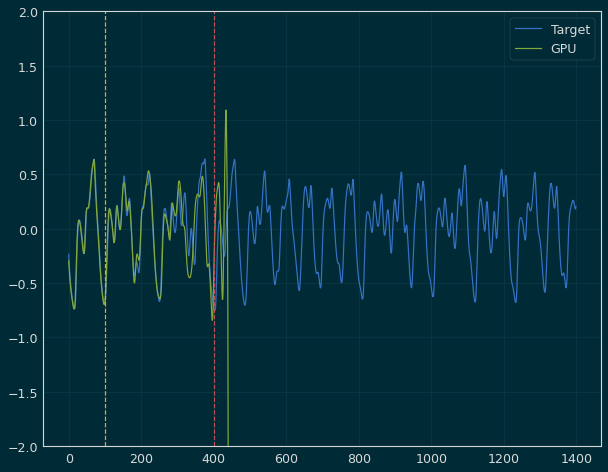

 Iter=24 a=0.532 sr=5.801 amp=0.287  ri=0.698 rr=4.491 loss=0.238766


Iter: 24 #### Diagnostic 0.239   Time 19.55  Best 0.239 NRMSE 0.104 CD 0.134
Iter: 25 #### Diagnostic 1000.000   Time 13.43  Best 0.239 NRMSE 1000.000 CD nan
Iter: 26 #### Diagnostic 1000.000   Time 19.23  Best 0.239 NRMSE 1000.000 CD nan
Iter: 27 #### Diagnostic 1000.000   Time 17.44  Best 0.239 NRMSE 1000.000 CD nan
Iter: 28 #### Diagnostic 1000.000   Time 15.11  Best 0.239 NRMSE 1000.000 CD nan
Iter: 29 #### Diagnostic 1.200   Time 18.03  Best 0.239 NRMSE 0.210 CD 0.989
Iter: 30 #### Diagnostic 1000.000   Time 15.42  Best 0.239 NRMSE 1000.000 CD nan
Iter: 31 #### Diagnostic 1000.000   Time 12.40  Best 0.239 NRMSE 1000.000 CD nan
Iter: 32 #### Diagnostic 0.716   Time 18.93  Best 0.239 NRMSE 0.177 CD 0.539


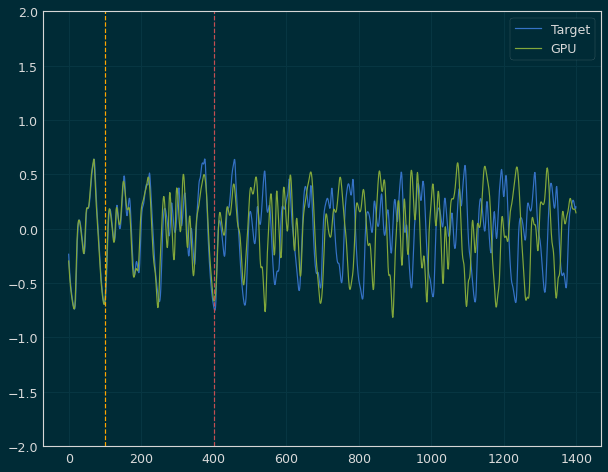

 Iter=33 a=0.722 sr=1.044 amp=0.987  ri=0.297 rr=1.165 loss=0.197927


Iter: 33 #### Diagnostic 0.198   Time 15.41  Best 0.198 NRMSE 0.090 CD 0.107
Iter: 34 #### Diagnostic 1000.000   Time 13.74  Best 0.198 NRMSE 1000.000 CD nan
Iter: 35 #### Diagnostic 1.071   Time 17.16  Best 0.198 NRMSE 0.260 CD 0.811
Iter: 36 #### Diagnostic 1000.000   Time 12.17  Best 0.198 NRMSE 29864227297815437312.000 CD 1.000
Iter: 37 #### Diagnostic 1.005   Time 15.27  Best 0.198 NRMSE 0.198 CD 0.807
Iter: 38 #### Diagnostic 0.832   Time 15.72  Best 0.198 NRMSE 0.193 CD 0.638
Iter: 39 #### Diagnostic 0.962   Time 19.19  Best 0.198 NRMSE 0.196 CD 0.766
Iter: 40 #### Diagnostic 1.107   Time 15.79  Best 0.198 NRMSE 0.210 CD 0.897
Iter: 41 #### Diagnostic 1.035   Time 19.17  Best 0.198 NRMSE 0.199 CD 0.836
Iter: 42 #### Diagnostic 0.450   Time 21.71  Best 0.198 NRMSE 0.155 CD 0.295
Iter: 43 #### Diagnostic 1000.000   Time 19.92  Best 0.198 NRMSE 1000.000 CD nan
Iter: 44 #### Diagnostic 1000.000   Time 16.71  Best

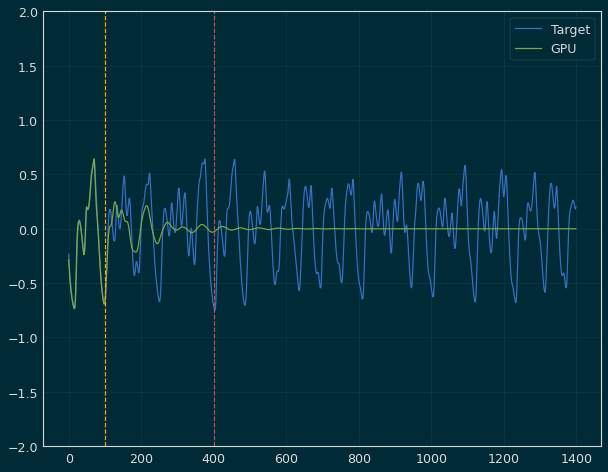

 Iter=2 a=0.197 sr=3.681 amp=0.102  ri=0.338 rr=2.310 loss=0.555864


Iter: 2 #### Diagnostic 0.556   Time 17.34  Best 0.556 NRMSE 0.164 CD 0.392
Iter: 3 #### Diagnostic 1000.000   Time 15.32  Best 0.556 NRMSE 1000.000 CD nan
Iter: 4 #### Diagnostic 1000.000   Time 19.96  Best 0.556 NRMSE 1000.000 CD nan
Iter: 5 #### Diagnostic 1000.000   Time 14.54  Best 0.556 NRMSE 1000.000 CD nan
Iter: 6 #### Diagnostic 0.736   Time 12.59  Best 0.556 NRMSE 0.206 CD 0.530
Iter: 7 #### Diagnostic 1000.000   Time 16.97  Best 0.556 NRMSE 1000.000 CD nan
Iter: 8 #### Diagnostic 0.863   Time 17.40  Best 0.556 NRMSE 0.207 CD 0.656
Iter: 9 #### Diagnostic 1000.000   Time 16.09  Best 0.556 NRMSE 1000.000 CD nan
Iter: 10 #### Diagnostic 1000.000   Time 17.64  Best 0.556 NRMSE 1000.000 CD nan
Iter: 11 #### Diagnostic 0.707   Time 15.08  Best 0.556 NRMSE 0.182 CD 0.525
Iter: 12 #### Diagnostic 1000.000   Time 17.35  Best 0.556 NRMSE 1000.000 CD nan
Iter: 13 #### Diagnostic 1000.000   Time 12.55  Best 0.556 NRMS

Iter: 0 #### Diagnostic 1000.000   Time 9.91  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 1 #### Diagnostic 1000.000   Time 9.20  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 2 #### Diagnostic 1000.000   Time 12.92  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 3 #### Diagnostic 1000.000   Time 11.26  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 4 #### Diagnostic 1.215   Time 12.06  Best 1000.000 NRMSE 0.217 CD 0.998
Iter: 5 #### Diagnostic 1000.000   Time 13.33  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 6 #### Diagnostic 1000.000   Time 9.66  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 7 #### Diagnostic 1000.000   Time 14.49  Best 1000.000 NRMSE 1000.000 CD nan


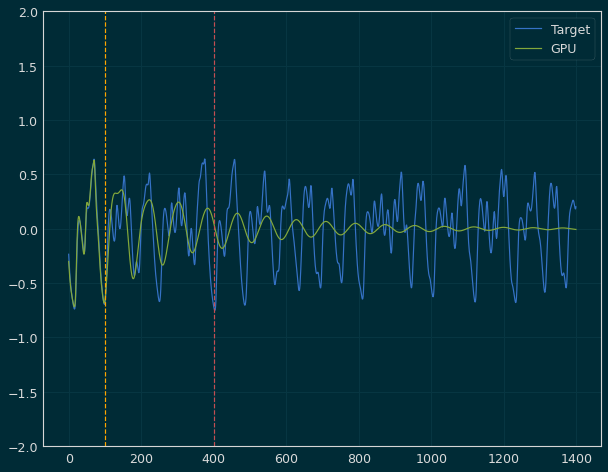

 Iter=8 a=0.044 sr=1.570 amp=0.477  ri=0.038 rr=0.031 loss=0.685538


Iter: 8 #### Diagnostic 0.686   Time 16.36  Best 0.686 NRMSE 0.180 CD 0.506
Iter: 9 #### Diagnostic 1000.000   Time 11.27  Best 0.686 NRMSE 1000.000 CD nan
Iter: 10 #### Diagnostic 1.481   Time 14.64  Best 0.686 NRMSE 0.310 CD 1.172
Iter: 11 #### Diagnostic 1000.000   Time 11.01  Best 0.686 NRMSE 1000.000 CD nan
Iter: 12 #### Diagnostic 1000.000   Time 10.52  Best 0.686 NRMSE 1000.000 CD nan
Iter: 13 #### Diagnostic 0.956   Time 12.67  Best 0.686 NRMSE 0.199 CD 0.757
Iter: 14 #### Diagnostic 1000.000   Time 10.51  Best 0.686 NRMSE 1000.000 CD nan


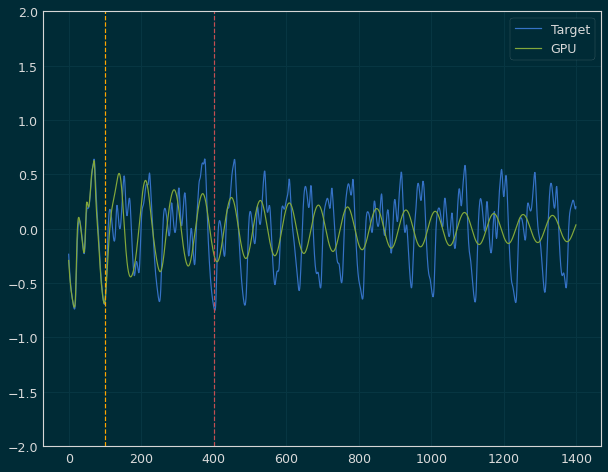

 Iter=15 a=0.090 sr=2.324 amp=0.111  ri=0.140 rr=3.057 loss=0.609669


Iter: 15 #### Diagnostic 0.610   Time 12.43  Best 0.610 NRMSE 0.177 CD 0.433
Iter: 16 #### Diagnostic 1000.000   Time 9.86  Best 0.610 NRMSE 1000.000 CD nan
Iter: 17 #### Diagnostic 1000.000   Time 8.84  Best 0.610 NRMSE 1000.000 CD nan
Iter: 18 #### Diagnostic 0.872   Time 11.30  Best 0.610 NRMSE 0.211 CD 0.661
Iter: 19 #### Diagnostic 0.937   Time 8.67  Best 0.610 NRMSE 0.193 CD 0.744
Iter: 20 #### Diagnostic 1000.000   Time 9.40  Best 0.610 NRMSE 1000.000 CD nan
Iter: 21 #### Diagnostic 0.886   Time 7.89  Best 0.610 NRMSE 0.196 CD 0.690
Iter: 22 #### Diagnostic 1000.000   Time 8.08  Best 0.610 NRMSE 1000.000 CD nan
Iter: 23 #### Diagnostic 1000.000   Time 7.07  Best 0.610 NRMSE 1000.000 CD nan


KeyboardInterrupt: 

In [10]:
CALLS = 100
s = torch.torch.from_numpy(signal).cuda(DEVICE).type(dtype)

size = [1000,900,800,700,600,500,400,300,200,100,50]
rand_state = [11,37,3,24,91]

for N in size:
    min_a, max_a = .001, 1.
    min_sr, max_sr = .001, 8.
    min_g, max_g = .001, 1.
    min_ri, max_ri = .001, 1.
    min_rr, max_rr = .001, 5.
    space = [Real(min_a, max_a, name='a'),
                     Real(min_sr, max_sr, name='sr'),
                     Real(min_g, max_g, name='amp'), 
                     Real(min_ri, max_ri, name='ri'),
                     Real(min_rr, max_rr, name='rr')
                    ]
    for ref in range(5):
        start = time.time()
        alphas = []
        rhos = []
        gammas = []
        inScales = []
        resScales = []

        for rn in range(5):
            running_error = 1000
            counter = 0 
            print(f'\n ********** {N} ***********')
            result_gp = gp_minimize(loop,
                                    space,
                                    n_calls=CALLS,
                                    random_state=rand_state[rn],
                                    n_jobs=-1,
                                    n_initial_points=100)
            print(f'\nBest result = {result_gp.fun}')
            names = ['a','sr','amp','ri','rr']
            for i in range(len(space)):
                print(f'{names[i]} = {result_gp.x[i]}')

        min_a, max_a   = resize_spaces(min_a, max_a,
                                       np.array(alphas),
                                       isAlpha=True)
        min_sr, max_sr = resize_spaces(min_sr, max_sr, np.array(rhos))
        min_g, max_g   = resize_spaces(min_g, max_g, np.array(gammas))
        min_ri, max_ri = resize_spaces(min_ri, max_ri, np.array(inScales))
        min_rr, max_rr = resize_spaces(min_rr, max_rr, np.array(resScales))
        print('Refined search bounds:\n')
        print(f'Alpha ({min_a}, {max_a})\n')
        print(f'Rho ({min_sr}, {max_sr})\n')
        print(f'Gamma ({min_g}, {max_g})\n')
        print(f'r-in ({min_ri}, {max_ri})\n')
        print(f'r-res ({min_rr}, {max_rr})\n')
        end = time.time()-start
        print(f'End Refinement Run {ref} Time {end:.3f}')

## End Model

In [ ]:
def rank_curve(cplus, tols):
    rank_tols = []
    for i in tols:
        rank_tols.append(rca.rank(cplus, i))
    return np.array(rank_tols)

iteration = [18,18,79,36,47,16,59,36,91,43,133,43,111,43,135,43,80,0,43,39]
size = [1000]#,950,900,850,800,750,700,650,600,550,500,
        #450,400,350,300,250,200,150,100,50]

TOLS = [1/10**(x) for x in range(0,20)]
mm_ranks = []
for ctr,N in zip(iteration,size):
    fn_mats = f'./MultiModelMG/Mats/MG_it{ctr}_{N}_Wnet.npy'
    fn_params = f'./MultiModelMG/Params/MG_it{ctr}_{N}_InstanceParams.npy'
    p = np.load(fn_params, allow_pickle=True)
    a,g = p[0],p[2]

    Wr, Wi = rca.get_mats(fn_mats, K, N)
    xeq = np.zeros((N,1))
    ueq = np.zeros((K,1))
    A = rca.leaky_jacobian(xeq, ueq, a, g, Wi, Wr)
    B = rca.partial_u(xeq, ueq, a, g, Wi, Wr)

    Cplus = np.nan_to_num(rca.reachable_matrix(A, B),0,0,0)
    spec = np.linalg.eigvals(Cplus)
    evs= np.abs(spec)
    Cplus = Cplus/np.max(evs)
    rkc = rank_curve(Cplus,TOLS)
    v = np.argmax(np.gradient(rkc))-1
    ave_rank = (rkc[v]+rkc[v+1])/2
    print(f'Pair: iter {ctr} size {N} argmax {v} {v+1} tol {TOLS[v]} ave {ave_rank}')
    mm_ranks.append(ave_rank)

In [ ]:
    
np.save('./MultiModelMG/MG_MMranks',np.array(mm_ranks))

In [ ]:
plt.plot(size,mm_ranks)
plt.show()

In [ ]:
minmax = np.max(signal[:TRAINLENGTH+TEST])-np.min(signal[:TRAINLENGTH+TEST])
err_list = []
for ctr,N in zip(iteration,size):
    pred = np.load(f'./MultiModelMG/Preds/MG_it{ctr}_{N}_Preds.npy', allow_pickle=True)
    nrmse = mean_squared_error(signal[TRAINLENGTH:TRAINLENGTH+TEST],pred[TRAINLENGTH:TRAINLENGTH+TEST],
                               squared=False, multioutput='raw_values')
    print(nrmse/minmax)
    err_list.append(nrmse/minmax)
np.save('./MultiModelMG/MG_mm_errors',np.array(err_list))

plt.plot(size,err_list)
plt.show()

In [ ]:
total = 0.
no_outliers = []
for i in range(len(mm_ranks)):
    if(size[i] in [600,1000]):
        pass
    else:
        total += mm_ranks[i]
        no_outliers.append(mm_ranks[i])
total/(len(mm_ranks)-2)